# Import data and packages

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import umap
import seaborn as sns
import statsmodels.api as sm
import math
import pyranges as pr
from sklearn.neighbors import NearestNeighbors
from intervaltree import Interval, IntervalTree
from collections import defaultdict
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.cluster.hierarchy import dendrogram
from lineage_colors import lineage_colors
import matplotlib.patches as mpatches
!pip install intervaltree

ATAC = pd.read_csv("data/1.ATAC-Seq data.CSV", sep=";")
# ATAC_Bcells in der Form importieren?
# ATAC_T_Bcells = pd.read_csv("data/ATAC_T_Bcells.csv", sep=";") -> Falsch

c:\Users\annal\miniconda3\envs\envBCells1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Info about the data

In [76]:
ATAC.head()

ImmGenATAC1219.peakID chrom   Summit  mm10.60way.phastCons_scores  \
0  ImmGenATAC1219.peak_1  chr1  3020786                         0.00   
1  ImmGenATAC1219.peak_2  chr1  3087226                         0.00   
2  ImmGenATAC1219.peak_3  chr1  3120109                         0.07   
3  ImmGenATAC1219.peak_4  chr1  3121485                         0.15   
4  ImmGenATAC1219.peak_5  chr1  3372787                         0.03   

   _-log10_bestPvalue  Included.in.systematic.analysis  TSS  \
0                0.56                              NaN  NaN   
1                0.50                              NaN  NaN   
2            45879.00                              1.0  NaN   
3            45691.00                              1.0  NaN   
4            11324.00                              NaN  NaN   

  genes.within.100Kb  LTHSC.34-.BM  LTHSC.34+.BM  ...  DC.4+.Sp  DC.8+.Sp  \
0                NaN          0.41          0.71  ...      0.10      0.10   
1                NaN          0.41      23377.00  ...  45839.00      0.10   
2                NaN      13181.00          0.10  ...      0.87      0.54   
3                NaN          0.41          0.10  ...      0.44  30317.00   
4                NaN          0.41          0.10  ...      0.44      0.10   

   DC.pDC.Sp  DC.103+11b+.SI  DC.103+11b-.SI   FRC.SLN   IAP.SLN   BEC.SLN  \
0   43525.00        13516.00            0.52  46388.00      0.10      0.57   
1   14977.00            0.47            0.11      0.92      0.98  42401.00   
2   26330.00            0.95            0.11     63.38  33817.00  12055.00   
3       0.66            0.11            0.92  45790.00      0.98  46753.00   
4       0.66        28856.00            0.51      0.92      0.75  12055.00   

   LEC.SLN  Ep.MEChi.Th  
0  46447.0     14977.00  
1  12451.0         0.94  
2  45748.0         0.11  
3  45748.0         0.11  
4  22282.0     45781.00  

[5 rows x 98 columns]

In [77]:
ATAC.shape

(512595, 98)

In [78]:
ATAC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512595 entries, 0 to 512594
Data columns (total 98 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   ImmGenATAC1219.peakID            512595 non-null  object 
 1   chrom                            512595 non-null  object 
 2   Summit                           512595 non-null  int64  
 3   mm10.60way.phastCons_scores      512595 non-null  float64
 4   _-log10_bestPvalue               512595 non-null  float64
 5   Included.in.systematic.analysis  334879 non-null  float64
 6   TSS                              14292 non-null   object 
 7   genes.within.100Kb               427710 non-null  object 
 8   LTHSC.34-.BM                     512595 non-null  float64
 9   LTHSC.34+.BM                     512595 non-null  float64
 10  STHSC.150-.BM                    512595 non-null  float64
 11  MPP4.135+.BM                     512595 non-null  float64
 12  pr

In [79]:
ATAC.describe()

Summit  mm10.60way.phastCons_scores  _-log10_bestPvalue  \
count  5.125950e+05                512595.000000           512595.00   
mean   7.596866e+07                     0.164662                 inf   
std    4.450542e+07                     0.203403                 NaN   
min    1.430000e+02                     0.000000                0.00   
25%    3.802562e+07                     0.030000               27.55   
50%    7.364690e+07                     0.080000            23408.00   
75%    1.091549e+08                     0.220000            44197.00   
max    1.953715e+08                     1.000000                 inf   

       Included.in.systematic.analysis   LTHSC.34-.BM   LTHSC.34+.BM  \
count                         334879.0  512595.000000  512595.000000   
mean                               1.0    6095.046919   12936.332385   
std                                0.0    9788.773579   14163.202535   
min                                1.0       0.410000       0.100000   
25%                                1.0       0.410000       0.710000   
50%                                1.0       0.410000      73.770000   
75%                                1.0   13181.000000   23377.000000   
max                                1.0   46017.000000   46296.000000   

       STHSC.150-.BM   MPP4.135+.BM    proB.CLP.BM    proB.FrA.BM  ...  \
count  512595.000000  512595.000000  512595.000000  512595.000000  ...   
mean    13396.369554   14257.896763   18034.640712   17227.101166  ...   
std     16375.735345   16906.870910   18783.480143   18493.944435  ...   
min         0.110000       0.110000       0.110000       0.100000  ...   
25%         0.110000       0.110000       0.470000       0.630000  ...   
50%         0.900000      27.810000   16011.000000   12420.000000  ...   
75%     31048.000000   21217.000000   41365.000000   34335.000000  ...   
max     46296.000000   46508.000000   47453.000000   47453.000000  ...   

            DC.4+.Sp       DC.8+.Sp      DC.pDC.Sp  DC.103+11b+.SI  \
count  512595.000000  512595.000000  512595.000000   512595.000000   
mean    19704.822925   14624.972269   19226.011170    16158.995852   
std     20004.913558   16857.827083   18360.437997    17876.007879   
min         0.100000       0.100000       0.110000        0.110000   
25%         0.770000       0.540000       0.660000        0.530000   
50%     15462.000000   11475.000000   17319.000000    13516.000000   
75%     44197.000000   28856.000000   41640.000000    30468.000000   
max     47453.000000   47423.000000   47453.000000    47453.000000   

       DC.103+11b-.SI        FRC.SLN        IAP.SLN        BEC.SLN  \
count   512595.000000  512595.000000  512595.000000  512595.000000   
mean     14094.576211   18267.934653   17140.037676   17792.495176   
std      16726.326963   18369.989966   18401.952190   18063.846271   
min          0.110000       0.110000       0.100000       0.110000   
25%          0.520000       0.560000       0.720000       0.570000   
50%         61.080000   17168.000000   13516.000000   15766.000000   
75%      27242.000000   35065.000000   33239.000000   33604.000000   
max      47453.000000   47453.000000   47392.000000   47178.000000   

             LEC.SLN    Ep.MEChi.Th  
count  512595.000000  512595.000000  
mean    22193.477680   15764.502827  
std     19084.434031   17767.205876  
min         0.110000       0.110000  
25%         0.640000       0.530000  
50%     22282.000000   13150.000000  
75%     44927.000000   31413.000000  
max     47300.000000   47453.000000  

[8 rows x 94 columns]

# Data Clean-up

In [80]:
#coloums with numerical datas 
float_cols = ATAC.select_dtypes(include=['float64']).columns
print(float_cols)
ATAC_num = ATAC.select_dtypes(include=['float64'])
ATAC_num.head()

Index(['mm10.60way.phastCons_scores', '_-log10_bestPvalue',
       'Included.in.systematic.analysis', 'LTHSC.34-.BM', 'LTHSC.34+.BM',
       'STHSC.150-.BM', 'MPP4.135+.BM', 'proB.CLP.BM', 'proB.FrA.BM',
       'proB.FrBC.BM', 'preB.FrD.BM', 'B.FrE.BM', 'B1b.PC', 'B.T1.Sp',
       'B.T2.Sp', 'B.T3.Sp', 'B.Sp', 'B.Fem.Sp', 'B.MZ.Sp', 'B.Fo.Sp',
       'B.mem.Sp', 'B.GC.CB.Sp', 'B.GC.CC.Sp', 'B.PB.Sp', 'B.PC.Sp', 'B.PC.BM',
       'preT.DN1.Th', 'preT.DN2a.Th', 'preT.DN2b.Th', 'preT.DN3.Th',
       'T.DN4.Th', 'T.ISP.Th', 'T.DP.Th', 'T.4.Th', 'T.8.Th', 'T.4.Nve.Sp',
       'T.4.Nve.Fem.Sp', 'T.8.Nve.Sp', 'T.4.Sp.aCD3+CD40.18hr',
       'Treg.4.FP3+.Nrplo.Co', 'Treg.4.25hi.Sp', 'T8.TN.P14.Sp',
       'T8.IEL.LCMV.d7.SI', 'T8.TE.LCMV.d7.Sp', 'T8.MP.LCMV.d7.Sp',
       'T8.Tcm.LCMV.d180.Sp', 'T8.Tem.LCMV.d180.Sp', 'NKT.Sp',
       'NKT.Sp.LPS.3hr', 'NKT.Sp.LPS.18hr', 'NKT.Sp.LPS.3d',
       'Tgd.g2+d17.24a+.Th', 'Tgd.g2+d17.LN', 'Tgd.g2+d1.24a+.Th',
       'Tgd.g2+d1.LN', 'Tgd.g1.1+d1.24a+.

mm10.60way.phastCons_scores  _-log10_bestPvalue  \
0                         0.00                0.56   
1                         0.00                0.50   
2                         0.07            45879.00   
3                         0.15            45691.00   
4                         0.03            11324.00   

   Included.in.systematic.analysis  LTHSC.34-.BM  LTHSC.34+.BM  STHSC.150-.BM  \
0                              NaN          0.41          0.71           0.90   
1                              NaN          0.41      23377.00           0.90   
2                              1.0      13181.00          0.10           0.90   
3                              1.0          0.41          0.10           0.11   
4                              NaN          0.41          0.10           0.11   

   MPP4.135+.BM  proB.CLP.BM  proB.FrA.BM  proB.FrBC.BM  ...  DC.4+.Sp  \
0          0.11     34335.00         0.10          0.11  ...      0.10   
1          0.83         0.47         0.34          0.82  ...  45839.00   
2          0.11         0.47         0.10          0.50  ...      0.87   
3          0.11         0.79         0.40          0.50  ...      0.44   
4          0.11         0.47         0.34      28491.00  ...      0.44   

   DC.8+.Sp  DC.pDC.Sp  DC.103+11b+.SI  DC.103+11b-.SI   FRC.SLN   IAP.SLN  \
0      0.10   43525.00        13516.00            0.52  46388.00      0.10   
1      0.10   14977.00            0.47            0.11      0.92      0.98   
2      0.54   26330.00            0.95            0.11     63.38  33817.00   
3  30317.00       0.66            0.11            0.92  45790.00      0.98   
4      0.10       0.66        28856.00            0.51      0.92      0.75   

    BEC.SLN  LEC.SLN  Ep.MEChi.Th  
0      0.57  46447.0     14977.00  
1  42401.00  12451.0         0.94  
2  12055.00  45748.0         0.11  
3  46753.00  45748.0         0.11  
4  12055.00  22282.0     45781.00  

[5 rows x 93 columns]

In [81]:
#remove col accoring to Included.in.systematic.analysis 
ATAC_included_values = ATAC_num.drop(columns=['Included.in.systematic.analysis'])
ATAC_included_values = ATAC_included_values.replace([np.inf, -np.inf], np.nan).dropna()
ATAC_included_values.head()

mm10.60way.phastCons_scores  _-log10_bestPvalue  LTHSC.34-.BM  \
0                         0.00                0.56          0.41   
1                         0.00                0.50          0.41   
2                         0.07            45879.00      13181.00   
3                         0.15            45691.00          0.41   
4                         0.03            11324.00          0.41   

   LTHSC.34+.BM  STHSC.150-.BM  MPP4.135+.BM  proB.CLP.BM  proB.FrA.BM  \
0          0.71           0.90          0.11     34335.00         0.10   
1      23377.00           0.90          0.83         0.47         0.34   
2          0.10           0.90          0.11         0.47         0.10   
3          0.10           0.11          0.11         0.79         0.40   
4          0.10           0.11          0.11         0.47         0.34   

   proB.FrBC.BM  preB.FrD.BM  ...  DC.4+.Sp  DC.8+.Sp  DC.pDC.Sp  \
0          0.11     25204.00  ...      0.10      0.10   43525.00   
1          0.82         0.13  ...  45839.00      0.10   14977.00   
2          0.50     42736.00  ...      0.87      0.54   26330.00   
3          0.50     44958.00  ...      0.44  30317.00       0.66   
4      28491.00     42736.00  ...      0.44      0.10       0.66   

   DC.103+11b+.SI  DC.103+11b-.SI   FRC.SLN   IAP.SLN   BEC.SLN  LEC.SLN  \
0        13516.00            0.52  46388.00      0.10      0.57  46447.0   
1            0.47            0.11      0.92      0.98  42401.00  12451.0   
2            0.95            0.11     63.38  33817.00  12055.00  45748.0   
3            0.11            0.92  45790.00      0.98  46753.00  45748.0   
4        28856.00            0.51      0.92      0.75  12055.00  22282.0   

   Ep.MEChi.Th  
0     14977.00  
1         0.94  
2         0.11  
3         0.11  
4     45781.00  

[5 rows x 92 columns]

In [82]:
# standardizing the values 
scaler = StandardScaler()
ATAC_scaled = scaler.fit_transform(ATAC_included_values)
ATAC_scaled = pd.DataFrame(ATAC_scaled, columns=ATAC_included_values.columns)
ATAC_scaled.head()

mm10.60way.phastCons_scores  _-log10_bestPvalue  LTHSC.34-.BM  \
0                    -0.809539           -1.322500     -0.622619   
1                    -0.809539           -1.322503     -0.622619   
2                    -0.465393            1.249028      0.723878   
3                    -0.072084            1.238491     -0.622619   
4                    -0.662048           -0.687811     -0.622619   

   LTHSC.34+.BM  STHSC.150-.BM  MPP4.135+.BM  proB.CLP.BM  proB.FrA.BM  \
0     -0.913335      -0.818014     -0.843321     0.867794    -0.931503   
1      0.737160      -0.818014     -0.843278    -0.960118    -0.931490   
2     -0.913378      -0.818014     -0.843321    -0.960118    -0.931503   
3     -0.913378      -0.818063     -0.843321    -0.960101    -0.931487   
4     -0.913378      -0.818063     -0.843321    -0.960118    -0.931490   

   proB.FrBC.BM  preB.FrD.BM  ...  DC.4+.Sp  DC.8+.Sp  DC.pDC.Sp  \
0     -0.956155     0.241998  ... -0.985004 -0.867550   1.323434   
1     -0.956118    -1.104052  ...  1.306379 -0.867550  -0.231432   
2     -0.956135     1.178320  ... -0.984966 -0.867524   0.386909   
3     -0.956135     1.296989  ... -0.984987  0.930837  -1.047119   
4      0.543993     1.178320  ... -0.984987 -0.867550  -1.047119   

   DC.103+11b+.SI  DC.103+11b-.SI   FRC.SLN   IAP.SLN   BEC.SLN   LEC.SLN  \
0       -0.147860       -0.842635  1.530753 -0.931429 -0.984957  1.270846   
1       -0.903931       -0.842659 -0.994405 -0.931381  1.362299 -0.510506   
2       -0.903904       -0.842659 -0.991005  0.906252 -0.317633  1.234219   
3       -0.903951       -0.842611  1.498200 -0.931381  1.603222  1.234219   
4        0.710273       -0.842635 -0.994405 -0.931393 -0.317633  0.004627   

   Ep.MEChi.Th  
0    -0.044332  
1    -0.887236  
2    -0.887283  
3    -0.887283  
4     1.689424  

[5 rows x 92 columns]

In [83]:
# check if standardization worked
print("mean (should be ~0):", np.mean(ATAC_scaled, axis=0))
print("sd (should be ~1):", np.std(ATAC_scaled, axis=0))

mean (should be ~0): mm10.60way.phastCons_scores   -1.188789e-16
_-log10_bestPvalue            -1.480996e-16
LTHSC.34-.BM                  -3.077323e-16
LTHSC.34+.BM                   6.387524e-17
STHSC.150-.BM                  7.474290e-17
                                   ...     
FRC.SLN                        3.832514e-16
IAP.SLN                       -1.583574e-16
BEC.SLN                        3.459909e-17
LEC.SLN                       -1.517037e-16
Ep.MEChi.Th                    2.708044e-16
Length: 92, dtype: float64
sd (should be ~1): mm10.60way.phastCons_scores    1.0
_-log10_bestPvalue             1.0
LTHSC.34-.BM                   1.0
LTHSC.34+.BM                   1.0
STHSC.150-.BM                  1.0
                              ... 
FRC.SLN                        1.0
IAP.SLN                        1.0
BEC.SLN                        1.0
LEC.SLN                        1.0
Ep.MEChi.Th                    1.0
Length: 92, dtype: float64


## ATAC transposed dataset - B-cell specific

In [84]:
# of scaled values
ATAC_scaled_Peaks_Bcells = ATAC_scaled.iloc[:, 2:31]
ATAC_T_scaled_Bcells = ATAC_scaled_Peaks_Bcells.T
ATAC_T_scaled_Bcells.head()

0         1         2         3         4         5       \
LTHSC.34-.BM  -0.622619 -0.622619  0.723878 -0.622619 -0.622619  0.723878   
LTHSC.34+.BM  -0.913335  0.737160 -0.913378 -0.913378 -0.913378  0.737160   
STHSC.150-.BM -0.818014 -0.818014 -0.818014 -0.818063 -0.818063  1.077905   
MPP4.135+.BM  -0.843321 -0.843278 -0.843321 -0.843321 -0.843321  0.409772   
proB.CLP.BM    0.867794 -0.960118 -0.960118 -0.960101 -0.960118  1.488393   

                 6         7         8         9       ...    512580  \
LTHSC.34-.BM  -0.622619  0.723878  0.767295 -0.621946  ...  0.767295   
LTHSC.34+.BM  -0.913378 -0.913335 -0.913378 -0.913378  ... -0.912441   
STHSC.150-.BM -0.818063 -0.818014 -0.818014 -0.818063  ...  0.451491   
MPP4.135+.BM  -0.843321 -0.843321 -0.843321 -0.843321  ... -0.025909   
proB.CLP.BM   -0.960137  0.148332 -0.960120 -0.960118  ...  1.482909   

                 512581    512582    512583    512584    512585    512586  \
LTHSC.34-.BM  -0.622619 -0.622619 -0.622619  0.723878  0.767295 -0.622619   
LTHSC.34+.BM   0.558881  2.355367  0.156853  1.138976  1.138976  0.156853   
STHSC.150-.BM  0.722929  0.345481  1.077905 -0.818014  0.345481  0.345481   
MPP4.135+.BM   0.411606  1.642998  0.218844  1.642998  0.411606  1.862672   
proB.CLP.BM    0.172555  0.772231  0.524194  1.473752  1.397622 -0.057541   

                 512587    512588    512589  
LTHSC.34-.BM  -0.622619 -0.622619 -0.622619  
LTHSC.34+.BM  -0.913335  0.737160 -0.913335  
STHSC.150-.BM -0.818063 -0.818063 -0.818014  
MPP4.135+.BM  -0.843278 -0.843278  0.218844  
proB.CLP.BM   -0.960095 -0.960095  0.694450  

[5 rows x 512590 columns]

In [85]:
# included in systematic analysis - makes more sense because we only look at B-cells anyway
ATAC_included_values_Bcells = ATAC_included_values.iloc[:, 2:25]
ATAC_T_included_values_Bcells = ATAC_included_values_Bcells.T
ATAC_T_included_values_Bcells.head()

0         1         2       3       4        5       6       \
LTHSC.34-.BM       0.41      0.41  13181.00    0.41    0.41  13181.0    0.41   
LTHSC.34+.BM       0.71  23377.00      0.10    0.10    0.10  23377.0    0.10   
STHSC.150-.BM      0.90      0.90      0.90    0.11    0.11  31048.0    0.11   
MPP4.135+.BM       0.11      0.83      0.11    0.11    0.11  21186.0    0.11   
proB.CLP.BM    34335.00      0.47      0.47    0.79    0.47  45992.0    0.11   

                 7         8       9       ...    512585    512586    512587  \
LTHSC.34-.BM   13181.00  13606.00    7.00  ...  13606.00      0.41      0.41   
LTHSC.34+.BM       0.71      0.10    0.10  ...     13.37  20852.00  46296.00   
STHSC.150-.BM      0.90      0.90    0.11  ...  20790.00  25235.00  19054.00   
MPP4.135+.BM       0.11      0.11    0.11  ...  13820.00  21217.00  42036.00   
proB.CLP.BM    20821.00      0.42    0.47  ...  45889.00  21276.00  32540.00   

                 512588   512589   512590    512591  512592    512593  \
LTHSC.34-.BM       0.41  13181.0  13606.0      0.41    0.41      0.41   
LTHSC.34+.BM   15158.00  29068.0  29068.0  15158.00    0.71  23377.00   
STHSC.150-.BM  31048.00      0.9  19054.0  19054.00    0.11      0.11   
MPP4.135+.BM   17958.00  42036.0  21217.0  45750.00    0.83      0.83   
proB.CLP.BM    27881.00  45717.0  44287.0  16954.00    0.90      0.90   

                 512594  
LTHSC.34-.BM       0.41  
LTHSC.34+.BM       0.71  
STHSC.150-.BM      0.90  
MPP4.135+.BM   17958.00  
proB.CLP.BM    31079.00  

[5 rows x 512590 columns]

### Clustering the peaks

In [86]:
#reduce ATAC_scaled to cell-type only columns
non_signal_cols = ['mm10.60way.phastCons_scores', '_-log10_bestPvalue']
ATAC_scaled_ct = ATAC_scaled.drop(columns=non_signal_cols)
ATAC_scaled_ct.to_csv("data/ATAC_scaled.ct.csv", index=False) 
ATAC_scaled_ct.head()

LTHSC.34-.BM  LTHSC.34+.BM  STHSC.150-.BM  MPP4.135+.BM  proB.CLP.BM  \
0     -0.622619     -0.913335      -0.818014     -0.843321     0.867794   
1     -0.622619      0.737160      -0.818014     -0.843278    -0.960118   
2      0.723878     -0.913378      -0.818014     -0.843321    -0.960118   
3     -0.622619     -0.913378      -0.818063     -0.843321    -0.960101   
4     -0.622619     -0.913378      -0.818063     -0.843321    -0.960118   

   proB.FrA.BM  proB.FrBC.BM  preB.FrD.BM  B.FrE.BM    B1b.PC  ...  DC.4+.Sp  \
0    -0.931503     -0.956155     0.241998 -0.977376 -0.882360  ... -0.985004   
1    -0.931490     -0.956118    -1.104052 -0.977401 -0.882315  ...  1.306379   
2    -0.931503     -0.956135     1.178320 -0.977390 -0.882360  ... -0.984966   
3    -0.931487     -0.956135     1.296989 -0.977364 -0.882360  ... -0.984987   
4    -0.931490      0.543993     1.178320 -0.977390 -0.882334  ... -0.984987   

   DC.8+.Sp  DC.pDC.Sp  DC.103+11b+.SI  DC.103+11b-.SI   FRC.SLN   IAP.SLN  \
0 -0.867550   1.323434       -0.147860       -0.842635  1.530753 -0.931429   
1 -0.867550  -0.231432       -0.903931       -0.842659 -0.994405 -0.931381   
2 -0.867524   0.386909       -0.903904       -0.842659 -0.991005  0.906252   
3  0.930837  -1.047119       -0.903951       -0.842611  1.498200 -0.931381   
4 -0.867550  -1.047119        0.710273       -0.842635 -0.994405 -0.931393   

    BEC.SLN   LEC.SLN  Ep.MEChi.Th  
0 -0.984957  1.270846    -0.044332  
1  1.362299 -0.510506    -0.887236  
2 -0.317633  1.234219    -0.887283  
3  1.603222  1.234219    -0.887283  
4 -0.317633  0.004627     1.689424  

[5 rows x 90 columns]

In [87]:
K = range(4, 10)
a = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(ATAC_scaled_ct)
    a.append(kmeans.inertia_)

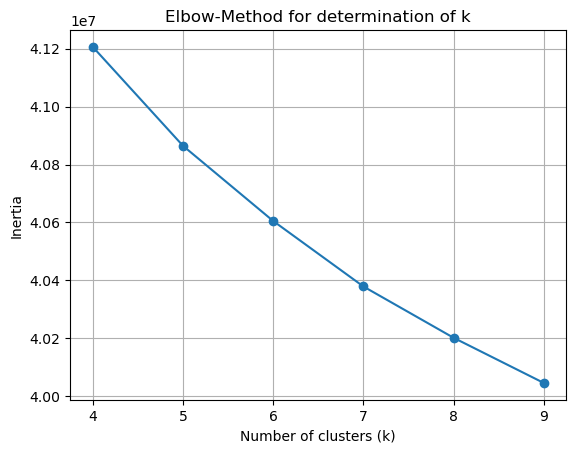

In [88]:
#Elbow-Plot to choose optimal cluster number
plt.plot(K, a, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow-Method for determination of k')
plt.grid(True)
plt.show()

In [89]:
#probably a knik at k=4, but we will also have a look at k=3 and k=5
#Reducing to 10 dimensions through PCA 
pca = PCA(n_components=10)
ATAC_pca10 = pca.fit_transform(ATAC_scaled_ct)

In [90]:
#try clustering with k=(3,4,5) 
kmeans_6 = KMeans(n_clusters=6, random_state=42, n_init=10)
kmeans_6.fit(ATAC_scaled_ct)

kmeans_7 = KMeans(n_clusters=7, random_state=42, n_init=10)
kmeans_7.fit(ATAC_scaled_ct)

kmeans_8 = KMeans(n_clusters=8, random_state=42, n_init=10)
kmeans_8.fit(ATAC_scaled_ct)

labels_6 = kmeans_6.labels_ + 1
labels_7 = kmeans_7.labels_ + 1
labels_8 = kmeans_8.labels_ + 1

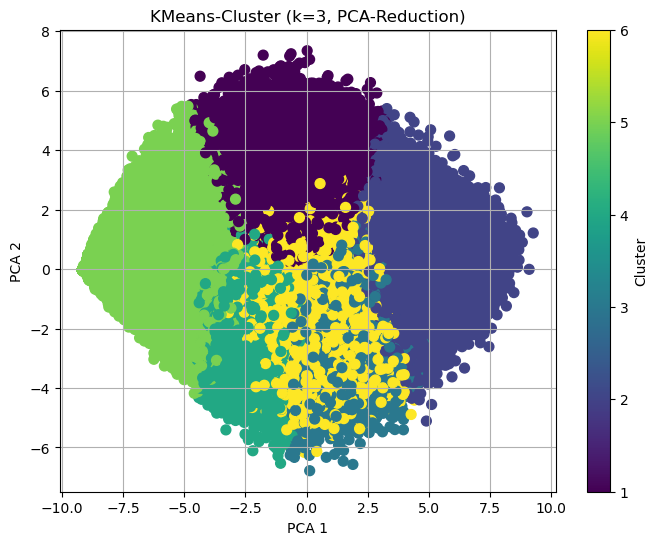

In [91]:
#to visualize PCA und Cluster-Plot 
pca = PCA(n_components=4)
ATAC_pca = pca.fit_transform(ATAC_scaled_ct)

#for k=3
plt.figure(figsize=(8,6))
plt.scatter(ATAC_pca[:, 0], ATAC_pca[:, 1], c=labels_6, cmap='viridis', s=50)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('KMeans-Cluster (k=3, PCA-Reduction)')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

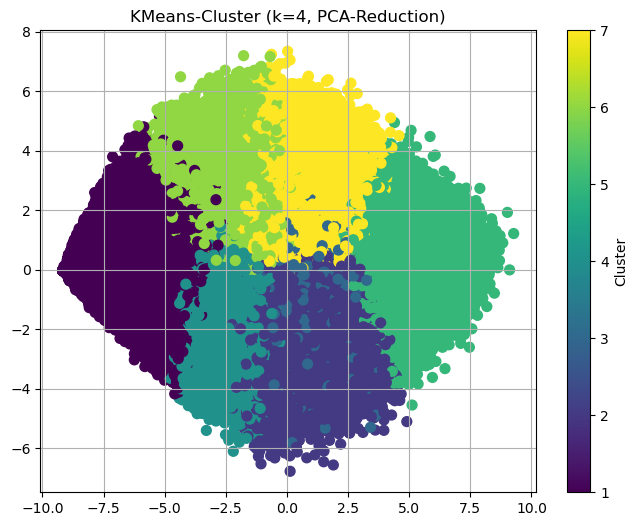

In [92]:
#for k=4
plt.figure(figsize=(8,6))
plt.scatter(ATAC_pca[:, 0], ATAC_pca[:, 1], c=labels_7, cmap='viridis', s=50)
plt.title('KMeans-Cluster (k=4, PCA-Reduction)')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

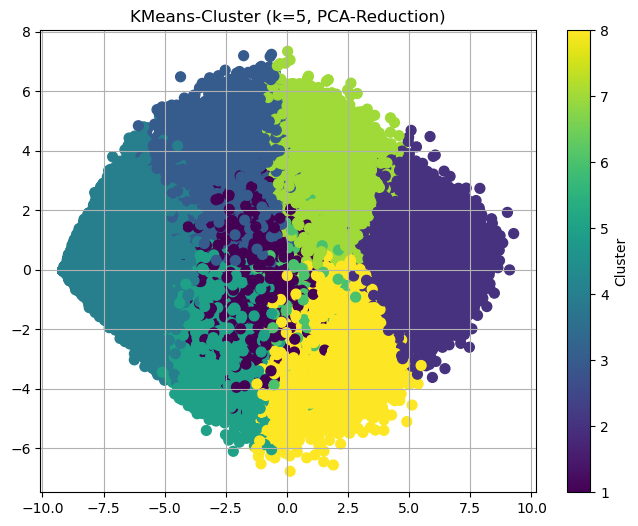

In [93]:
#for k=5
plt.figure(figsize=(8,6))
plt.scatter(ATAC_pca[:, 0], ATAC_pca[:, 1], c=labels_8, cmap='viridis', s=50)
plt.title('KMeans-Cluster (k=5, PCA-Reduction)')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

Since the clusters in the plot of k=7 look well seperated, we choose k=7 for the following analysis.

# Additional plots

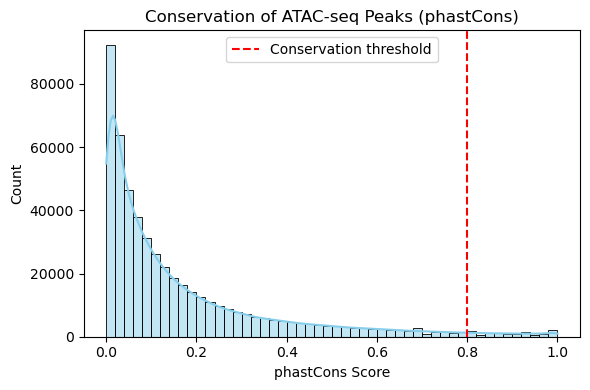

In [94]:
# PhastCons Conservation Score Distribution of ATAC-seq Peaks
phast_scores = ATAC["mm10.60way.phastCons_scores"].dropna()

plt.figure(figsize=(6, 4))
sns.histplot(phast_scores, bins=50, kde=True, color='skyblue')
plt.axvline(0.8, color='red', linestyle='--', label='Conservation threshold')
plt.xlabel('phastCons Score')
plt.title('Conservation of ATAC-seq Peaks (phastCons)')
plt.legend()
plt.tight_layout()
plt.show()

/opt/miniconda3/envs/envBCells1/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


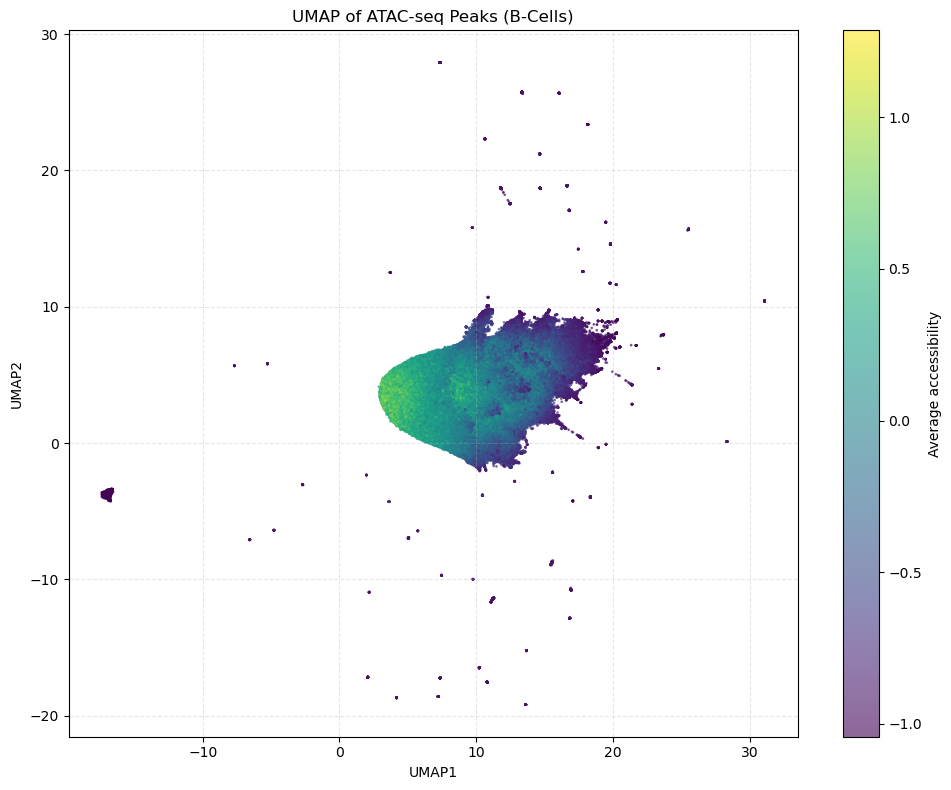

In [95]:
# UMAP B-cells accessibility
qc = pd.read_csv("data/ATAC_QCmatric.csv", sep=";")
qc.columns = qc.columns.str.strip()
qc["CellType"] = qc["CellType"].str.strip()
qc["Lineage"] = qc["Lineage"].str.strip()

b_cells = qc[qc["Lineage"] == "B"]["SampleName"]
b_cell_types = b_cells.str.replace(r"#\d+", "", regex=True)
b_cell_columns = [col for col in ATAC.columns if col in b_cell_types.values]

peak_matrix = ATAC_scaled[b_cell_columns]

signal_array = np.nan_to_num(peak_matrix.values)
signal_scaled = StandardScaler().fit_transform(signal_array)

reducer = umap.UMAP(n_neighbors=30, min_dist=0.05, spread=1.5, metric='cosine', random_state=42)
umap_peaks = reducer.fit_transform(signal_scaled)

signal_mean = signal_array.mean(axis=1)

plt.figure(figsize=(10, 8))
plt.scatter(umap_peaks[:, 0], umap_peaks[:, 1], c=signal_mean, cmap="viridis", s=1, alpha=0.6)
plt.colorbar(label="Average accessibility")
plt.title("UMAP of ATAC-seq Peaks (B-Cells)")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.savefig("figures/UMAP_B_cells.png", dpi=300, bbox_inches="tight")
plt.show()

/opt/miniconda3/envs/envBCells1/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/3f/pxvhxt1x4477ds3p64jyb_6c0000gn/T/ipykernel_15721/4264473392.py:27: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


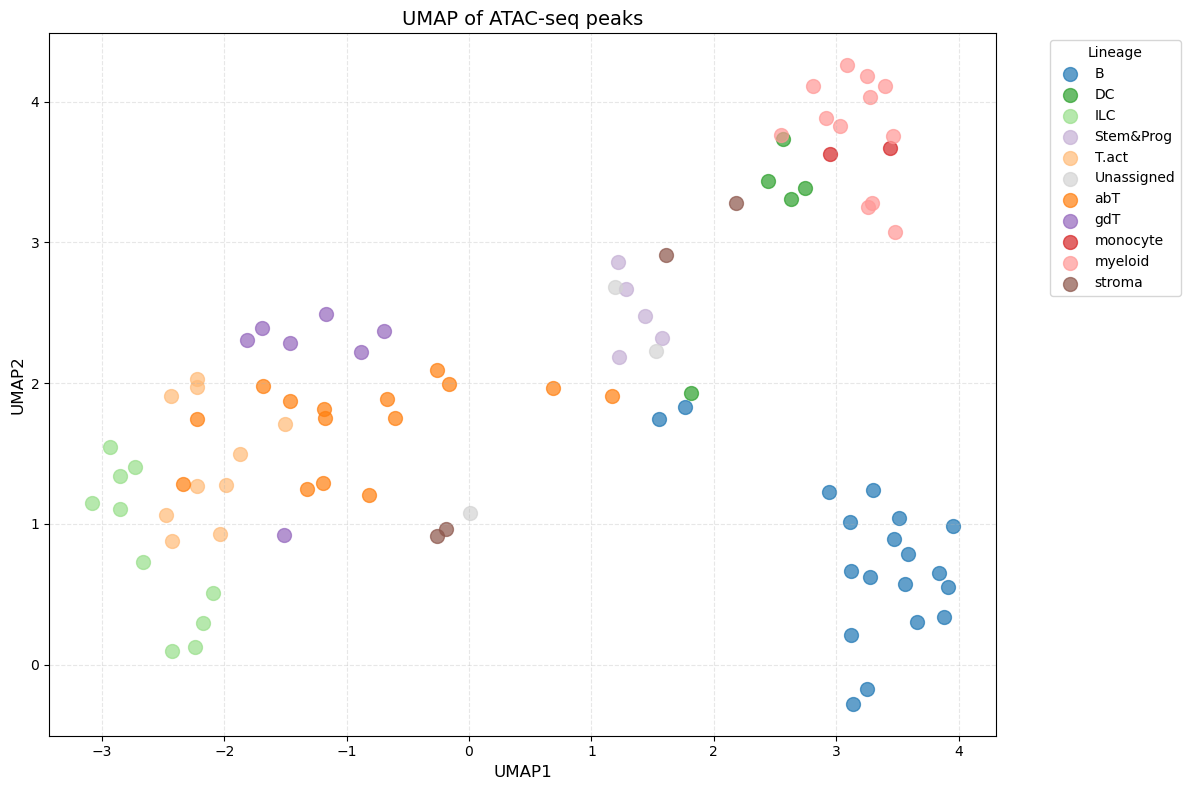

In [96]:
# UMAP ATAC celltypes
ATAC_transposed = ATAC_scaled.T
ATAC_transposed.index.name = "CellType"

qc = pd.read_csv("data/ATAC_QCmatric.csv", sep=";")
qc.columns = qc.columns.str.strip()
qc["CellType"] = qc["CellType"].str.strip()
qc["Lineage"] = qc["Lineage"].str.strip()
celltype_to_lineage = qc.drop_duplicates("CellType").set_index("CellType")["Lineage"]
df_meta = pd.DataFrame(index=ATAC_transposed.index)
df_meta["Lineage"] = df_meta.index.map(celltype_to_lineage).fillna("Unassigned")

# colors
df_meta["Color"] = df_meta["Lineage"].map(lineage_colors)

# UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)
umap_embedding = reducer.fit_transform(ATAC_transposed)

df_meta["UMAP1"] = umap_embedding[:, 0]
df_meta["UMAP2"] = umap_embedding[:, 1]

# Plot
plt.figure(figsize=(12, 8))

for lineage, group in df_meta.groupby("Lineage"):
    plt.scatter(
        group["UMAP1"],
        group["UMAP2"],
        c=group["Color"].iloc[0],
        label=lineage,
        s=100,
        alpha=0.7
    )

plt.title('UMAP of ATAC-seq peaks', fontsize=14)
plt.xlabel('UMAP1', fontsize=12)
plt.ylabel('UMAP2', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Lineage")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig("figures/UMAP_ATAC_ct.png", dpi=300, bbox_inches="tight")
plt.show()

/opt/miniconda3/envs/envBCells1/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


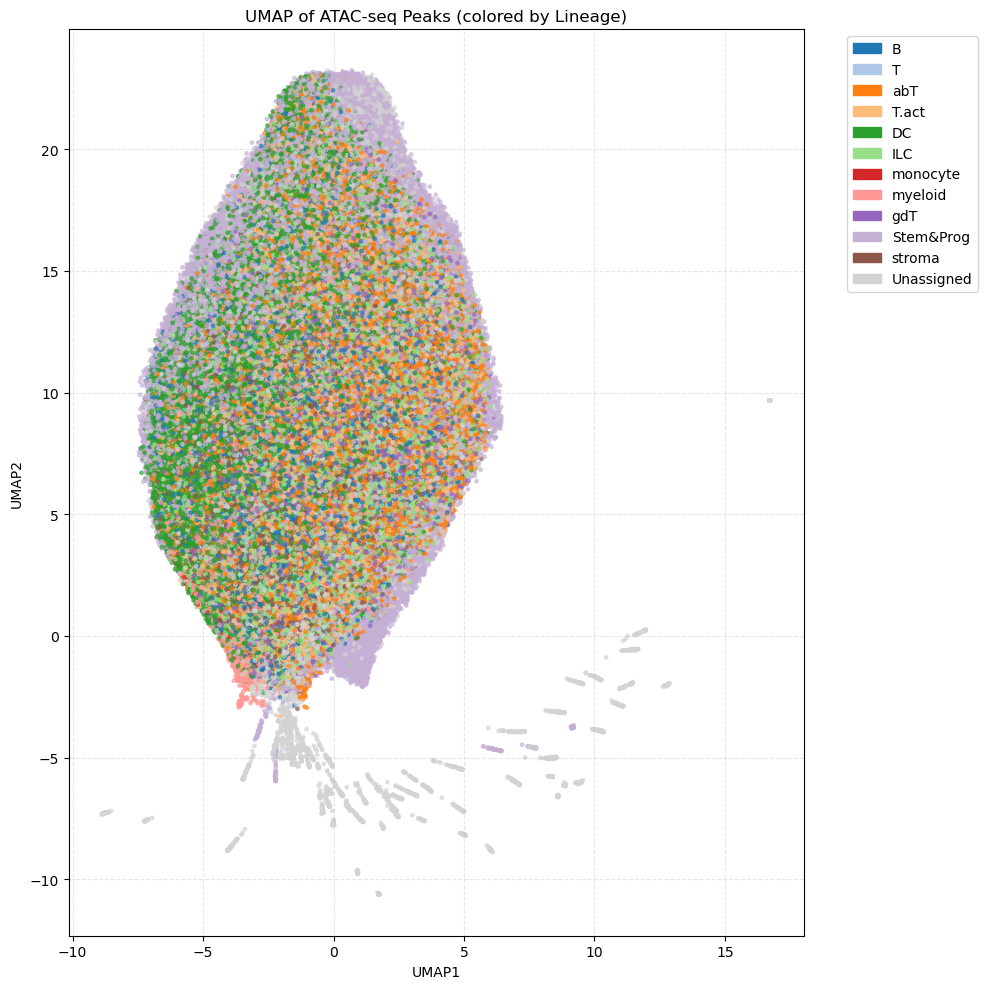

In [97]:
# UMAP ATAC peaks
QC = pd.read_csv("data/ATAC_QCmatric.csv", sep=";")
QC.columns = QC.columns.str.strip()
QC["CellType"] = QC["CellType"].str.strip()
QC["Lineage"] = QC["Lineage"].str.strip()
celltype_to_lineage = QC.drop_duplicates("CellType").set_index("CellType")["Lineage"]

peak_max_celltype = ATAC_scaled.idxmax(axis=1)  # for each peak celltyp with highest peak
peak_lineages = peak_max_celltype.map(celltype_to_lineage).fillna("Unassigned")

peak_colors = peak_lineages.map(lineage_colors)

# PCA
pca = PCA(n_components=30)
X_pca = pca.fit_transform(ATAC_scaled)
# UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.5, spread=2.0, metric='euclidean', random_state=42)
umap_peaks = reducer.fit_transform(X_pca)

plt.figure(figsize=(10, 10))
plt.scatter(umap_peaks[:, 0], umap_peaks[:, 1], c=peak_colors, s=6, alpha=0.6)
handles = [mpatches.Patch(color=color, label=label) for label, color in lineage_colors.items()]
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.title("UMAP of ATAC-seq Peaks (colored by Lineage)")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.savefig("figures/UMAP_ATAC_peaks_zoomed.png", dpi=300, bbox_inches="tight")
plt.show()


/opt/miniconda3/envs/envBCells1/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


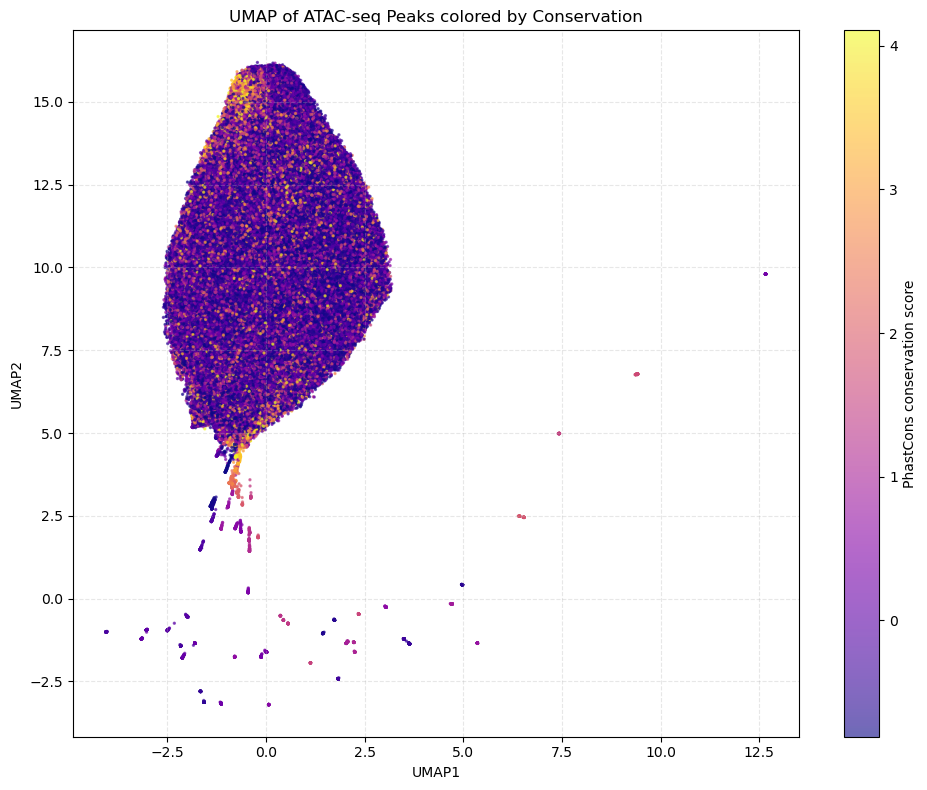

In [98]:
# UMAP colored by conservation

pca = PCA(n_components=30)
X_pca = pca.fit_transform(ATAC_scaled)

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="euclidean", random_state=42)
umap_peaks = reducer.fit_transform(X_pca)

conservation = ATAC_scaled["mm10.60way.phastCons_scores"]


plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    umap_peaks[:, 0],
    umap_peaks[:, 1],
    c=conservation,
    cmap="plasma",        
    s=2,
    alpha=0.6
)
plt.colorbar(scatter, label="PhastCons conservation score")
plt.title("UMAP of ATAC-seq Peaks colored by Conservation")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.savefig("figures/UMAP_ATAC_conservation.png", dpi=300, bbox_inches="tight")
plt.show()

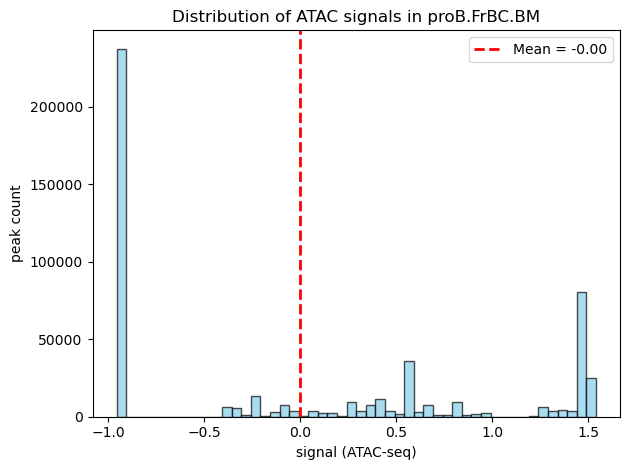

In [99]:
# select column – z. B. for examole cell type "proB.FrBC.BM"
values = ATAC_scaled["proB.FrBC.BM"].dropna()

# calculate mean
mean_val = values.mean()

# Histogram with mean line
plt.hist(values, bins=50, color="skyblue", edgecolor="black", alpha=0.7)
plt.axvline(mean_val, color="red", linestyle="dashed", linewidth=2, label=f"Mean = {mean_val:.2f}")
plt.xlabel("signal (ATAC-seq)")
plt.ylabel("peak count")
plt.title("Distribution of ATAC signals in proB.FrBC.BM")
plt.legend()
plt.tight_layout()
plt.show()

### Distribution of average peak signals in B cells - Histogram

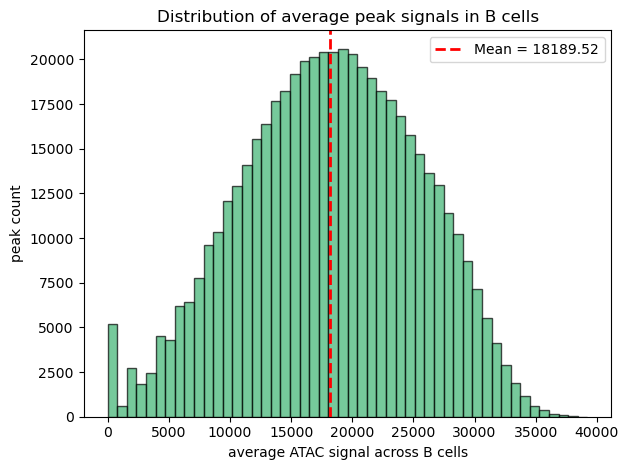

In [100]:
# matrix with ATAC-Seq peaks of B-cells
signal_columns = ATAC_included_values.columns[2:25] 

# mean across columns of B-cells (per row)
ATAC_included_values["peak_mean_signal"] = ATAC_included_values[signal_columns].mean(axis=1)

# Histogramm des Mittelwerts aller Peaks
plt.hist(ATAC_included_values["peak_mean_signal"].dropna(), bins=50, color="mediumseagreen", edgecolor="black", alpha=0.7)
plt.axvline(ATAC_included_values["peak_mean_signal"].mean(), color="red", linestyle="dashed", linewidth=2, label=f"Mean = {ATAC_included_values['peak_mean_signal'].mean():.2f}")
plt.xlabel("average ATAC signal across B cells")
plt.ylabel("peak count")
plt.title("Distribution of average peak signals in B cells")
plt.legend()
plt.tight_layout()
plt.show()

### Distribution of ATAC-Seq mean values per B-cell specific cell types - Histogram

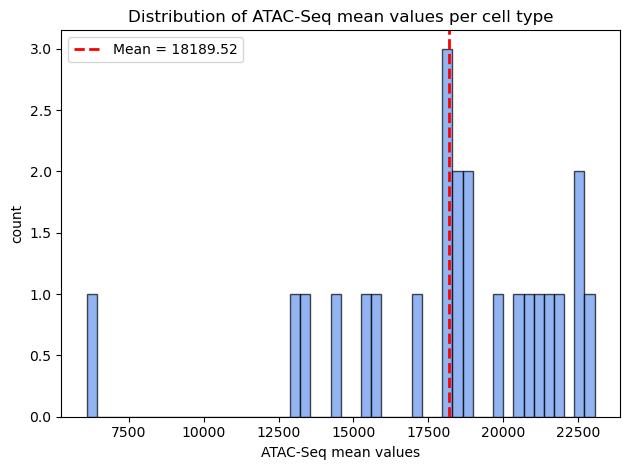

In [101]:

# copy of the B-cell specific transformed matrix
ATAC_T_included_values_Bcells_copy = ATAC_T_included_values_Bcells.copy()

# mean per row across all columns
ATAC_T_included_values_Bcells_copy["row_mean"] = ATAC_T_included_values_Bcells_copy.mean(axis=1)

# Histogramm plotten
plt.hist(ATAC_T_included_values_Bcells_copy["row_mean"].dropna(), bins=50, color="cornflowerblue", edgecolor="black", alpha=0.7)
plt.axvline(ATAC_T_included_values_Bcells_copy["row_mean"].mean(), color="red", linestyle="dashed", linewidth=2, label=f"Mean = {ATAC_T_included_values_Bcells_copy['row_mean'].mean():.2f}")
plt.xlabel("ATAC-Seq mean values")
plt.ylabel("count")
plt.title("Distribution of ATAC-Seq mean values per cell type")
plt.legend()
plt.tight_layout()
plt.show()

### Distribution of ATAC-Seq median values per B-cell specific cell types - Histogram

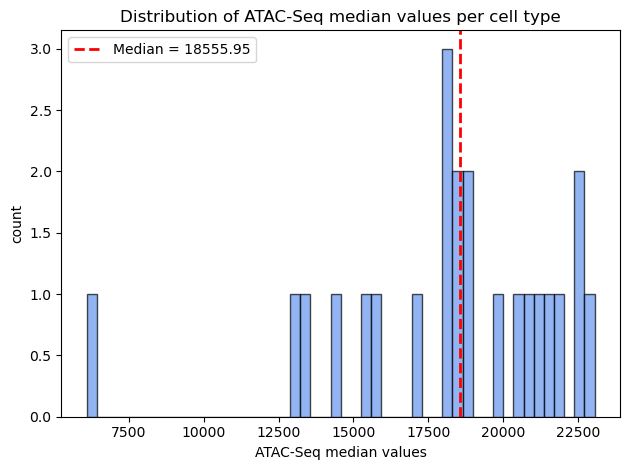

In [102]:

# copy of the B-cell specific transformed matrix
ATAC_T_included_values_Bcells_copy = ATAC_T_included_values_Bcells.copy()

# median per row across all columns
ATAC_T_included_values_Bcells_copy["row_mean"] = ATAC_T_included_values_Bcells_copy.mean(axis=1)

# Histogramm plotten
plt.hist(ATAC_T_included_values_Bcells_copy["row_mean"].dropna(), bins=50, color="cornflowerblue", edgecolor="black", alpha=0.7)
plt.axvline(ATAC_T_included_values_Bcells_copy["row_mean"].median(), color="red", linestyle="dashed", linewidth=2, label=f"Median = {ATAC_T_included_values_Bcells_copy['row_mean'].median():.2f}")
plt.xlabel("ATAC-Seq median values")
plt.ylabel("count")
plt.title("Distribution of ATAC-Seq median values per cell type")
plt.legend()
plt.tight_layout()
plt.show()

### Significance vs. conservation - Scatter plot

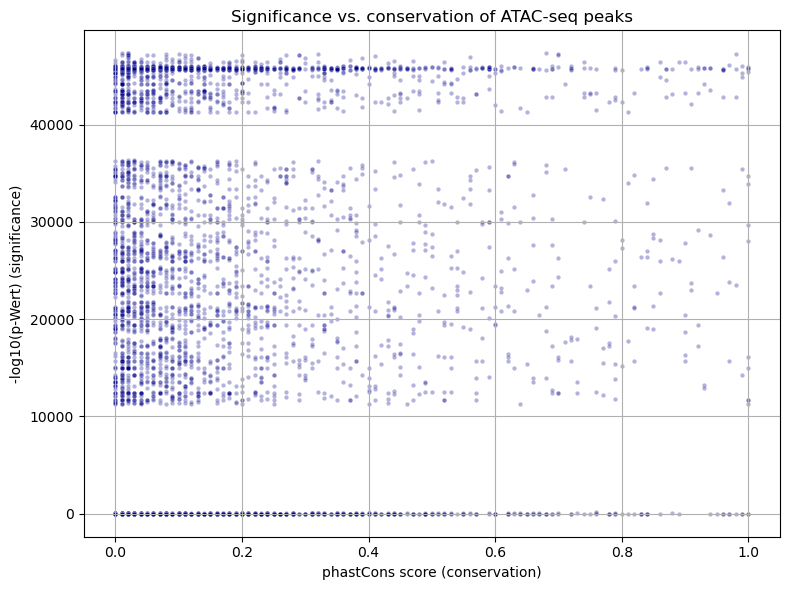

In [103]:
# selection of the two columns

ATAC_filtered = ATAC[["_-log10_bestPvalue", "mm10.60way.phastCons_scores"]].dropna()

# scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=ATAC_filtered.sample(n=5000, random_state=42),  # optional: nur 5000 Punkte für bessere Performance
    x="mm10.60way.phastCons_scores",
    y="_-log10_bestPvalue",
    alpha=0.3,
    s=10,
    color="darkblue"
)
plt.xlabel("phastCons score (conservation)")
plt.ylabel("-log10(p-Wert) (significance)")
plt.title("Significance vs. conservation of ATAC-seq peaks")
plt.grid(True)
plt.tight_layout()
plt.show()


### Hexplots

In [104]:
ATAC_stat = ATAC.copy()

ATAC_values = ATAC.iloc[:, 8:]

# statistics per peak (row)
ATAC_stat['mean_peak'] = ATAC_values.mean(axis=1)
ATAC_stat['median_peak'] = ATAC_values.median(axis=1)
ATAC_stat['var_peak'] = ATAC_values.var(axis=1)
ATAC_stat['std_peak'] = ATAC_values.std(axis=1)
ATAC_stat['min_peak'] = ATAC_values.min(axis=1)
ATAC_stat['max_peak'] = ATAC_values.max(axis=1)

print(ATAC_stat[['mean_peak', 'median_peak', 'var_peak', 'std_peak', 'min_peak', 'max_peak']].head())


      mean_peak  median_peak      var_peak      std_peak  min_peak  max_peak
0  13052.647444        0.710  3.426848e+08  18511.748389       0.1   46447.0
1   9903.710333        0.765  2.801933e+08  16738.976521       0.1   47119.0
2   7668.146222        0.495  2.310778e+08  15201.244929       0.1   46935.0
3   9244.615333        0.530  2.836228e+08  16841.105778       0.1   46753.0
4  11146.956333        0.630  2.898760e+08  17025.746353       0.1   47119.0


In [105]:
ATAC_stat.head()

ImmGenATAC1219.peakID chrom   Summit  mm10.60way.phastCons_scores  \
0  ImmGenATAC1219.peak_1  chr1  3020786                         0.00   
1  ImmGenATAC1219.peak_2  chr1  3087226                         0.00   
2  ImmGenATAC1219.peak_3  chr1  3120109                         0.07   
3  ImmGenATAC1219.peak_4  chr1  3121485                         0.15   
4  ImmGenATAC1219.peak_5  chr1  3372787                         0.03   

   _-log10_bestPvalue  Included.in.systematic.analysis  TSS  \
0                0.56                              NaN  NaN   
1                0.50                              NaN  NaN   
2            45879.00                              1.0  NaN   
3            45691.00                              1.0  NaN   
4            11324.00                              NaN  NaN   

  genes.within.100Kb  LTHSC.34-.BM  LTHSC.34+.BM  ...   IAP.SLN   BEC.SLN  \
0                NaN          0.41          0.71  ...      0.10      0.57   
1                NaN          0.41      23377.00  ...      0.98  42401.00   
2                NaN      13181.00          0.10  ...  33817.00  12055.00   
3                NaN          0.41          0.10  ...      0.98  46753.00   
4                NaN          0.41          0.10  ...      0.75  12055.00   

   LEC.SLN  Ep.MEChi.Th     mean_peak  median_peak      var_peak  \
0  46447.0     14977.00  13052.647444        0.710  3.426848e+08   
1  12451.0         0.94   9903.710333        0.765  2.801933e+08   
2  45748.0         0.11   7668.146222        0.495  2.310778e+08   
3  45748.0         0.11   9244.615333        0.530  2.836228e+08   
4  22282.0     45781.00  11146.956333        0.630  2.898760e+08   

       std_peak  min_peak  max_peak  
0  18511.748389       0.1   46447.0  
1  16738.976521       0.1   47119.0  
2  15201.244929       0.1   46935.0  
3  16841.105778       0.1   46753.0  
4  17025.746353       0.1   47119.0  

[5 rows x 104 columns]

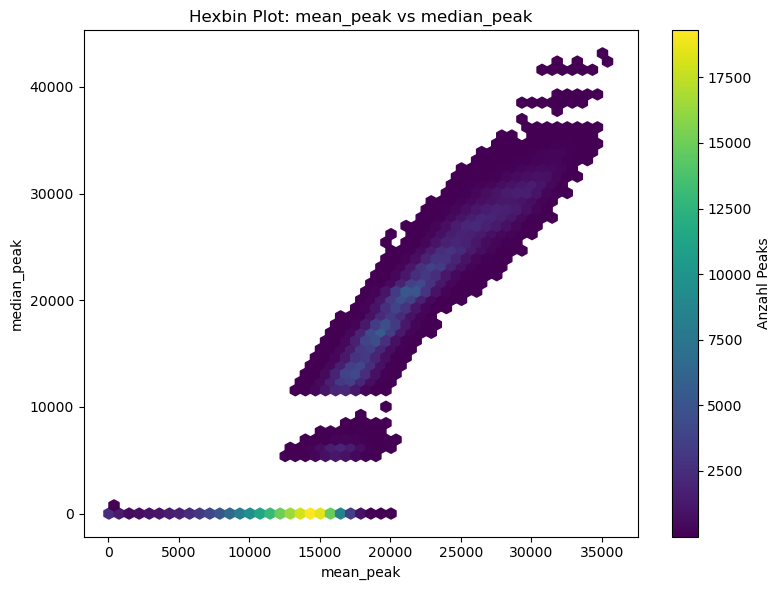

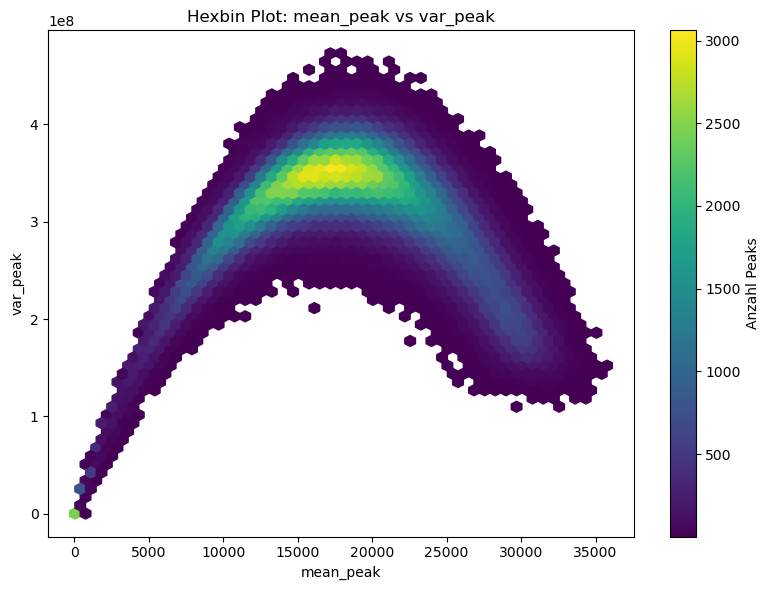

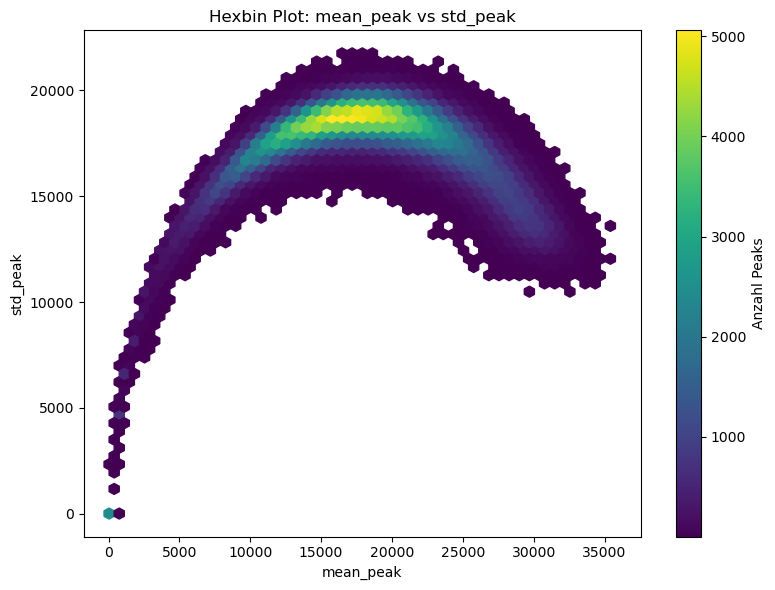

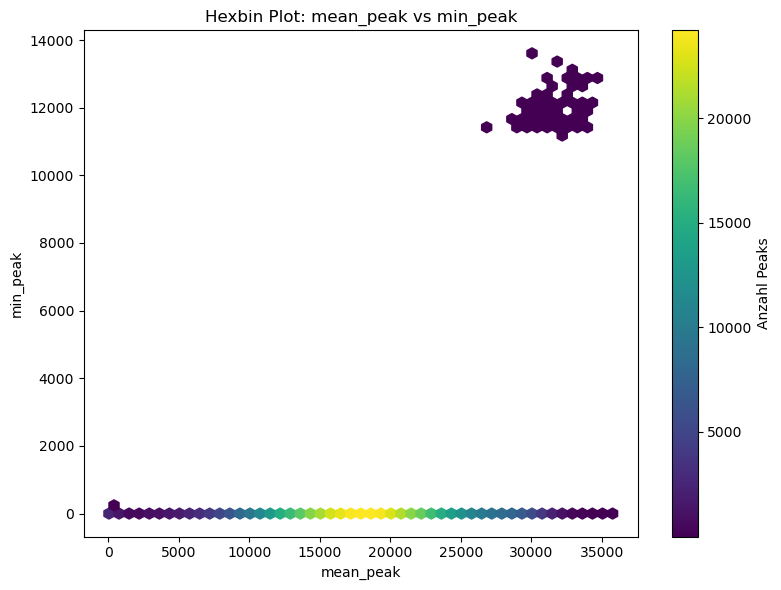

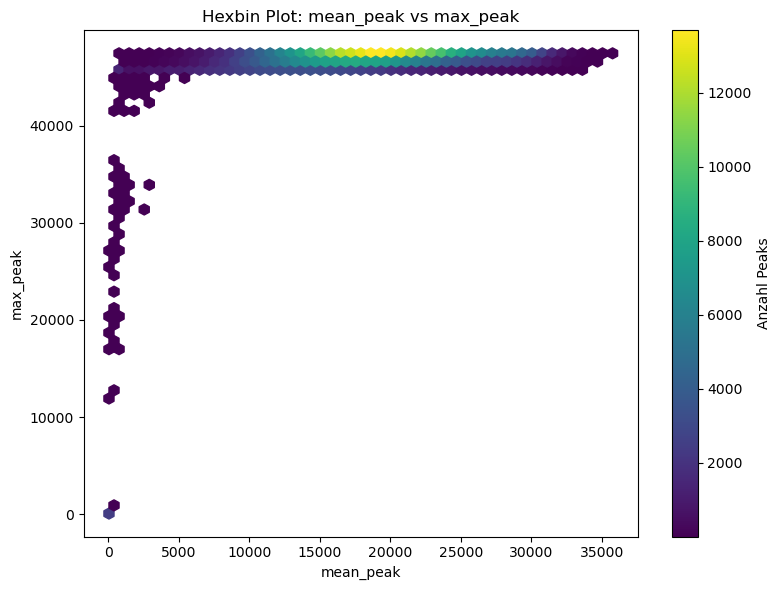

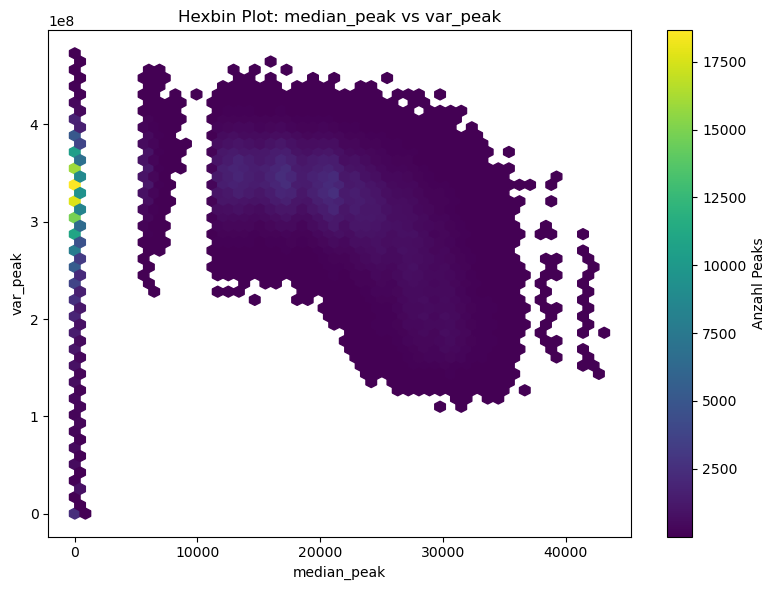

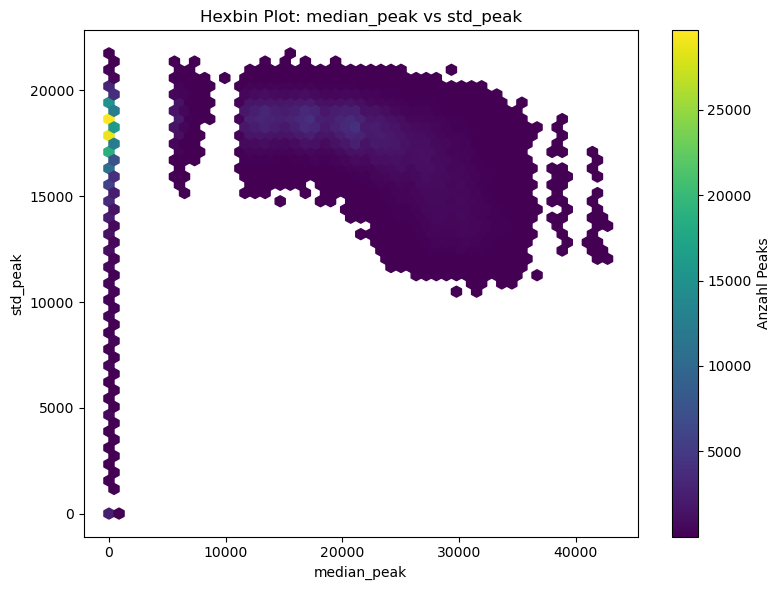

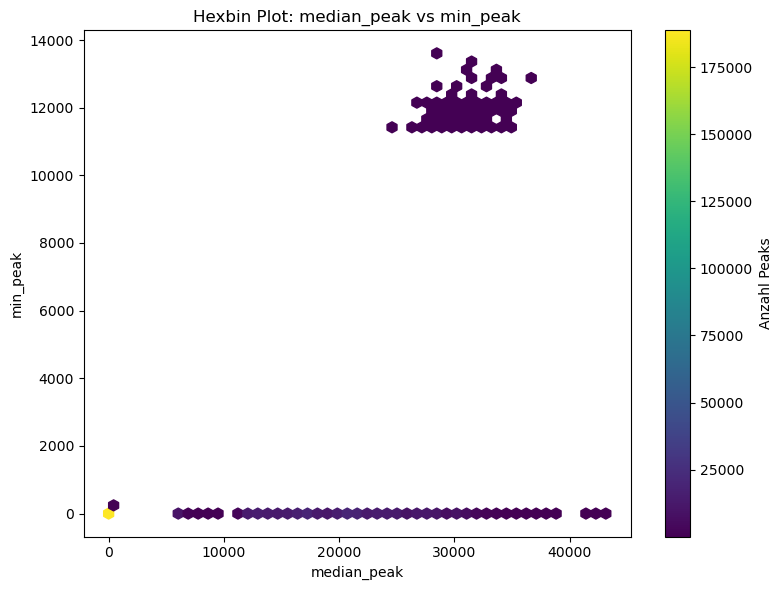

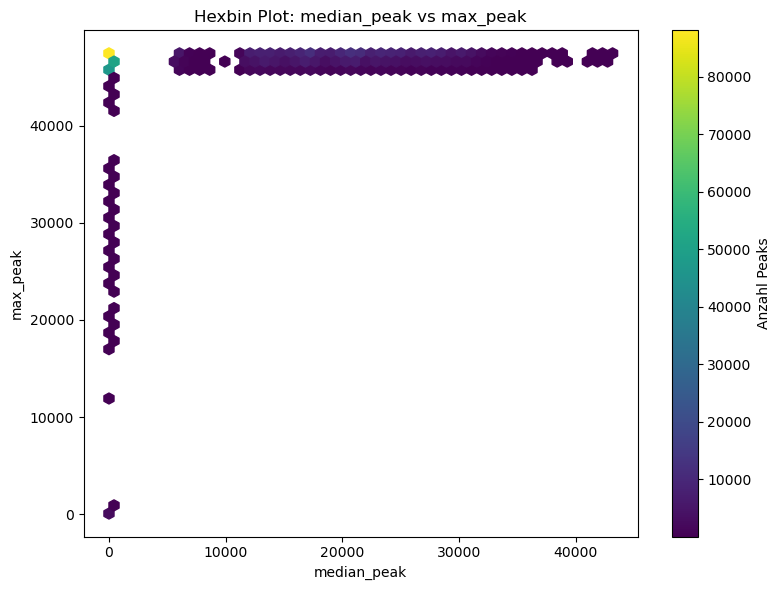

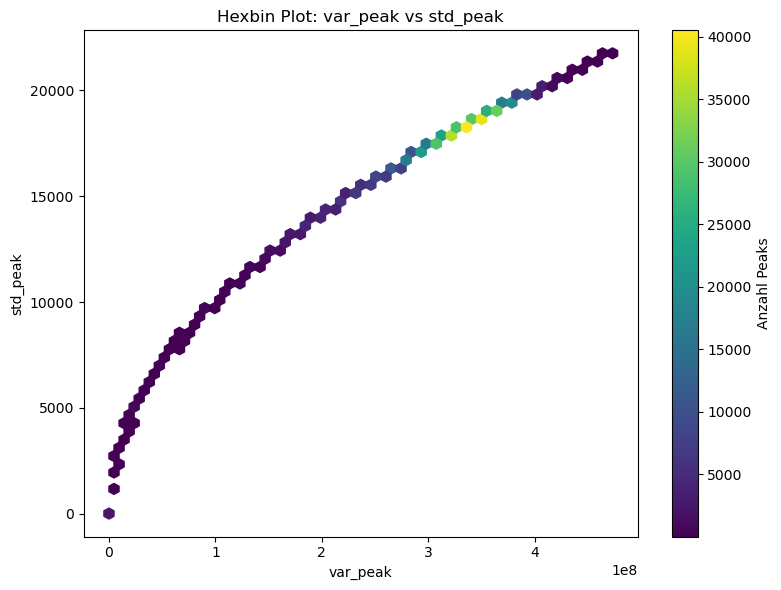

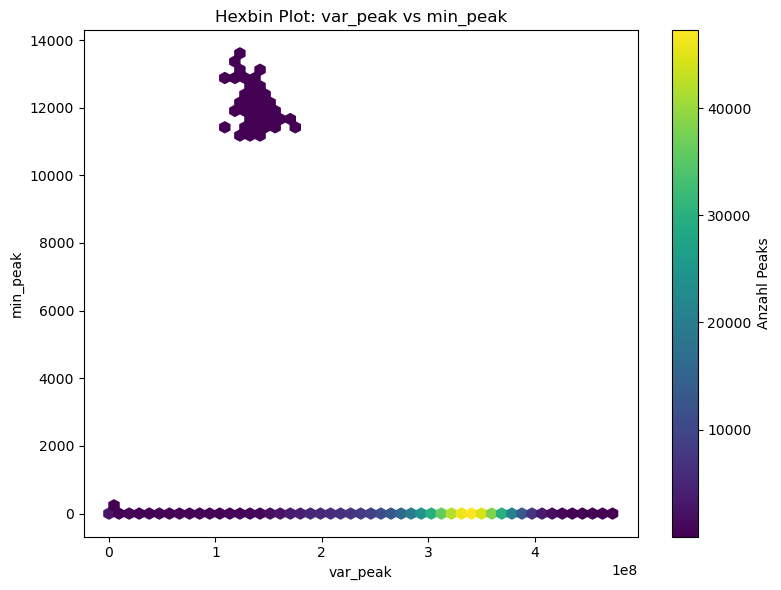

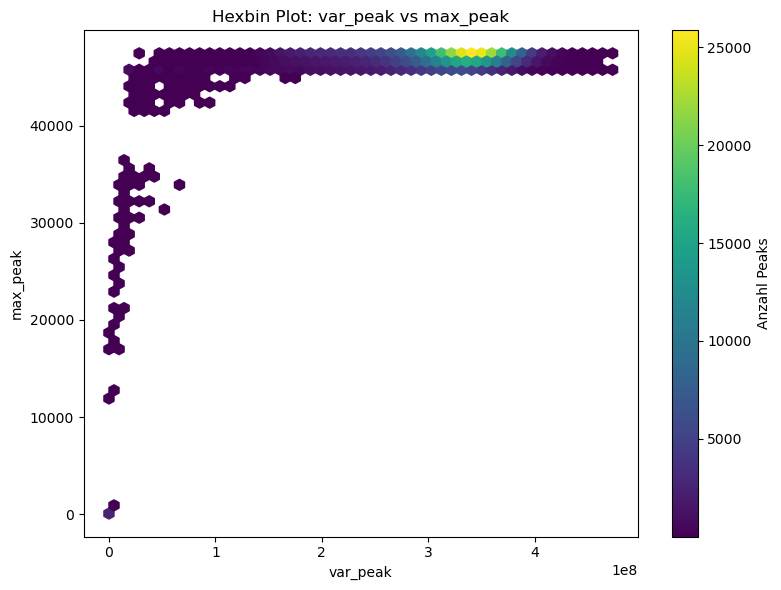

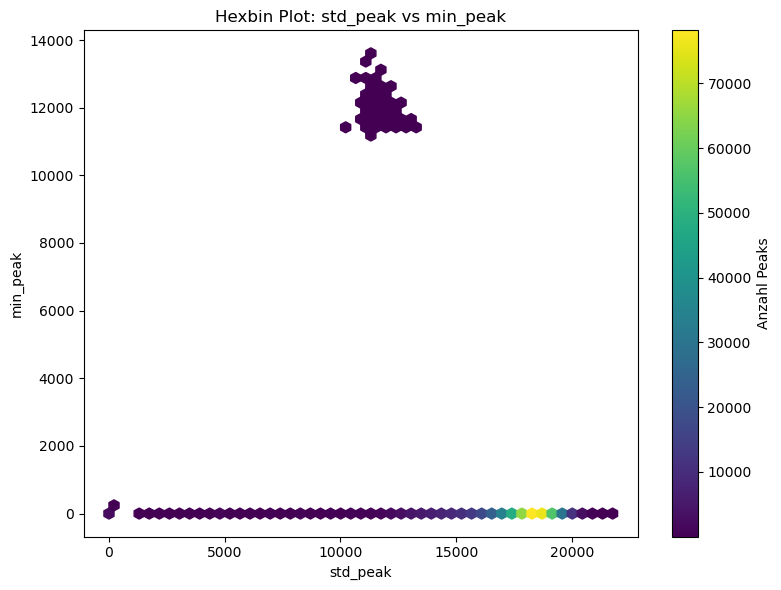

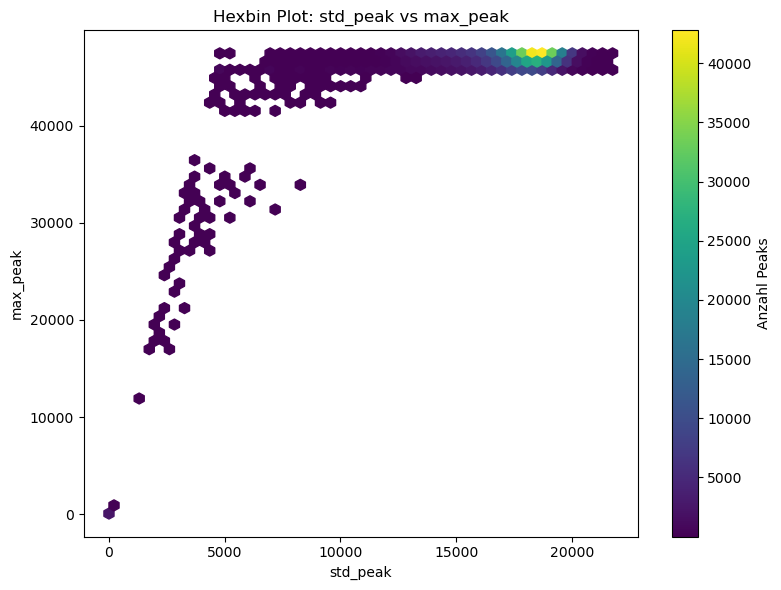

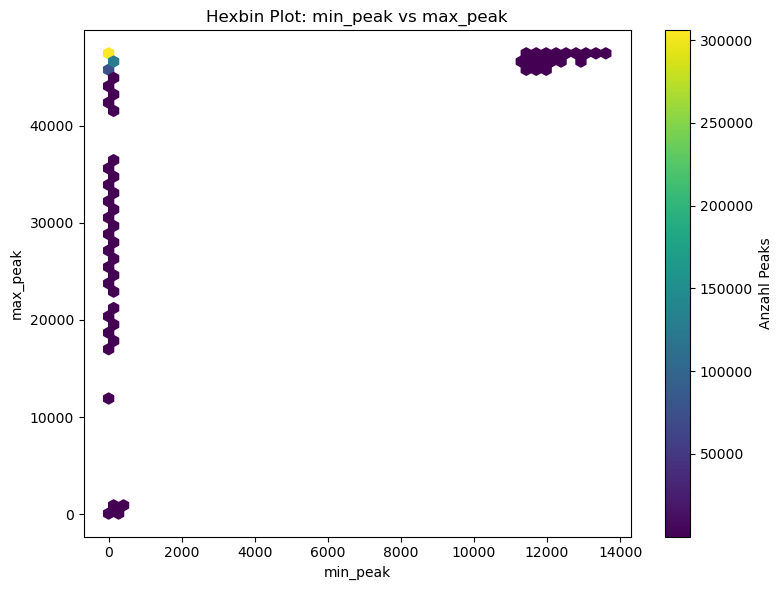

In [106]:
from itertools import combinations

# Liste der Statistik-Spalten
stat_cols = ['mean_peak', 'median_peak', 'var_peak', 'std_peak', 'min_peak', 'max_peak']

# Erstelle Hex-Plots für jede 2er-Kombination
for x_col, y_col in combinations(stat_cols, 2):
    plt.figure(figsize=(8, 6))
    plt.hexbin(ATAC_stat[x_col], ATAC_stat[y_col], gridsize=50, cmap='viridis', mincnt=1)
    plt.colorbar(label='Anzahl Peaks')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f'Hexbin Plot: {x_col} vs {y_col}')
    plt.tight_layout()
    plt.show()


# 1. Differences and similarities of the chromatin landscape between immune cells

## i. How variable is the chromatin signal within cells?

### a) Is the signal dependent on sequencing depth, number of input cells, QC metric?

For that we first calculated the mean signal for all peaks per cell type.
Afterwards we linked the QC data with the signal. A scatterplot shows the Signal vs.different aspects. Then we calculated the correlation and visualized it. 

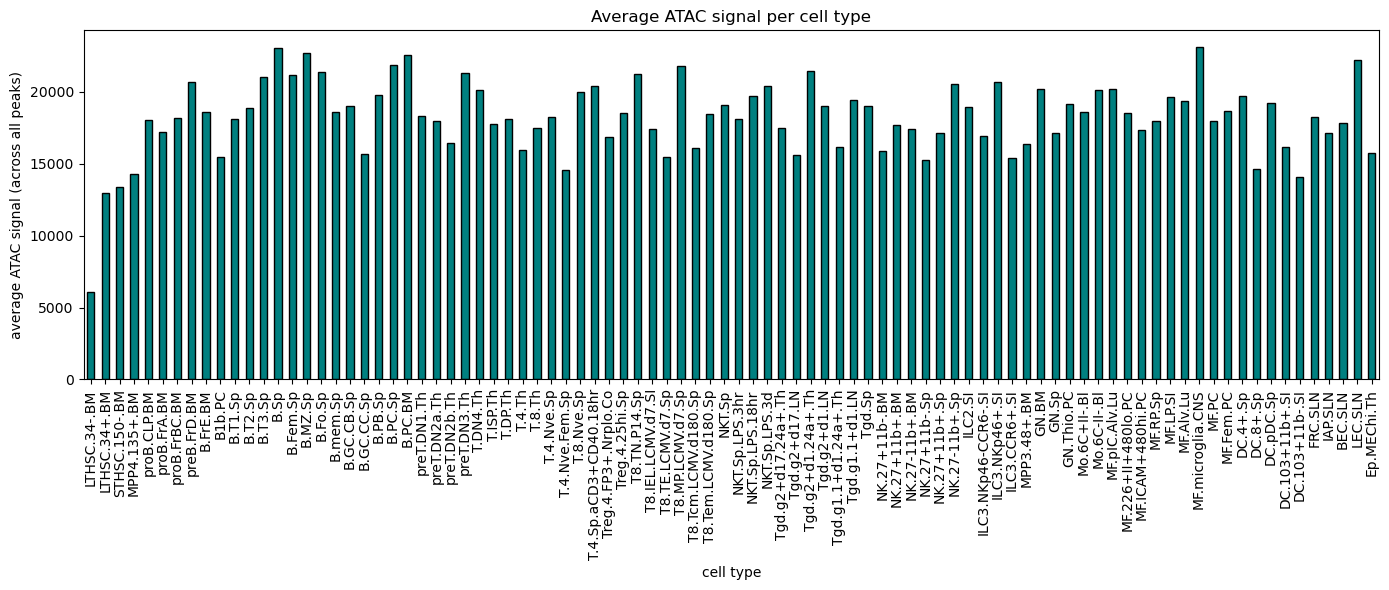

In [107]:
# matrix with all cell types and corresponding ATAC-seq peaks
celltype_columns = ATAC_scaled.columns[2:92] 

# mean per cell type (across all peaks)
celltype_means = ATAC[celltype_columns].mean()

# plot
plt.figure(figsize=(14, 6))
celltype_means.plot(kind="bar", color="teal", edgecolor="black")
plt.ylabel("average ATAC signal (across all peaks)")
plt.xlabel("cell type")
plt.title("Average ATAC signal per cell type")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



In [108]:
# load the converted QC matric 
QC_conv_num = pd.read_csv("data/QC_converted_numerical.CSV")
QC_conv_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Data columns (total 7 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   CellType                                    181 non-null    object 
 1   InputCellNumber                             181 non-null    int64  
 2   PF.reads                                    181 non-null    int64  
 3   %chrM.mapped                                181 non-null    float64
 4   Paired.read.after.removing.PCR.duplication  181 non-null    int64  
 5   %fragment.1Kb_TSS                           181 non-null    float64
 6   Replicate.cor                               176 non-null    float64
dtypes: float64(3), int64(3), object(1)
memory usage: 10.0+ KB


In [109]:
#stats per celltype 

celltype_columns = ATAC.columns[8:]  

ATAC_stats_per_celltype = pd.DataFrame({
    'ATAC_mean':   ATAC[celltype_columns].mean(axis=0),
    'ATAC_median': ATAC[celltype_columns].median(axis=0),
    'ATAC_std':    ATAC[celltype_columns].std(axis=0),
    'ATAC_var':    ATAC[celltype_columns].var(axis=0),
    'ATAC_min':    ATAC[celltype_columns].min(axis=0),
    'ATAC_max':    ATAC[celltype_columns].max(axis=0)})


ATAC_stats_per_celltype = ATAC_stats_per_celltype.reset_index().rename(columns={'index': 'CellType'})

In [110]:
# merge
QC_stats = pd.merge(QC_conv_num, ATAC_stats_per_celltype, on='CellType', how='inner')

print(QC_stats.head())



        CellType  InputCellNumber  PF.reads  %chrM.mapped  \
0   LTHSC.34-.BM              677  22287984          4.58   
1   LTHSC.34+.BM             2483  28588536          3.17   
2  STHSC.150-.BM             3660  22170346          3.25   
3   MPP4.135+.BM            10000  24003590         13.83   
4    proB.CLP.BM            10000  23578208          7.67   

   Paired.read.after.removing.PCR.duplication  %fragment.1Kb_TSS  \
0                                     2470102              10.60   
1                                     7675501               7.70   
2                                     6060045              11.13   
3                                     6128252              18.96   
4                                     6588564              13.21   

   Replicate.cor     ATAC_mean  ATAC_median      ATAC_std      ATAC_var  \
0            NaN   6095.046919         0.41   9788.773579  9.582009e+07   
1            NaN  12936.332385        73.77  14163.202535  2.005963e+08   

In [111]:
QC_stats.head()

CellType  InputCellNumber  PF.reads  %chrM.mapped  \
0   LTHSC.34-.BM              677  22287984          4.58   
1   LTHSC.34+.BM             2483  28588536          3.17   
2  STHSC.150-.BM             3660  22170346          3.25   
3   MPP4.135+.BM            10000  24003590         13.83   
4    proB.CLP.BM            10000  23578208          7.67   

   Paired.read.after.removing.PCR.duplication  %fragment.1Kb_TSS  \
0                                     2470102              10.60   
1                                     7675501               7.70   
2                                     6060045              11.13   
3                                     6128252              18.96   
4                                     6588564              13.21   

   Replicate.cor     ATAC_mean  ATAC_median      ATAC_std      ATAC_var  \
0            NaN   6095.046919         0.41   9788.773579  9.582009e+07   
1            NaN  12936.332385        73.77  14163.202535  2.005963e+08   
2            NaN  13396.369554         0.90  16375.735345  2.681647e+08   
3            NaN  14257.896763        27.81  16906.870910  2.858423e+08   
4          0.868  18034.640712     16011.00  18783.480143  3.528191e+08   

   ATAC_min  ATAC_max  
0      0.41   46017.0  
1      0.10   46296.0  
2      0.11   46296.0  
3      0.11   46508.0  
4      0.11   47453.0

In [112]:
#löschen
#ATAC means into data frame
ATAC_mean_df = celltype_means.reset_index()
ATAC_mean_df.columns = ['CellType', 'ATAC_mean']

#group QC/ 
QC_mean = QC_conv_num.groupby("CellType").mean()

#link mean values with the QC data
ATAC_combined = pd.merge(ATAC_mean_df, QC_mean, on='CellType')
ATAC_combined = ATAC_combined.rename(columns={0: "ATAC_mean"})

ATAC_combined.head()

#mean of ATAC-peaks 
signal_cols = ATAC.select_dtypes(include=["float64", "int64"]).columns

ATAC["mean_signal"] = ATAC[signal_cols].mean(axis=1)

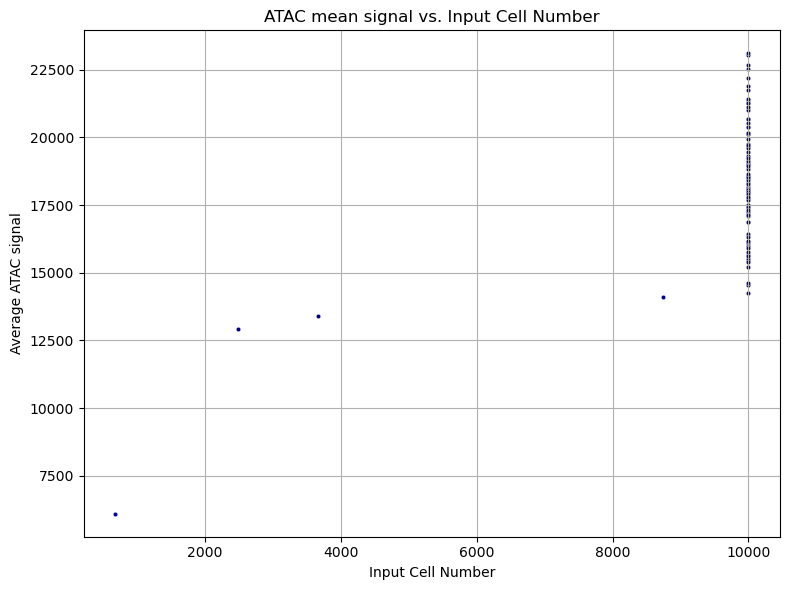

In [113]:
#scatterplot of ATAC-Signal vs. Input Cell number
plt.figure(figsize=(8, 6))
sns.scatterplot(data=ATAC_combined, x="InputCellNumber", y="ATAC_mean", alpha=1.0, s=10, color="darkblue")

plt.xlabel("Input Cell Number")
plt.ylabel("Average ATAC signal")
plt.title("ATAC mean signal vs. Input Cell Number")
plt.grid(True)
plt.tight_layout()
plt.show()

In [114]:
# does input cell number really just contain 10.000?
ATAC_combined["InputCellNumber"].value_counts()

InputCellNumber
10000.0    85
677.0       1
2483.0      1
3660.0      1
8750.0      1
Name: count, dtype: int64

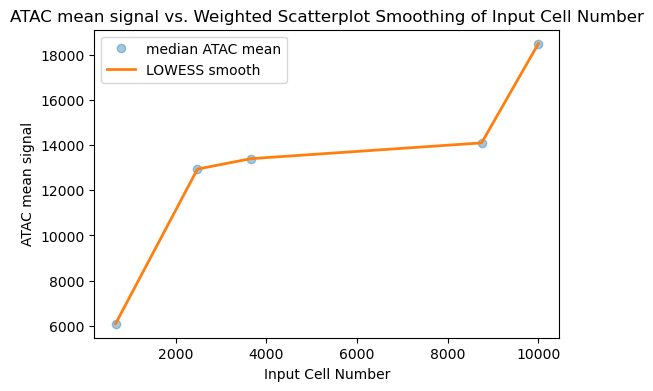

In [115]:
aggregated_data = ATAC_combined.groupby("InputCellNumber").ATAC_mean.agg(["median","count"])

lowess = sm.nonparametric.lowess
aggregated_data["sm"] = lowess(aggregated_data["median"], aggregated_data.index, frac=0.4)[:,1]

# Make sure your index is sorted
aggregated_data = aggregated_data.sort_index()

# Plot the raw medians and the LOWESS smooth
plt.figure(figsize=(6,4))
plt.plot(aggregated_data.index, aggregated_data["median"], "o", alpha=0.4, label="median ATAC mean")
plt.plot(aggregated_data.index, aggregated_data["sm"], "-", lw=2, label="LOWESS smooth")
plt.title("ATAC mean signal vs. Weighted Scatterplot Smoothing of Input Cell Number")
plt.xlabel("Input Cell Number")
plt.ylabel("ATAC mean signal")
plt.legend()
plt.show()

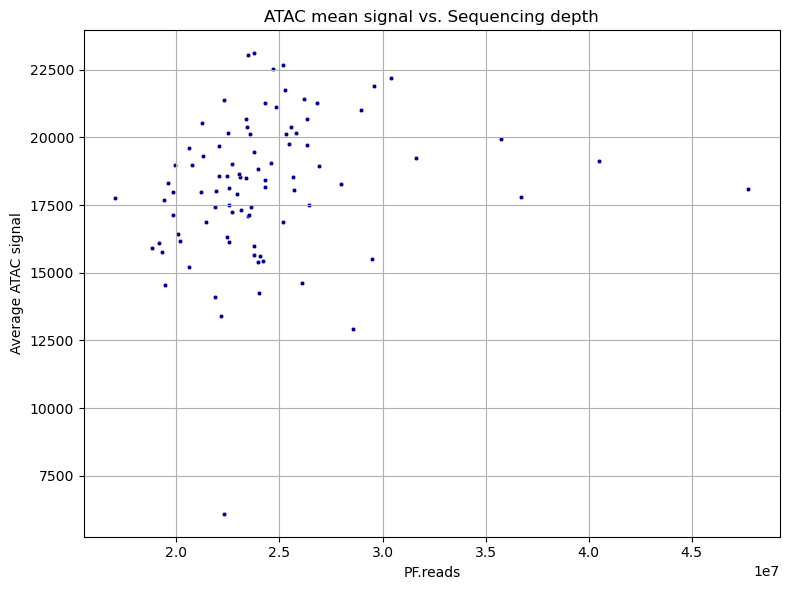

In [116]:
#scatterplot of ATAC-Signal vs. Sequencing depth
plt.figure(figsize=(8, 6))
sns.scatterplot(data=ATAC_combined, x="PF.reads", y="ATAC_mean", alpha=1.0, s=10, color="darkblue")

plt.xlabel("PF.reads")
plt.ylabel("Average ATAC signal")
plt.title("ATAC mean signal vs. Sequencing depth")
plt.grid(True)
plt.tight_layout()
plt.show()

#says how many reads there are -> more mean better information 
# do you only look at strongly open parts (low sequencing depth) or also at weakly open parts (high depth)

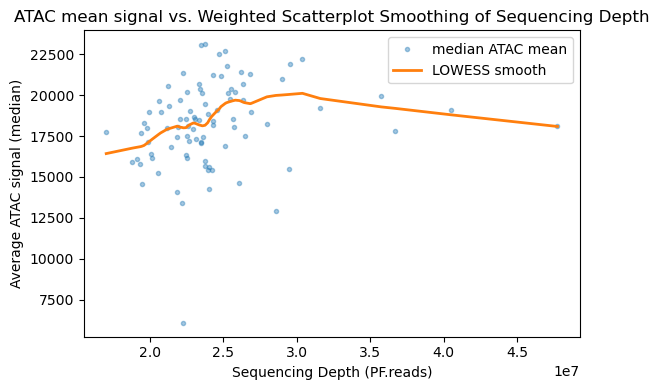

In [117]:
aggregated_data_depth = ATAC_combined.groupby("PF.reads").ATAC_mean.agg(["median", "count"])

# 1) Extract x & y as simple NumPy arrays
x = aggregated_data_depth.index.values
y = aggregated_data_depth["median"].values

# 2) Run LOWESS — this returns an array of shape (m,2), where m ≤ len(x)
smoothed = lowess(y, x, frac=0.4)

# 3) Turn that into a Series whose index is the sorted x’s
sm_series = pd.Series(
    data=smoothed[:,1],
    index=smoothed[:,0]
)

# 4) Re‐index it onto your DataFrame’s full index (fills missing with NaN)
aggregated_data_depth["sm"] = sm_series.reindex(aggregated_data_depth.index)

plt.figure(figsize=(6,4))
plt.plot(aggregated_data_depth.index, aggregated_data_depth["median"], ".", alpha=0.4, label="median ATAC mean")    
plt.plot(aggregated_data_depth.index, aggregated_data_depth["sm"], "-", lw=2, label="LOWESS smooth")
plt.title("ATAC mean signal vs. Weighted Scatterplot Smoothing of Sequencing Depth")
plt.xlabel("Sequencing Depth (PF.reads)")
plt.ylabel("Average ATAC signal (median)")
plt.legend()
plt.tight_layout()
plt.show()

# there is an upward trend in for few reads, which plateaus at around 25,000,000 reads

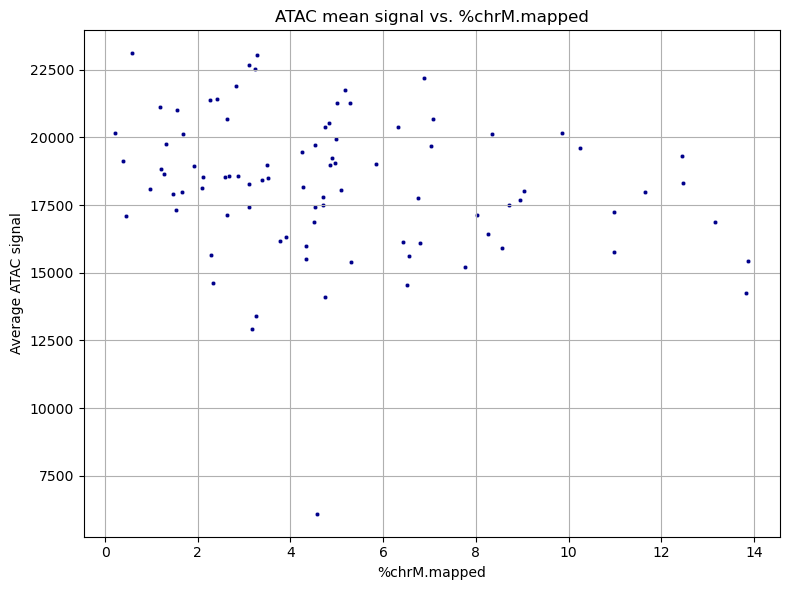

In [118]:
#scatterplot of ATAC-Signal vs. %chrM.mapped
plt.figure(figsize=(8, 6))
sns.scatterplot(data=ATAC_combined, x="%chrM.mapped", y="ATAC_mean", alpha=1.0, s=10, color="darkblue")

plt.xlabel("%chrM.mapped")
plt.ylabel("Average ATAC signal")
plt.title("ATAC mean signal vs. %chrM.mapped")
plt.grid(True)
plt.tight_layout()
plt.show()

#how many reads are from mitochondria (not useful)

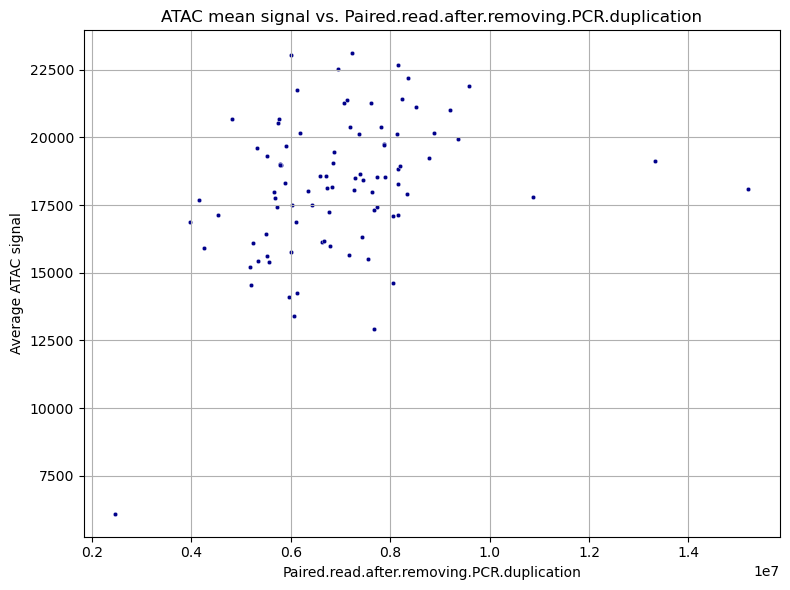

In [119]:
#scatterplot of ATAC-Signal vs. Paired.read.after.removing.PCR.duplication
plt.figure(figsize=(8, 6))
sns.scatterplot(data=ATAC_combined, x="Paired.read.after.removing.PCR.duplication", y="ATAC_mean", alpha=1.0, s=10, color="darkblue")

plt.xlabel("Paired.read.after.removing.PCR.duplication")
plt.ylabel("Average ATAC signal")
plt.title("ATAC mean signal vs. Paired.read.after.removing.PCR.duplication")
plt.grid(True)
plt.tight_layout()
plt.show()

#how many unique reads after removing duplications 

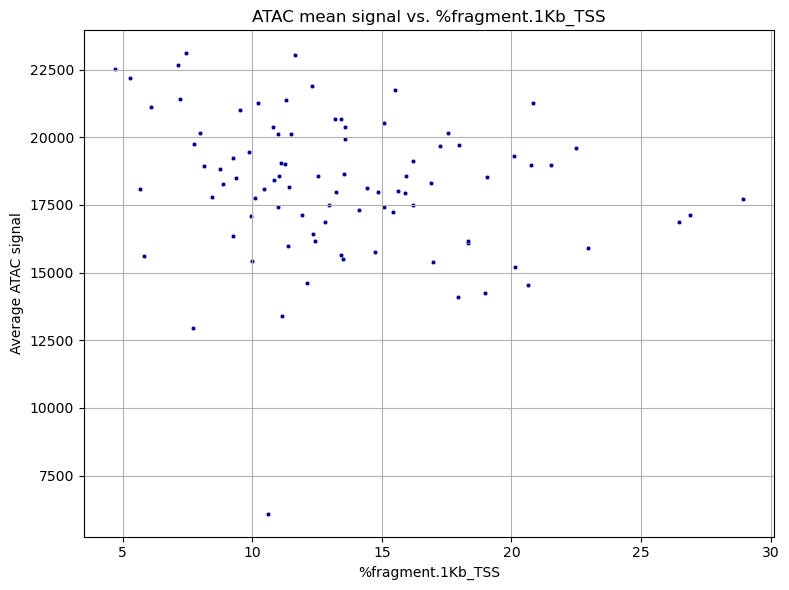

In [120]:
#scatterplot of ATAC-Signal vs. %fragment.1Kb_TSS
plt.figure(figsize=(8, 6))
sns.scatterplot(data=ATAC_combined, x="%fragment.1Kb_TSS", y="ATAC_mean", alpha=1.0, s=10, color="darkblue")

plt.xlabel("%fragment.1Kb_TSS")
plt.ylabel("Average ATAC signal")
plt.title("ATAC mean signal vs. %fragment.1Kb_TSS")
plt.grid(True)
plt.tight_layout()
plt.show()

#how many reads are close to start of gene

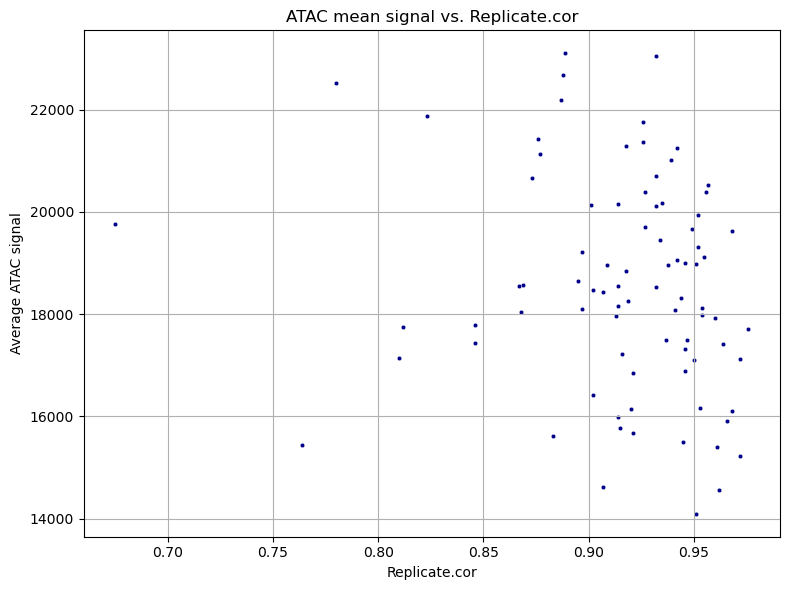

In [121]:
#scatterplot of ATAC-Signal vs. Replicate.cor
plt.figure(figsize=(8, 6))
sns.scatterplot(data=ATAC_combined, x="Replicate.cor", y="ATAC_mean", alpha=1.0, s=10, color="darkblue")

plt.xlabel("Replicate.cor")
plt.ylabel("Average ATAC signal")
plt.title("ATAC mean signal vs. Replicate.cor")
plt.grid(True)
plt.tight_layout()
plt.show()

#how similar was the experiment when doing it multiple times 

In [122]:
ATAC_combined.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 8 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   CellType                                    89 non-null     object 
 1   ATAC_mean                                   89 non-null     float64
 2   InputCellNumber                             89 non-null     float64
 3   PF.reads                                    89 non-null     float64
 4   %chrM.mapped                                89 non-null     float64
 5   Paired.read.after.removing.PCR.duplication  89 non-null     float64
 6   %fragment.1Kb_TSS                           89 non-null     float64
 7   Replicate.cor                               84 non-null     float64
dtypes: float64(7), object(1)
memory usage: 5.7+ KB


In [123]:
#ATAC combined nur float 
ATAC_combined_num = ATAC_combined.iloc[:, 1:8]
ATAC_combined_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 7 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   ATAC_mean                                   89 non-null     float64
 1   InputCellNumber                             89 non-null     float64
 2   PF.reads                                    89 non-null     float64
 3   %chrM.mapped                                89 non-null     float64
 4   Paired.read.after.removing.PCR.duplication  89 non-null     float64
 5   %fragment.1Kb_TSS                           89 non-null     float64
 6   Replicate.cor                               84 non-null     float64
dtypes: float64(7)
memory usage: 5.0 KB


In [124]:
QC_cols = ['InputCellNumber', 'PF.reads', '%chrM.mapped',
           'Paired.read.after.removing.PCR.duplication',
           '%fragment.1Kb_TSS', 'Replicate.cor']

ATAC_stat_cols = ['ATAC_mean', 'ATAC_median', 'ATAC_std', 'ATAC_var', 'ATAC_min', 'ATAC_max']

corr_matrix = QC_stats[QC_cols + ATAC_stat_cols].corr()

corr_sub = corr_matrix.loc[QC_cols, ATAC_stat_cols]

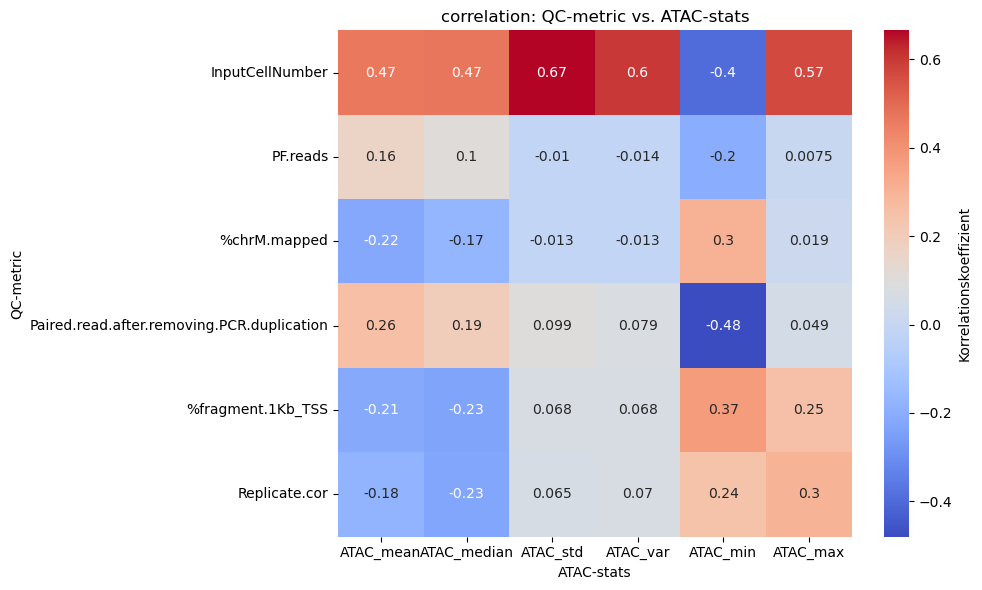

In [125]:
plt.figure(figsize=(10, 6))
sns.heatmap(corr_sub, annot=True, cmap='coolwarm', cbar_kws={'label': 'Korrelationskoeffizient'})
plt.title("correlation: QC-metric vs. ATAC-stats")
plt.xlabel("ATAC-stats")
plt.ylabel("QC-metric")
plt.tight_layout()
plt.show()

### Mean, Median and sd against QC across cell types

In [126]:
# preparing metrices 
celltype_columns = ATAC_scaled.columns[2:92]
celltype_means = ATAC_scaled[celltype_columns].mean()
celltype_medians = ATAC_scaled[celltype_columns].median()
celltype_sds = ATAC_scaled[celltype_columns].std()

#convert to dataframe
mean_df = celltype_means.reset_index()
mean_df.columns = ['CellType', 'ATAC_mean']

median_df = celltype_medians.reset_index()
median_df.columns = ['CellType', 'ATAC_median']

sd_df = celltype_sds.reset_index()
sd_df.columns = ['CellType', 'ATAC_sd']

#combine to one dataframe 
ATAC_stats_df = mean_df.merge(median_df, on='CellType').merge(sd_df, on='CellType')
ATAC_combined = pd.merge(ATAC_stats_df, QC_mean, on='CellType')
ATAC_combined['Replicate.cor'] = ATAC_combined['Replicate.cor'].fillna(0)

ATAC_combined.head()


CellType     ATAC_mean  ATAC_median   ATAC_sd  InputCellNumber  \
0   LTHSC.34-.BM -3.077323e-16    -0.622619  1.000001            677.0   
1   LTHSC.34+.BM  6.387524e-17    -0.908176  1.000001           2483.0   
2  STHSC.150-.BM  7.474290e-17    -0.818014  1.000001           3660.0   
3   MPP4.135+.BM -3.586606e-16    -0.841682  1.000001          10000.0   
4    proB.CLP.BM  1.660645e-16    -0.107744  1.000001          10000.0   

     PF.reads  %chrM.mapped  Paired.read.after.removing.PCR.duplication  \
0  22287984.0         4.580                                   2470102.0   
1  28588536.0         3.170                                   7675501.0   
2  22170346.0         3.250                                   6060045.0   
3  24003590.0        13.830                                   6128252.0   
4  21903414.0         9.035                                   6347376.5   

   %fragment.1Kb_TSS  Replicate.cor  
0             10.600          0.000  
1              7.700          0.000  
2             11.130          0.000  
3             18.960          0.000  
4             15.605          0.868

### b) Should some cell types be removed or normalized?

In [127]:
#ATAC means into data frame
ATAC_mean_df = celltype_means.reset_index()
ATAC_mean_df.columns = ['CellType', 'ATAC_mean']

#group QC/ 
QC_mean = QC_conv_num.groupby("CellType").mean()

#link mean values with the QC data
ATAC_combined = pd.merge(ATAC_mean_df, QC_mean, on='CellType')
ATAC_combined = ATAC_combined.rename(columns={0: "ATAC_mean"})

ATAC_combined.head()


CellType     ATAC_mean  InputCellNumber    PF.reads  %chrM.mapped  \
0   LTHSC.34-.BM -3.077323e-16            677.0  22287984.0         4.580   
1   LTHSC.34+.BM  6.387524e-17           2483.0  28588536.0         3.170   
2  STHSC.150-.BM  7.474290e-17           3660.0  22170346.0         3.250   
3   MPP4.135+.BM -3.586606e-16          10000.0  24003590.0        13.830   
4    proB.CLP.BM  1.660645e-16          10000.0  21903414.0         9.035   

   Paired.read.after.removing.PCR.duplication  %fragment.1Kb_TSS  \
0                                   2470102.0             10.600   
1                                   7675501.0              7.700   
2                                   6060045.0             11.130   
3                                   6128252.0             18.960   
4                                   6347376.5             15.605   

   Replicate.cor  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4          0.868

In [128]:
ATAC_mean_df = celltype_means.reset_index()
ATAC_mean_df.columns = ['CellType', 'ATAC_mean']
ATAC_mean_df.head()

CellType     ATAC_mean
0   LTHSC.34-.BM -3.077323e-16
1   LTHSC.34+.BM  6.387524e-17
2  STHSC.150-.BM  7.474290e-17
3   MPP4.135+.BM -3.586606e-16
4    proB.CLP.BM  1.660645e-16

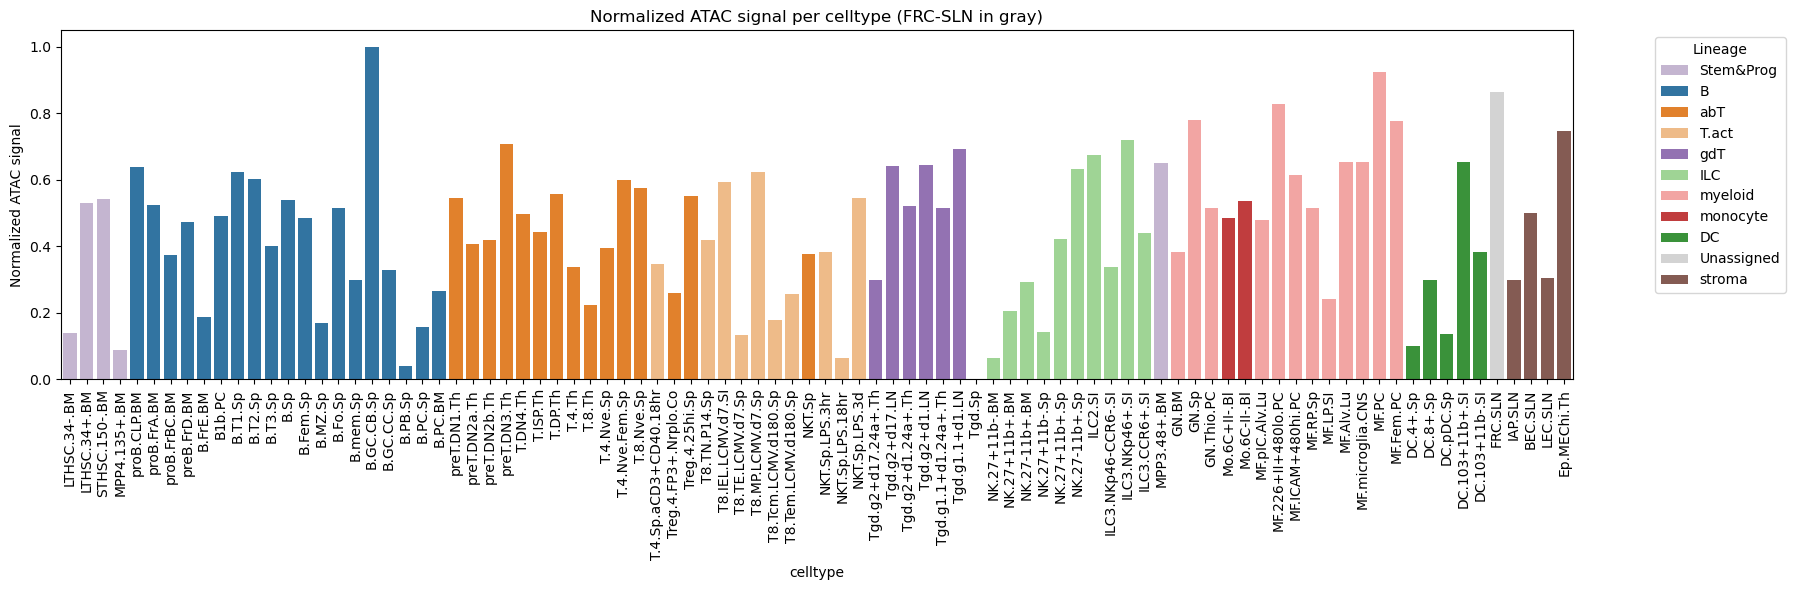

In [129]:
#ATAC means into data frame
ATAC_mean_df = celltype_means.reset_index()
ATAC_mean_df.columns = ['CellType', 'ATAC_mean']

# Min-Max normalization (0–1 scaling)
min_val = ATAC_mean_df["ATAC_mean"].min()
max_val = ATAC_mean_df["ATAC_mean"].max()
ATAC_mean_df["ATAC_mean_norm"] = (ATAC_mean_df["ATAC_mean"] - min_val) / (max_val - min_val)

# specific color for each celltype
QC = pd.read_csv("data/ATAC_QCmatric.csv", sep=";")
QC.columns = QC.columns.str.strip()
QC["CellType"] = QC["CellType"].str.strip()
QC_unique = QC.drop_duplicates(subset="CellType")
ATAC_mean_df["Lineage"] = ATAC_mean_df["CellType"].map(QC_unique.set_index("CellType")["Lineage"])

# color for FRC.SLN (no lineage assigned)
ATAC_mean_df["Lineage"] = ATAC_mean_df["Lineage"].fillna("Unassigned")

#boxplot: ATAC signal for all celltypes
plt.figure(figsize=(18, 6))

sns.barplot(
    data=ATAC_mean_df,
    x="CellType",
    y="ATAC_mean_norm",
    hue="Lineage",
    palette=lineage_colors,
    dodge=False
)
plt.xticks(rotation=90)
plt.title("Normalized ATAC signal per celltype (FRC-SLN in gray)")
plt.ylabel("Normalized ATAC signal")
plt.xlabel("celltype")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Lineage")
plt.tight_layout()
plt.savefig("figures/mean_ATAC_peaks.png", dpi=300, bbox_inches="tight")
plt.show()

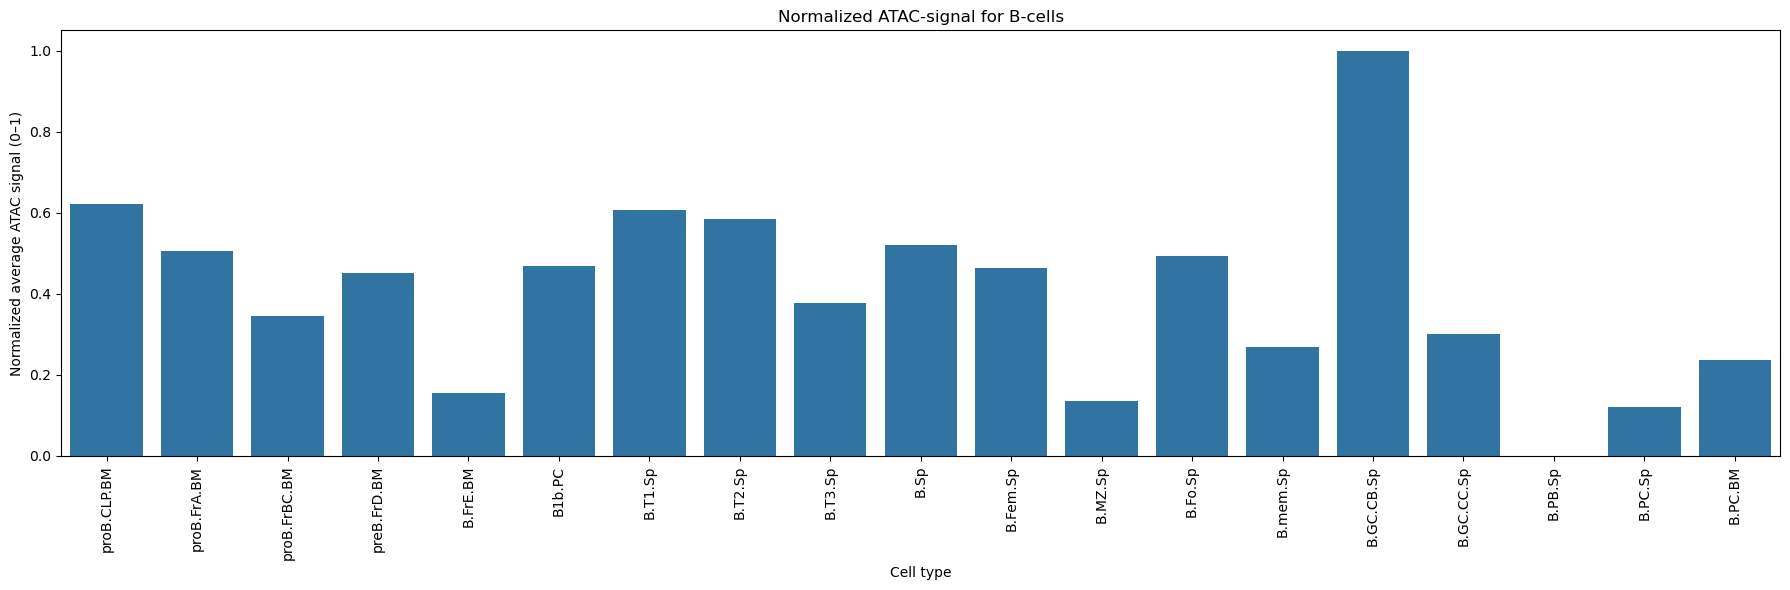

In [130]:
# Load and prepare QC matrix
QC = pd.read_csv("data/ATAC_QCmatric.csv", sep=";")
QC.columns = QC.columns.str.strip()
QC["CellType"] = QC["CellType"].str.strip()
QC["Lineage"] = QC["Lineage"].str.strip()

# Isolate only B-cell types from QC matrix
b_cell_types = QC[QC["Lineage"] == "B"]["CellType"].tolist()

# Isolate only B-cell types from ATAC_mean_df
b_cells = ATAC_mean_df[ATAC_mean_df["CellType"].isin(b_cell_types)].copy()

# Min-Max normalization (0–1 scaling) for B-cells
min_val = b_cells["ATAC_mean"].min()
max_val = b_cells["ATAC_mean"].max()
b_cells["ATAC_mean_norm"] = (b_cells["ATAC_mean"] - min_val) / (max_val - min_val)

# Plot
plt.figure(figsize=(18, 6))

sns.barplot(
    data=b_cells,
    x="CellType",
    y="ATAC_mean_norm",
    color=(0.121569, 0.466667, 0.705882)
)

plt.xticks(rotation=90)
plt.title("Normalized ATAC-signal for B-cells")
plt.ylabel("Normalized average ATAC signal (0–1)")
plt.xlabel("Cell type")
plt.tight_layout()
plt.show()


Celltypes containing a very low signal: LTHSC.34-BM
->should be removed/normalized

### ii. How variable is the chromatin signal for CREs across cells?

c:\Users\annal\miniconda3\envs\envBCells1\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


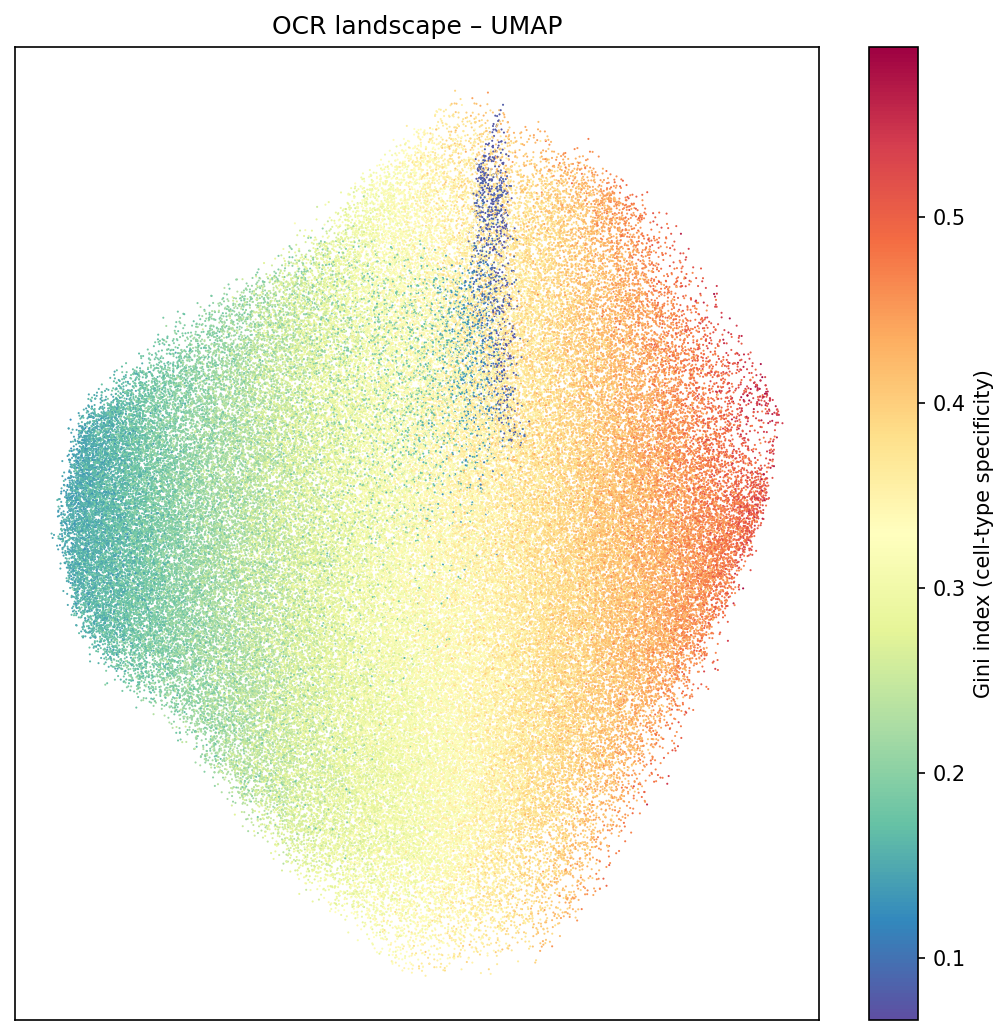

In [16]:
import pathlib, pandas as pd, numpy as np
from sklearn.decomposition import TruncatedSVD
import umap.umap_  as umap                         # ← the fast UMAP
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
ATAC_MATRIX = pathlib.Path(r"data/1.ATAC-Seq data.CSV")   # update if path differs

try:                                                      # fast C-engine first
    mat = pd.read_csv(ATAC_MATRIX, sep=";", index_col=0, low_memory=False)
except pd.errors.ParserError:                             # ragged → Python engine
    mat = pd.read_csv(ATAC_MATRIX, sep=";", index_col=0, engine="python")

# drop dummy col made by trailing ';'
mat = mat.loc[:, ~mat.columns.str.startswith("Unnamed")]
mat = (
    mat.apply(pd.to_numeric, errors="coerce")
       .replace([np.inf, -np.inf], np.nan)
       .fillna(0.0)
       .astype(np.float64) 
)
# Yoshida pre-processing
mat = np.log2(mat + 0.1)            # pseudo-count
mat = (mat.rank(axis=0) / (len(mat) - 1)).astype(np.float32)  # quantile-norm
MAX_PTS = 120_000                    # feel free to raise/lower
if len(mat) > MAX_PTS:
    rng   = np.random.default_rng(0)
    keep  = rng.choice(mat.index, size=MAX_PTS, replace=False)
    mat_s = mat.loc[keep]
else:
    mat_s = mat

def gini(row):
    x = np.sort(row.values)
    i = np.arange(1, x.size + 1)
    return ((2 * i - x.size - 1) * x).sum() / (x.size * x.sum())

gini_scores = mat_s.apply(gini, axis=1)

svd    = TruncatedSVD(n_components=25, random_state=0)
pca_25 = svd.fit_transform(mat_s)

reducer = umap.UMAP(
    n_components=2,
    n_neighbors =30,        # ~ t-SNE perplexity
    min_dist    =0.3,
    metric      ="euclidean",
    random_state=0
)
xy = reducer.fit_transform(pca_25)
fig, ax = plt.subplots(figsize=(7, 7), dpi=150)

norm = Normalize(gini_scores.min(), gini_scores.max())
scat = ax.scatter(
    xy[:, 0], xy[:, 1],
    c=gini_scores,
    cmap="Spectral_r",
    s=1, lw=0
)

ax.set(
    xticks=[],
    yticks=[],
    title="OCR landscape – UMAP"
)
fig.colorbar(scat, ax=ax, label="Gini index (cell-type specificity)")
plt.tight_layout()
plt.savefig("figures/OCR landscape - UMAP", dpi=300, bbox_inches="tight")
plt.show()


C:\Users\annal\AppData\Local\Temp\ipykernel_25380\3779244347.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap          = plt.cm.get_cmap("tab20", len(unique_ct))   # 20-colour cyclic map


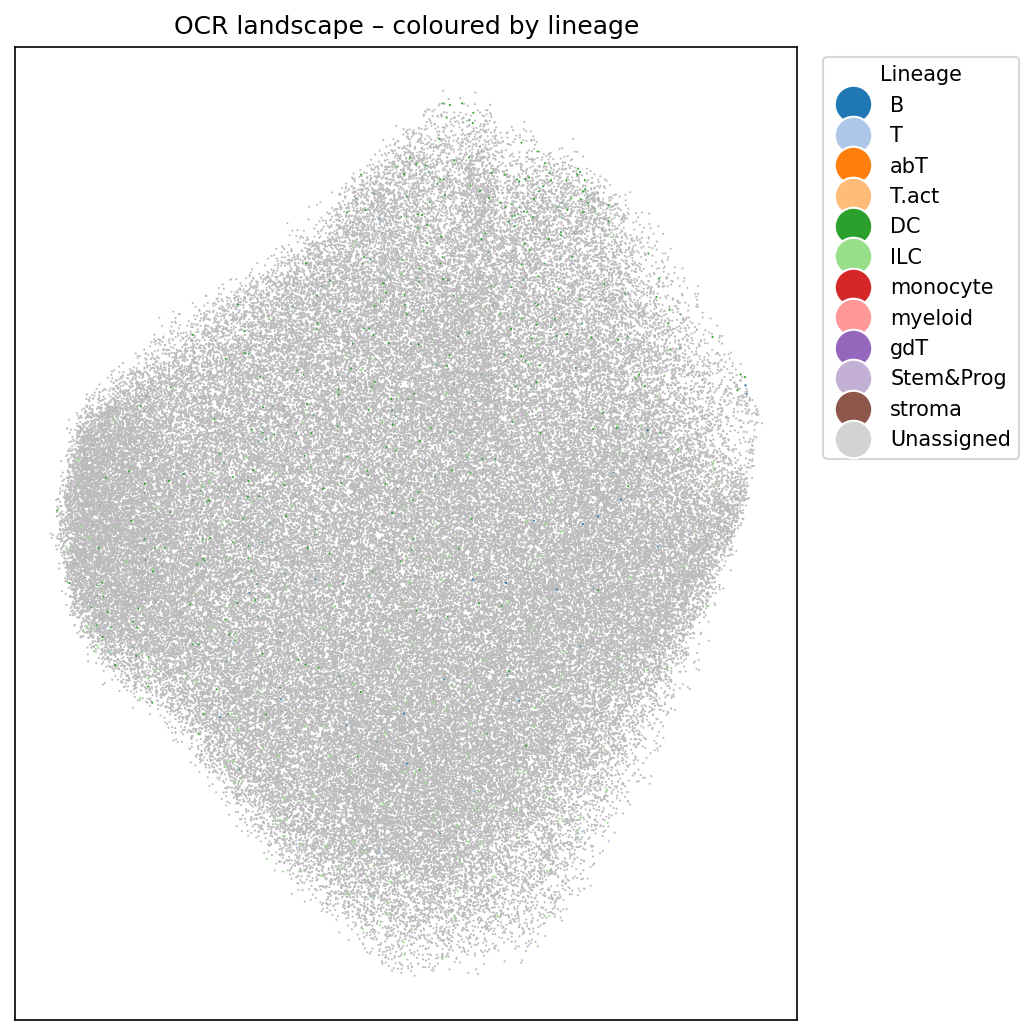

In [17]:
# ------------------------------------------------------------------
# 0.  PREP: decide how to get each sample's cell-type  ------------- 
# ------------------------------------------------------------------
# Option A ─ derive it from the column name
#   e.g.   'Bcell_01' → 'Bcell',   'T_Naive_03' → 'T'

import re
from lineage_colors import lineage_colors  
def extract_celltype(col):
    m = re.match(r"([A-Za-z]+)", col)      # tweak to match your naming rule
    return m.group(1) if m else "unknown"

sample_to_ct = pd.Series({c: extract_celltype(c) for c in mat.columns},
                         name="cell_type")

# # Option B ─ if you already have a dict or DataFrame, comment out A and use e.g.:
# sample_to_ct = pd.read_csv("path/to/my_celltype_table.csv",
#                            index_col=0)["cell_type"].reindex(mat.columns)

# ------------------------------------------------------------------
# 1.  For every OCR, find the cell-type where it is most open  -----
# ------------------------------------------------------------------
ct_means      = mat_s.groupby(sample_to_ct, axis=1).mean()   # region × cell-type mean
dominant_ct   = ct_means.idxmax(axis=1)                    # Series, length = n_regions

dominant_lineage = dominant_ct.str.extract(r'^([A-Za-z]+)')[0]
dot_colours = dominant_lineage.map(lineage_colors)
dot_colours = dot_colours.fillna("#bbbbbb")   # mid-grey for “other”

# ------------------------------------------------------------------
# 2.  Build a palette (replace this if you already have one)  ------
# ------------------------------------------------------------------
import matplotlib.pyplot as plt
unique_ct     = sorted(dominant_ct.unique())
cmap          = plt.cm.get_cmap("tab20", len(unique_ct))   # 20-colour cyclic map
palette       = {ct: cmap(i) for i, ct in enumerate(unique_ct)}

# ------------------------------------------------------------------
# 3.  Scatter the existing UMAP coords, coloured by cell-type  -----
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 7), dpi=150)

ax.scatter(xy[:, 0], xy[:, 1],
           c=dot_colours.values,
           s=1, lw=0)

ax.set(xticks=[], yticks=[],
       title="OCR landscape – coloured by lineage")

# nice legend on the right
from matplotlib.lines import Line2D
handles = [Line2D([0], [0], marker='o', color='w',
                  markerfacecolor=clr, markersize=6, lw=0, label=lin)
           for lin, clr in lineage_colors.items()]      # ← 2-tuple unpacking

ax.legend(handles=handles, title="Lineage",
          markerscale=3, bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()

plt.show()



c:\Users\annal\miniconda3\envs\envBCells1\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


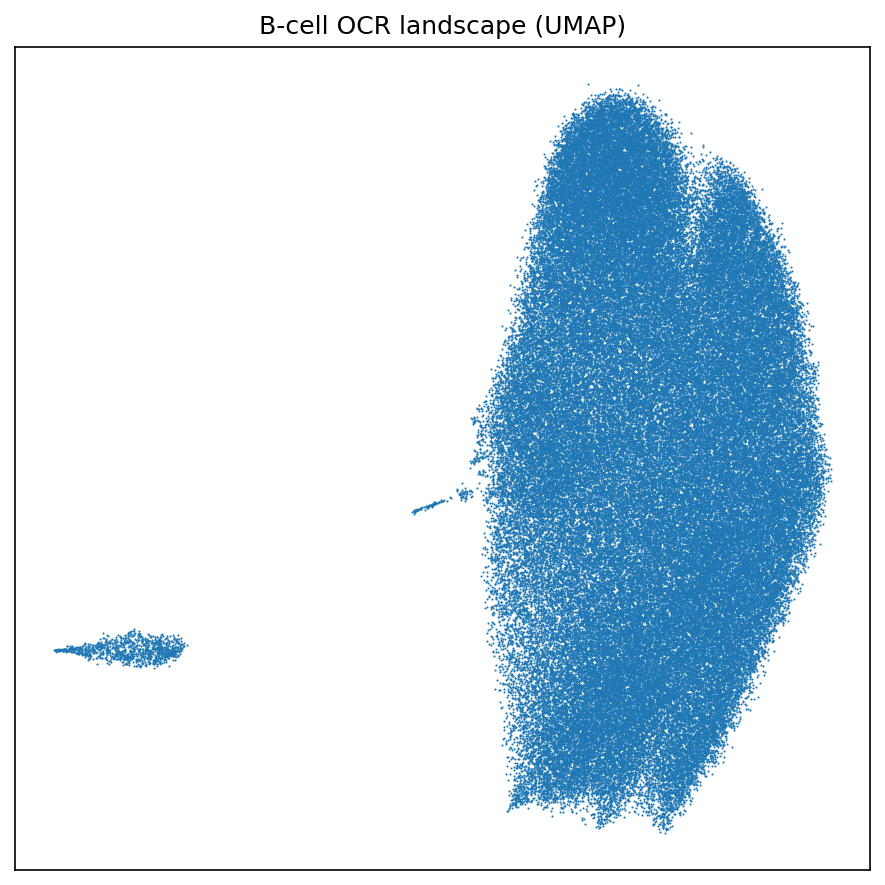

In [18]:
from lineage_colors import lineage_colors
# 1) read the B-cell-only file (comma-separated)
ATAC_MATRIX = pathlib.Path(r"data/ATAC_Bcells.csv")
mat = pd.read_csv(ATAC_MATRIX, sep=",", index_col=0, low_memory=False)


# 2) drop the five annotation columns -------------------------------
meta_cols = ["chrom", "Summit",
             "mm10.60way.phastCons_scores",
             "_-log10_bestPvalue",
             "Included.in.systematic.analysis"]
count_mat = mat.drop(columns=meta_cols)

# 3) numeric clean-up exactly as before -----------------------------
count_mat = (count_mat.apply(pd.to_numeric, errors="coerce")
                         .replace([np.inf, -np.inf], np.nan)
                         .fillna(0.0)
                         .astype(np.float64))

# 4) Yoshida log + quantile normalisation ---------------------------
count_mat = np.log2(count_mat + 0.1)
count_mat = (count_mat.rank(axis=0) / (len(count_mat)-1)).astype(np.float32)

# 5) optional down-sample rows -------------------------------------
MAX_PTS = 120_000
mat_s   = count_mat.sample(MAX_PTS, random_state=0) if len(count_mat) > MAX_PTS else count_mat

# 6) SVD → UMAP -----------------------------------------------------
svd    = TruncatedSVD(n_components=25, random_state=0)
pca_25 = svd.fit_transform(mat_s)

xy     = umap.UMAP(n_neighbors=30, min_dist=0.3, random_state=0).fit_transform(pca_25)

# 7) plot (single colour or your palette) ---------------------------
plt.figure(figsize=(6,6), dpi=150)
plt.scatter(xy[:,0], xy[:,1], s=1, lw=0, c="#1f77b4")
plt.xticks([]); plt.yticks([])
plt.title("B-cell OCR landscape (UMAP)")
plt.tight_layout(); plt.show()




In [4]:
import re

def parse_lineage(col):
    # feel free to adapt the patterns
    if re.search(r"\b(HSC|MPP|CLP|LMPP)\b", col):   return "prog"
    if re.search(r"\bDC|cDC|pDC\b", col):          return "DC"
    return "other"

sample_meta = pd.DataFrame({
    "sample" : mat.columns,
    "lineage": [parse_lineage(c) for c in mat.columns]
}).set_index("sample")


NameError: name 'mat' is not defined

In [1]:
tss_tab = pd.read_csv(
    r"data/Transcript, Coding, and Exon Start and End Positions.CSV",  # adjust!
    sep=";"
)

# tidy column names
tss_tab.columns = tss_tab.columns.str.strip().str.lower()

# “txstart” = 5′-most coordinate, strand-aware
tss_tab["txstart"] = np.where(
    tss_tab["strand"] == "+",
    tss_tab["5' transcript start"],
    tss_tab["3' transcript start"]
).astype(int)

tss_tab = (
    tss_tab.rename(columns={"chromosome": "chr"})[["chr", "txstart"]]
           .astype({"chr": str})
)
tss_tab["chr"] = tss_tab["chr"].str.replace("^chr", "", regex=True)


annot = (
    pd.read_csv(r"data/1.ATAC-Seq data.CSV", sep=";")            # path to the file
      .rename(columns={"ImmGenATAC1219.peakID": "peak"})   # match mat.index
      .set_index("peak")
)

# Extract chr:start-end from peak IDs  →  DataFrame with numeric coords
peak_df = (
     annot.loc[mat.index, ["chrom", "Summit"]]               
         .rename(columns={"chrom": "chr", "Summit": "mid"}))

peak_df["chr"] = peak_df["chr"].astype(str).str.replace("^chr", "", regex=True)
peak_df["mid"] = peak_df["mid"].astype(int) 

mask_arr = np.zeros(len(peak_df), dtype=bool)

tss_dict = {c: np.sort(pos) for c, pos in tss_tab.groupby("chr")["txstart"]}

for chr_name, row_pos in peak_df.groupby("chr").indices.items():   
    tss_pos = tss_dict.get(chr_name)
    if tss_pos is None or len(tss_pos) == 0:
        continue

    mids = peak_df["mid"].to_numpy()[row_pos]                      
    idx  = np.searchsorted(tss_pos, mids)

    left  = np.abs(mids - tss_pos[np.clip(idx-1, 0, len(tss_pos)-1)])
    right = np.abs(mids - tss_pos[np.clip(idx,   0, len(tss_pos)-1)])

    mask_arr[row_pos] = (np.minimum(left, right) <= 125)           

tss_mask = pd.Series(mask_arr, index=peak_df.index)
print("TSS-proximal peaks:", int(tss_mask.sum()))



# Converting masks in Numpy & plot 
mask_tss  = tss_mask.reindex(mat_s.index, fill_value=False).to_numpy()
mask_prog = peak_prog.reindex(mat_s.index, fill_value=False).to_numpy()
mask_dc   = peak_dc.reindex(mat_s.index,   fill_value=False).to_numpy()

overlay(mask_tss,  "steelblue", "Transcription start sites",      xy)
overlay(mask_prog, "royalblue", "Most accessible in progenitors", xy)
overlay(mask_dc,   "crimson",   "Dendritic cells",                xy)
plt.show()
  

NameError: name 'pd' is not defined

In [ ]:
# rewritten version of the code that just wont load  
sample_prog = sample_meta["lineage"].eq("prog")
sample_dc   = sample_meta["lineage"].eq("DC")


tss_tab = pd.read_csv(
    r"data/Transcript, Coding, and Exon Start and End Positions.CSV",  # adjust!
    sep=";"
)

# tidy column names
tss_tab.columns = tss_tab.columns.str.strip().str.lower()

# “txstart” = 5′-most coordinate, strand-aware
tss_tab["txstart"] = np.where(
    tss_tab["strand"] == "+",
    tss_tab["5' transcript start"],
    tss_tab["3' transcript start"]
).astype(int)

tss_tab = (
    tss_tab.rename(columns={"chromosome": "chr"})[["chr", "txstart"]]
           .astype({"chr": str})
)
tss_tab["chr"] = tss_tab["chr"].str.replace("^chr", "", regex=True)


annot = (
    pd.read_csv(r"data/1.ATAC-Seq data.CSV", sep=";")            # path to the file
      .rename(columns={"ImmGenATAC1219.peakID": "peak"})   # match mat.index
      .set_index("peak")
)
# Extract chr:start-end from peak IDs  →  DataFrame with numeric coords
peak_df = (
     annot.loc[mat.index, ["chrom", "Summit"]]               
         .rename(columns={"chrom": "chr", "Summit": "mid"}))

peak_df["chr"] = peak_df["chr"].astype(str).str.replace("^chr", "", regex=True)
peak_df["mid"] = peak_df["mid"].astype(int) 

mask_arr = np.zeros(len(peak_df), dtype=bool)

tss_dict = {c: np.sort(pos) for c, pos in tss_tab.groupby("chr")["txstart"]}

for chr_name, row_pos in peak_df.groupby("chr").indices.items():   
    tss_pos = tss_dict.get(chr_name)
    if tss_pos is None or len(tss_pos) == 0:
        continue

    mids = peak_df["mid"].to_numpy()[row_pos]                      
    idx  = np.searchsorted(tss_pos, mids)

    left  = np.abs(mids - tss_pos[np.clip(idx-1, 0, len(tss_pos)-1)])
    right = np.abs(mids - tss_pos[np.clip(idx,   0, len(tss_pos)-1)])

    mask_arr[row_pos] = (np.minimum(left, right) <= 125)           

tss_mask = pd.Series(mask_arr, index=peak_df.index)
print("TSS-proximal peaks:", int(tss_mask.sum()))

# helper
def top_in_lineage(mat, meta, lineage, top_k=40_000, min_fc=2):
    in_lin  = mat.loc[:, meta["lineage"].eq(lineage)]
    out_lin = mat.loc[:, ~meta["lineage"].eq(lineage)]

    fc = (in_lin.mean(axis=1) + 1e-9) / (out_lin.mean(axis=1) + 1e-9)
    keep = fc.nlargest(top_k).index
    return ((fc >= min_fc) & fc.index.isin(keep)).reindex(mat.index, fill_value=False)

def overlay(mask, color, title, xy,
            alpha_bg=0.08, s_fg=4, s_bg=1):
    """
    Draw the UMAP/t-SNE cloud in grey, then over-plot points where mask == True.
    - mask: 1-D Boolean array, same length/order as xy (rows = peaks)
    """
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.scatter(xy[:, 0], xy[:, 1],
               c="lightgrey", s=s_bg, lw=0, alpha=alpha_bg)
    ax.scatter(xy[mask, 0], xy[mask, 1],
               c=color,      s=s_fg, lw=0)
    ax.set(xticks=[], yticks=[], frame_on=False, title=title)
    plt.tight_layout()


# create the two Boolean Series (one row per peak)
peak_prog = top_in_lineage(mat, sample_meta, "prog")
peak_dc   = top_in_lineage(mat, sample_meta, "DC")

             # 120 000 peak IDs
# ------------------------------------------------------------------
# 1) Quick dimensionality reduction to ~50 components
from sklearn.decomposition import TruncatedSVD
import umap   


mat = pd.read_csv("data/ATAC_Bcells.csv", index_col=0)

# 1-a  force every entry to numeric, bad strings → NaN
mat = mat.apply(pd.to_numeric, errors="coerce")

# 1-b  turn ±Inf into NaN (they sometimes sneak through)
mat = mat.replace([np.inf, -np.inf], np.nan)

# 1-c  final fill: missing or bad values → 0 (safe for log1p / SVD)
mat = mat.fillna(0)

# 1-d  OPTIONAL: cast to float32 to save ~½ the RAM
mat = mat.astype(np.float32)

mat_s = np.log1p(mat)                # scaled matrix, still float32 and finite
              # pip/conda install umap-learn if missing

# after mat_s = np.log1p(mat)
                    # ← NEW

from sklearn.decomposition import TruncatedSVD
import umap

max_comp = min(mat_s.shape[1] - 1, 50)   # here: min(29, 50) = 29

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=max_comp, random_state=42)
X_50 = svd.fit_transform(mat_s)  

reducer = umap.UMAP(
    n_neighbors=30,
    min_dist=0.3,
    metric="cosine",
    random_state=42,
    verbose=True,
)
xy = reducer.fit_transform(X_50)            # (n_peaks × 2) NumPy array
        # shape = (n_peaks, 2)

# optional: persist so you don’t recompute next time
# pd.DataFrame(xy, index=mat_s.index, columns=["UMAP1","UMAP2"]).to_csv("peak_umap_coords.csv")
# ------------------------------------------------------------------


# Converting masks in Numpy & plot 
mask_tss  = tss_mask.reindex(common_idx.index, fill_value=False).to_numpy()
mask_prog = peak_prog.reindex(common_idx.index, fill_value=False).to_numpy()
mask_dc   = peak_dc.reindex(common_idx.index,   fill_value=False).to_numpy()

overlay(mask_tss,  "steelblue", "Transcription start sites",      xy)
overlay(mask_prog, "royalblue", "Most accessible in progenitors", xy)
overlay(mask_dc,   "crimson",   "Dendritic cells",                xy)
plt.show()
  

TSS-proximal peaks: 15875


c:\Users\annal\miniconda3\envs\envBCells1\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.3, n_jobs=1, n_neighbors=30, random_state=42, verbose=True)
Wed Jun 25 17:43:56 2025 Construct fuzzy simplicial set
Wed Jun 25 17:43:57 2025 Finding Nearest Neighbors
Wed Jun 25 17:43:57 2025 Building RP forest with 41 trees


: 

In [23]:
# ─────────────────────────────  IMPORTS  ─────────────────────────────
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 150    # crisper in VS Code

# ─────────────────────────────  INPUTS  ──────────────────────────────
# 1) Peak-by-sample matrix  (rows = peaks, cols = samples)
#    comment these two lines if you already have mat / mat_s in memory
mat    = pd.read_csv("data/ATAC_Bcells.csv", index_col=0)        # adjust path
mat    = mat.apply(pd.to_numeric, errors="coerce")          # force numeric
mat_s  = np.log1p(mat)                                      # simple scaling

# 2) 2-D coordinates for each peak (UMAP or t-SNE).  Must match mat.index.
#    comment this line if xy already exists
xy     = pd.read_csv("peak_umap_coords.csv", index_col=0).to_numpy()

# ───────────────────  SAMPLE METADATA (lineage)  ────────────────────
def parse_lineage(col):
    if re.search(r"\b(HSC|MPP|CLP|LMPP)\b", col): return "prog"
    if re.search(r"\bDC|cDC|pDC\b", col):        return "DC"
    return "other"

sample_meta = (
    pd.DataFrame({"sample": mat.columns})
      .assign(lineage=lambda df: df["sample"].map(parse_lineage))
      .set_index("sample")
)

# ─────────────────────────  TSS TABLE  ───────────────────────────────
tss_tab = (
    pd.read_csv(r"data/Transcript, Coding, and Exon Start and End Positions.CSV",
                sep=";")
      .pipe(lambda df: df.rename(columns=str.lower).rename(columns={"chromosome":"chr"}))
)
tss_tab["txstart"] = np.where(tss_tab["strand"] == "+",
                              tss_tab["5' transcript start"],
                              tss_tab["3' transcript start"]).astype(int)
tss_tab = tss_tab[["chr", "txstart"]].astype({"chr": str})
tss_tab["chr"] = tss_tab["chr"].str.replace("^chr", "", regex=True)

# ──────────────  PEAK COORDS  (from 1.ATAC-Seq data.CSV)  ─────────────
annot = (
    pd.read_csv(r"data/1.ATAC-Seq data.CSV", sep=";")
      .rename(columns={"ImmGenATAC1219.peakID": "peak"})
      .set_index("peak")
)
peak_df = (
    annot.loc[mat.index, ["chrom", "Summit"]]
         .rename(columns={"chrom":"chr", "Summit":"mid"})
)
peak_df["chr"] = peak_df["chr"].astype(str).str.replace("^chr", "", regex=True)
peak_df["mid"] = peak_df["mid"].astype(int)

# ───────────────  FAST ±125 bp TSS OVERLAP  (low-RAM)  ───────────────
mask_arr = np.zeros(len(peak_df), dtype=bool)
tss_dict = {c: np.sort(pos) for c, pos in tss_tab.groupby("chr")["txstart"]}

for chr_name, row_pos in peak_df.groupby("chr").indices.items():
    tss_pos = tss_dict.get(chr_name)
    if tss_pos is None:
        continue
    mids = peak_df["mid"].to_numpy()[row_pos]
    idx  = np.searchsorted(tss_pos, mids)
    left  = np.abs(mids - tss_pos[np.clip(idx-1, 0, len(tss_pos)-1)])
    right = np.abs(mids - tss_pos[np.clip(idx,   0, len(tss_pos)-1)])
    mask_arr[row_pos] = (np.minimum(left, right) <= 125)

tss_mask = pd.Series(mask_arr, index=peak_df.index)
print("TSS-proximal peaks:", int(tss_mask.sum()))

# ───────────────  DIFFERENTIAL ACCESSIBILITY (prog / DC)  ────────────
def top_in_lineage(mat, meta, lineage, top_k=40_000, min_fc=2):
    in_lin  = mat.loc[:, meta["lineage"].eq(lineage)]
    out_lin = mat.loc[:, ~meta["lineage"].eq(lineage)]
    fc = (in_lin.mean(axis=1) + 1e-9) / (out_lin.mean(axis=1) + 1e-9)
    keep = fc.nlargest(top_k).index
    return ((fc >= min_fc) & fc.index.isin(keep)).reindex(mat.index, fill_value=False)

peak_prog = top_in_lineage(mat, sample_meta, "prog")
peak_dc   = top_in_lineage(mat, sample_meta, "DC")

# ─────────────────────────────  PLOTTING  ────────────────────────────
def overlay(mask, color, title, xy, alpha_bg=0.08, s_fg=4, s_bg=1):
    fig, ax = plt.subplots(figsize=(4,4))
    ax.scatter(xy[:,0], xy[:,1], c="lightgrey", s=s_bg, lw=0, alpha=alpha_bg)
    ax.scatter(xy[mask,0], xy[mask,1], c=color,      s=s_fg, lw=0)
    ax.set(xticks=[], yticks=[], frame_on=False, title=title)
    plt.tight_layout()

mask_tss  = tss_mask .reindex(mat_s.index, fill_value=False).to_numpy()
mask_prog = peak_prog.reindex(mat_s.index, fill_value=False).to_numpy()
mask_dc   = peak_dc  .reindex(mat_s.index, fill_value=False).to_numpy()

overlay(mask_tss,  "steelblue", "Transcription start sites",      xy)
overlay(mask_prog, "royalblue", "Most accessible in progenitors", xy)
overlay(mask_dc,   "crimson",   "Dendritic cells",                xy)
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'peak_umap_coords.csv'

### a) Should peaks be removed due to lack of signal?

To solve this we did a Histogram with the mean signal across all samples for each Peak. With that we could find peaks that give no signal in the most cells -> chromatin is always closed 

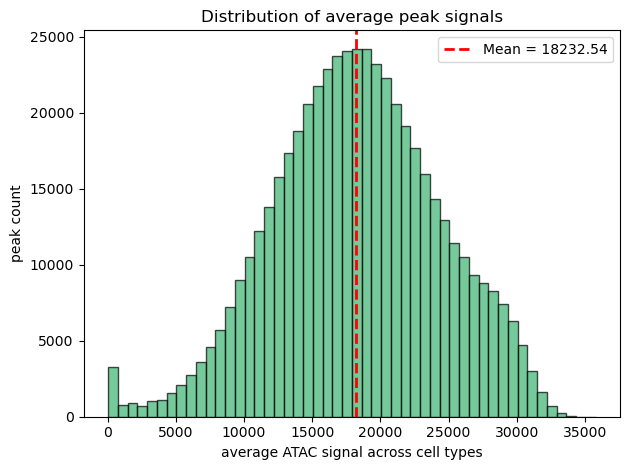

In [ ]:
ATAC = ATAC_included_values.copy()
signal_columns = ATAC_included_values.columns[2:92] 

# Mean across these columns (per row)
ATAC["peak_mean_signal"] = ATAC[signal_columns].mean(axis=1)

# Histogram of the mean of all peaks
plt.hist(ATAC["peak_mean_signal"].dropna(), bins=50, color="mediumseagreen", edgecolor="black", alpha=0.7)
plt.axvline(ATAC["peak_mean_signal"].mean(), color="red", linestyle="dashed", linewidth=2, label=f"Mean = {ATAC['peak_mean_signal'].mean():.2f}")
plt.xlabel("average ATAC signal across cell types")
plt.ylabel("peak count")
plt.title("Distribution of average peak signals")
plt.legend()
plt.tight_layout()
plt.savefig("figures/Distribution_of_ATAC_peaks.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# extract peaks with a low mean -> low signal
low_signal_peaks = ATAC_scaled[ATAC_scaled["peak_mean_signal"] < -0.8]
print(f"count of peaks with low mean signal: {len(low_signal_peaks)}")
low_signal_peaks.head()#
#low_signal_peaks contains low peaks -> low signal -> could be removed 
#you can change the threshold (-0.8) to make it more/less stright


count of peaks with low mean signal: 6231


CellType  mm10.60way.phastCons_scores  _-log10_bestPvalue  LTHSC.34-.BM  \
31                           0.812861            1.052346     -0.622619   
157                         -0.219575           -1.319972     -0.610870   
202                         -0.121248           -1.320812     -0.618935   
244                          1.107843           -1.320028     -0.617497   
376                         -0.121248           -1.315507     -0.607421   

CellType  LTHSC.34+.BM  STHSC.150-.BM  MPP4.135+.BM  proB.CLP.BM  proB.FrA.BM  \
31           -0.913378      -0.818063     -0.843321    -0.960137    -0.931487   
157          -0.903412      -0.812874     -0.838477    -0.955131    -0.927534   
202          -0.909541      -0.816399      1.869355    -0.957918    -0.929453   
244          -0.908961      -0.815396     -0.839791    -0.955895    -0.927686   
376          -0.897997      -0.808945     -0.831966    -0.950401    -0.921339   

CellType  proB.FrBC.BM  preB.FrD.BM  ...  DC.8+.Sp  DC.pDC.Sp  DC.103+11b+.SI  \
31           -0.956155     1.334373  ... -0.867550  -1.047149       -0.903951   
157          -0.953318    -1.101394  ... -0.861118  -1.042502       -0.899507   
202          -0.954753    -1.102748  ... -0.864847  -1.045179       -0.901671   
244          -0.953735    -1.101565  ... -0.864280  -1.043088       -0.900400   
376          -0.948010    -1.097311  ... -0.857653  -1.038799       -0.896384   

CellType  DC.103+11b-.SI   FRC.SLN   IAP.SLN   BEC.SLN   LEC.SLN  Ep.MEChi.Th  \
31             -0.842635 -0.343229  1.629110 -0.984936  0.062004    -0.887283   
157            -0.837118 -0.987176 -0.926804 -0.979376 -1.155704    -0.879998   
202            -0.840177 -0.992575 -0.929080 -0.982825 -1.160350    -0.885439   
244            -0.839229 -0.991237 -0.928063 -0.980665 -1.159527    -0.882420   
376            -0.833196 -0.984775 -0.921065 -0.974421 -1.152730    -0.876771   

CellType  peak_mean_signal  
31               -0.811659  
157              -0.983202  
202              -0.928467  
244              -0.958114  
376              -0.978404  

[5 rows x 93 columns]

### b) Do promoters exhibit specific signals vs enhancers?

In [ ]:
Annotation = pd.read_csv("data/Transcript, Coding, and Exon Start and End Positions.CSV", sep=";")
Annotation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47382 entries, 0 to 47381
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gene Name               47382 non-null  object
 1   Transcript Name         47382 non-null  object
 2   Chromosome              47382 non-null  object
 3   Strand                  47382 non-null  object
 4   5' transcript Start     47382 non-null  int64 
 5   3' Transcript Start     47382 non-null  int64 
 6   Coding Region 5' Start  47382 non-null  int64 
 7   Coding Region 3' Start  47382 non-null  int64 
 8   Exon Count              47382 non-null  int64 
 9   Exon Starts             47382 non-null  object
 10  Exon Ends               47382 non-null  object
dtypes: int64(5), object(6)
memory usage: 4.0+ MB


In [ ]:
Annotation.head()

Gene Name Transcript Name Chromosome Strand  5' transcript Start  \
0    Wdsub1    NM_001159636       chr2      -             59855193   
1     Rbm18    NM_001159635       chr2      -             36116078   
2    Prrc2b    NM_001159634       chr2      +             32151147   
3     Ildr2    NM_001164528       chr1      +            166254138   
4     Perm1       NM_172417       chr4      +            156215926   

   3' Transcript Start   Coding Region 5' Start  Coding Region 3' Start  \
0              59882606                59855270                59878527   
1              36136704                36117814                36134247   
2              32234537                32182511                32230742   
3             166316832               166254375               166310795   
4             156221307               156217000               156220222   

   Exon Count                                       Exon Starts   \
0          11  59855193,59858609,59861560,59862619,59862816,5...   
1           6  36116078,36120812,36122851,36127214,36134134,3...   
2          32  32151147,32182457,32183122,32185344,32187480,3...   
3          10  166254138,166269304,166270498,166291415,166294...   
4           4           156215926,156216716,156219740,156220109,   

                                           Exon Ends  
0  59855275,59858750,59861737,59862726,59862857,5...  
1  36117974,36120898,36122938,36127251,36134263,3...  
2  32151291,32182626,32183300,32185447,32187553,3...  
3  166254466,166269637,166270618,166291472,166294...  
4           156215975,156219185,156219866,156221307,

In [ ]:
#names of coloumns
for col in Annotation.columns:
    print(repr(col))

'Gene Name'
'Transcript Name'
'Chromosome'
'Strand'
"5' transcript Start"
"3' Transcript Start "
"Coding Region 5' Start"
"Coding Region 3' Start"
'Exon Count'
'Exon Starts '
'Exon Ends'


In [ ]:
#extract  TSS positions 
def get_TSS(row):
    if row["Strand"] == "+":
        return row["5' transcript Start"]
    else:
        return row["3' Transcript Start "]

Annotation["TSS"] = Annotation.apply(get_TSS, axis=1)

#new data set with only needed coloumns
TSS = Annotation[["Gene Name", "Chromosome", "TSS"]].copy()
TSS.columns = ["Gene", "Chromosome", "TSS"]

TSS.head()

Gene Chromosome        TSS
0  Wdsub1       chr2   59882606
1   Rbm18       chr2   36136704
2  Prrc2b       chr2   32151147
3   Ildr2       chr1  166254138
4   Perm1       chr4  156215926

In [ ]:
#prepare ATAC:
ATAC["Start"] = ATAC["Summit"]
ATAC["End"] = ATAC["Summit"] + 1

#only needed coloumns
ATAC_peaks = ATAC[["chrom", "Start", "End", "ImmGenATAC1219.peakID"]].copy()
ATAC_peaks.columns = ["Chromosome", "Start", "End", "peak_id"]

In [ ]:
#group Peaks und TSS one same chromosome
distance_list = []

for chrom in ATAC_peaks['Chromosome'].unique():
    peaks_chr = ATAC_peaks[ATAC_peaks["Chromosome"] == chrom].copy()
    tss_chr = TSS[TSS["Chromosome"] == chrom]

    if len(tss_chr) == 0 or len(peaks_chr) == 0:
        continue

    #prep  Arrays 
    peak_positions = peaks_chr["Start"].values.reshape(-1, 1)
    tss_positions = tss_chr["TSS"].values.reshape(-1, 1)

    # kNN-Modell (find next TSS)
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(tss_positions)
    dists, indices = nbrs.kneighbors(peak_positions)

    #save distance
    peaks_chr['distance_to_TSS'] = dists.flatten()
    distance_list.append(peaks_chr[['peak_id', 'distance_to_TSS']])
                         
distance = pd.concat(distance_list)  

distance.head()

NameError: name 'TSS' is not defined

In [ ]:
#add distance in ATAC
ATAC_dis = ATAC.merge(distance[['peak_id', 'distance_to_TSS']], left_on='ImmGenATAC1219.peakID', right_on='peak_id', how='left')
ATAC_dis.head()

ImmGenATAC1219.peakID chrom   Summit  mm10.60way.phastCons_scores  \
0   ImmGenATAC1219.peak_21  chr1  3671437                         0.72   
1  ImmGenATAC1219.peak_140  chr1  4785675                         0.41   
2  ImmGenATAC1219.peak_146  chr1  4807877                         0.47   
3  ImmGenATAC1219.peak_158  chr1  4857752                         0.12   
4  ImmGenATAC1219.peak_160  chr1  4858351                         0.02   

   _-log10_bestPvalue  Included.in.systematic.analysis     TSS  \
0            45690.00                              1.0    Xkr4   
1               15.87                              1.0  Mrpl15   
2            46016.00                              1.0  Lypla1   
3               45.65                              1.0   Tcea1   
4            28672.00                              1.0   Tcea1   

    genes.within.100Kb  LTHSC.34-.BM  LTHSC.34+.BM  ...   FRC.SLN   IAP.SLN  \
0                 Xkr4          0.41      24898.00  ...  35521.00  22678.00   
1  Mrpl15,Lypla1,Tcea1      34213.00      45828.00  ...     33.25     23.63   
2  Mrpl15,Lypla1,Tcea1         29.54         42.40  ...     32.82     31.65   
3  Mrpl15,Lypla1,Tcea1        115.42        141.25  ...    133.71     85.20   
4  Mrpl15,Lypla1,Tcea1      13606.00      45844.00  ...  12632.00  27973.00   

    BEC.SLN   LEC.SLN  Ep.MEChi.Th   mean_signal    Start      End  \
0  23408.00  30348.00        17.14  58623.176277  3671437  3671438   
1  45920.00  45729.00        22.38  58767.915957  4785675  4785676   
2     38.34     26.68        33.27  56031.796596  4807877  4807878   
3    101.38    137.79       129.55  51757.845851  4857752  4857753   
4     17.31  14458.00     45880.00  71680.865745  4858351  4858352   

                   peak_id  distance_to_TSS  
0   ImmGenATAC1219.peak_21             61.0  
1  ImmGenATAC1219.peak_140             51.0  
2  ImmGenATAC1219.peak_146             55.0  
3  ImmGenATAC1219.peak_158             59.0  
4  ImmGenATAC1219.peak_160             24.0  

[5 rows x 103 columns]

In [ ]:
# calculate mean signals per peak
signal_cols = ATAC_dis.select_dtypes(include=["float64", "int64"]).columns
ATAC_dis['mean_signal'] = ATAC_dis[signal_cols].mean(axis=1)



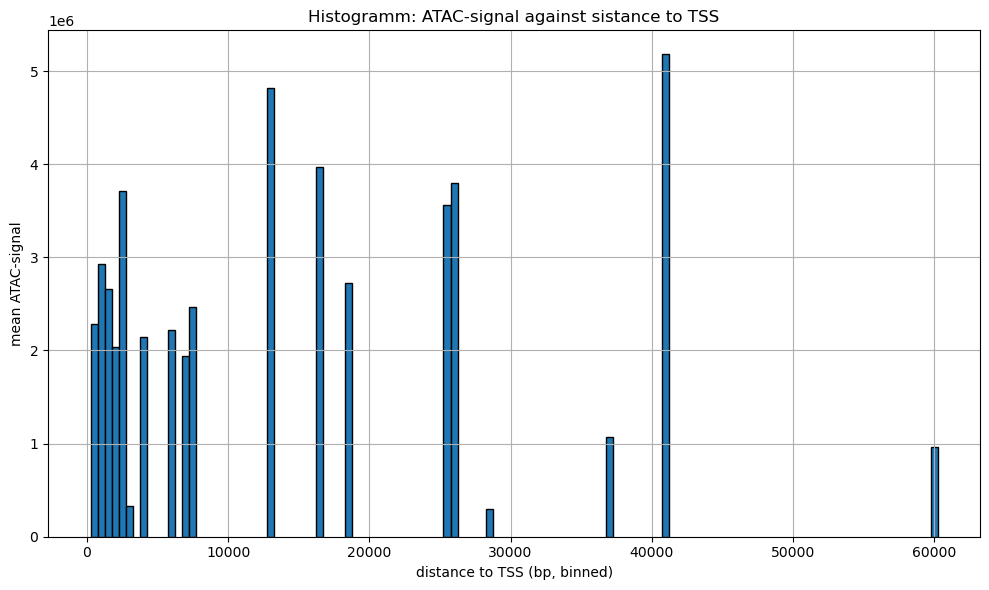

In [ ]:
# 1. Binning der Distanz zur TSS (z. B. in 1 kb-Schritten bis 100 kb)
bin_size = 500
max_dist = 100000

# Filter auf sinnvolle Distanz
df = ATAC_dis[ATAC_dis['distance_to_TSS'] <= max_dist].copy()

# Bins erstellen
df['distance_bin'] = (df['distance_to_TSS'] // bin_size) * bin_size

# 2. Mittelwerte pro Bin berechnen
binned = (
    df.groupby('distance_bin')['mean_signal']
    .mean()
    .reset_index()
    .sort_values('distance_bin')
)

# 3. Histogramm zeichnen
plt.figure(figsize=(10, 6))
plt.bar(binned['distance_bin'], binned['mean_signal'], width=bin_size, align='center', edgecolor='black')
plt.xlabel("distance to TSS (bp, binned)")
plt.ylabel("mean ATAC-signal")
plt.title("Histogramm: ATAC-signal against sistance to TSS")
plt.grid(True)
plt.tight_layout()
plt.show()

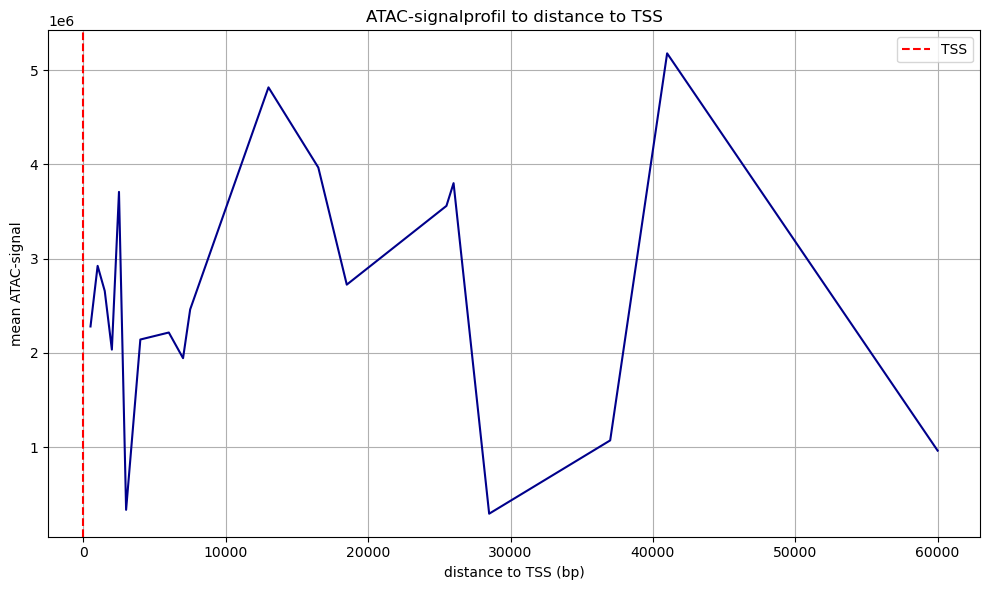

In [ ]:
max_dist = 100_000 

df_plot = ATAC_dis[ATAC_dis['distance_to_TSS'] <= max_dist].copy()

df_plot['distance_to_TSS'] = df_plot['distance_to_TSS'].astype(int)

bin_size = 500
df_plot['binned_dist'] = (df_plot['distance_to_TSS'] // bin_size) * bin_size

binned_mean = df_plot.groupby('binned_dist')['mean_signal'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(binned_mean['binned_dist'], binned_mean['mean_signal'], color='darkblue')
plt.axvline(0, color='red', linestyle='--', label='TSS')
plt.xlabel('distance to TSS (bp)')
plt.ylabel('mean ATAC-signal')
plt.title('ATAC-signalprofil to distance to TSS')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### c) Is there a relationship between the signal and the distance to the TSS?

To answer this we examined if peaks closer to the Transcription Start Site (TSS) have higher/lower ATAC-seq signals. 

In [ ]:
#extract  TSS positions 
def get_TSS(row):
    if row["Strand"] == "+":
        return row["5' transcript Start"]
    else:
        return row["3' Transcript Start "]

Annotation["TSS"] = Annotation.apply(get_TSS, axis=1)

#new data set with only needed coloumns
TSS = Annotation[["Gene Name", "Chromosome", "TSS"]].copy()
TSS.columns = ["Gene", "Chromosome", "TSS"]

TSS.head()


Gene Chromosome        TSS
0  Wdsub1       chr2   59882606
1   Rbm18       chr2   36136704
2  Prrc2b       chr2   32151147
3   Ildr2       chr1  166254138
4   Perm1       chr4  156215926

In [ ]:
#prepare ATAC:
ATAC["Start"] = ATAC["Summit"]
ATAC["End"] = ATAC["Summit"] + 1

#only needed coloumns
ATAC_peaks = ATAC[["chrom", "Start", "End", "ImmGenATAC1219.peakID"]].copy()
ATAC_peaks.columns = ["Chromosome", "Start", "End", "peak_id"]

In [ ]:
#group Peaks und TSS one same chromosome
distance_list = []

for chrom in ATAC_peaks['Chromosome'].unique():
    peaks_chr = ATAC_peaks[ATAC_peaks["Chromosome"] == chrom].copy()
    tss_chr = TSS[TSS["Chromosome"] == chrom]

    if len(tss_chr) == 0 or len(peaks_chr) == 0:
        continue

    #prep  Arrays 
    peak_positions = peaks_chr["Start"].values.reshape(-1, 1)
    tss_positions = tss_chr["TSS"].values.reshape(-1, 1)

    # kNN-Modell (find next TSS)
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(tss_positions)
    dists, indices = nbrs.kneighbors(peak_positions)

    #save distance
    peaks_chr['distance_to_TSS'] = dists.flatten()
    distance_list.append(peaks_chr[['peak_id', 'distance_to_TSS']])
                         
distance = pd.concat(distance_list)  

distance.head()

peak_id  distance_to_TSS
0  ImmGenATAC1219.peak_1         650712.0
1  ImmGenATAC1219.peak_2         584272.0
2  ImmGenATAC1219.peak_3         551389.0
3  ImmGenATAC1219.peak_4         550013.0
4  ImmGenATAC1219.peak_5         298711.0

In [ ]:
#add distance in ATAC
ATAC_dis = ATAC.merge(distance[['peak_id', 'distance_to_TSS']], left_on='ImmGenATAC1219.peakID', right_on='peak_id', how='left')
ATAC_dis.head()

ImmGenATAC1219.peakID chrom   Summit  mm10.60way.phastCons_scores  \
0  ImmGenATAC1219.peak_1  chr1  3020786                         0.00   
1  ImmGenATAC1219.peak_2  chr1  3087226                         0.00   
2  ImmGenATAC1219.peak_3  chr1  3120109                         0.07   
3  ImmGenATAC1219.peak_4  chr1  3121485                         0.15   
4  ImmGenATAC1219.peak_5  chr1  3372787                         0.03   

   _-log10_bestPvalue  Included.in.systematic.analysis  TSS  \
0                0.56                              NaN  NaN   
1                0.50                              NaN  NaN   
2            45879.00                              1.0  NaN   
3            45691.00                              1.0  NaN   
4            11324.00                              NaN  NaN   

  genes.within.100Kb  LTHSC.34-.BM  LTHSC.34+.BM  ...   IAP.SLN   BEC.SLN  \
0                NaN          0.41          0.71  ...      0.10      0.57   
1                NaN          0.41      23377.00  ...      0.98  42401.00   
2                NaN      13181.00          0.10  ...  33817.00  12055.00   
3                NaN          0.41          0.10  ...      0.98  46753.00   
4                NaN          0.41          0.10  ...      0.75  12055.00   

   LEC.SLN  Ep.MEChi.Th    region   mean_signal    Start      End  \
0  46447.0     14977.00  Enhancer  45113.170215  3020786  3020787   
1  12451.0         0.94  Enhancer  42780.219677  3087226  3087227   
2  45748.0         0.11  Enhancer  41022.576915  3120109  3120110   
3  45748.0         0.11  Enhancer  42544.601383  3121485  3121486   
4  22282.0     45781.00  Enhancer  47175.667742  3372787  3372788   

                 peak_id  distance_to_TSS  
0  ImmGenATAC1219.peak_1         650712.0  
1  ImmGenATAC1219.peak_2         584272.0  
2  ImmGenATAC1219.peak_3         551389.0  
3  ImmGenATAC1219.peak_4         550013.0  
4  ImmGenATAC1219.peak_5         298711.0  

[5 rows x 104 columns]

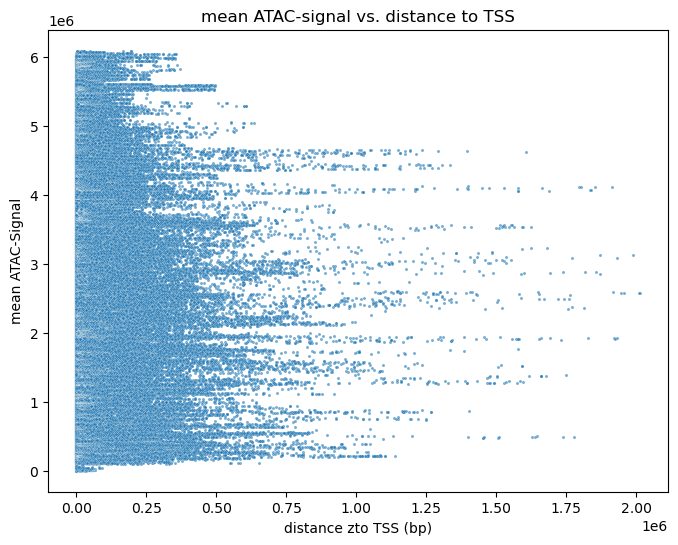

In [ ]:
# calculate mean signals per peak
signal_cols = ATAC_dis.select_dtypes(include=["float64", "int64"]).columns
ATAC_dis['mean_signal'] = ATAC_dis[signal_cols].mean(axis=1)

# data and remove NAs
df = ATAC_dis[['mean_signal', 'distance_to_TSS']].dropna()

# scatterplot
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='distance_to_TSS', y='mean_signal', alpha=0.6, s=5,)

plt.xlabel('distance zto TSS (bp)')
plt.ylabel('mean ATAC-Signal')
plt.title('mean ATAC-signal vs. distance to TSS')
plt.show()

In [ ]:
#correlation
corr = df.corr().loc['mean_signal', 'distance_to_TSS']
print(f"Pearson-Korrelation: {corr:.3f}")

Pearson-Korrelation: -0.045


### d) Are intronic enhancers different from enhancers outside the transcript.

To find out if whether intornic enhacners (inside of transcripts) are different from enhancers outside the transcript we first extracted the Transcript regions out of the Annotation data

In [ ]:
#only coloumns with needed information 
transcripts = Annotation[["Chromosome", "5' transcript Start", "3' Transcript Start ", "Gene Name", "Strand"]].copy()

#rename for similar names 
transcripts.columns = ["chr", "start", "end", "gene", "strand"]

#check:  start < end (no difference between +, - because we just want to know if its within)
transcripts["tx_start"] = transcripts[["start", "end"]].min(axis=1)
transcripts["tx_end"] = transcripts[["start", "end"]].max(axis=1)

#final data
transcripts = transcripts[["chr", "tx_start", "tx_end", "gene"]]
transcripts.head()


chr   tx_start     tx_end    gene
0  chr2   59855193   59882606  Wdsub1
1  chr2   36116078   36136704   Rbm18
2  chr2   32151147   32234537  Prrc2b
3  chr1  166254138  166316832   Ildr2
4  chr4  156215926  156221307   Perm1

In [ ]:
#Tree per chromosome
trees = defaultdict(IntervalTree)

for _, row in transcripts.iterrows():
    trees[row["chr"]].add(Interval(row["tx_start"], row["tx_end"], data=row["gene"]))


In [ ]:
#prep ATAC-Peaks
ATAC["Start"] = ATAC["Summit"]
ATAC["End"] = ATAC["Summit"] + 1

In [ ]:
#classifiy: Intronic?
def is_intronic(row):
    chrom = row["chrom"]
    start = row["Start"]
    end = row["End"]
    return len(trees[chrom].overlap(start, end)) > 0

ATAC["is_intronic"] = ATAC.apply(is_intronic, axis=1)
ATAC.head()


ImmGenATAC1219.peakID chrom   Summit  mm10.60way.phastCons_scores  \
0  ImmGenATAC1219.peak_1  chr1  3020786                         0.00   
1  ImmGenATAC1219.peak_2  chr1  3087226                         0.00   
2  ImmGenATAC1219.peak_3  chr1  3120109                         0.07   
3  ImmGenATAC1219.peak_4  chr1  3121485                         0.15   
4  ImmGenATAC1219.peak_5  chr1  3372787                         0.03   

   _-log10_bestPvalue  Included.in.systematic.analysis  TSS  \
0                0.56                              NaN  NaN   
1                0.50                              NaN  NaN   
2            45879.00                              1.0  NaN   
3            45691.00                              1.0  NaN   
4            11324.00                              NaN  NaN   

  genes.within.100Kb  LTHSC.34-.BM  LTHSC.34+.BM  ...   FRC.SLN   IAP.SLN  \
0                NaN          0.41          0.71  ...  46388.00      0.10   
1                NaN          0.41      23377.00  ...      0.92      0.98   
2                NaN      13181.00          0.10  ...     63.38  33817.00   
3                NaN          0.41          0.10  ...  45790.00      0.98   
4                NaN          0.41          0.10  ...      0.92      0.75   

    BEC.SLN  LEC.SLN  Ep.MEChi.Th    region   mean_signal    Start      End  \
0      0.57  46447.0     14977.00  Enhancer  45113.170215  3020786  3020787   
1  42401.00  12451.0         0.94  Enhancer  42780.219677  3087226  3087227   
2  12055.00  45748.0         0.11  Enhancer  41022.576915  3120109  3120110   
3  46753.00  45748.0         0.11  Enhancer  42544.601383  3121485  3121486   
4  12055.00  22282.0     45781.00  Enhancer  47175.667742  3372787  3372788   

   is_intronic  
0        False  
1        False  
2        False  
3        False  
4         True  

[5 rows x 103 columns]

In [ ]:
ATAC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512595 entries, 0 to 512594
Columns: 103 entries, ImmGenATAC1219.peakID to is_intronic
dtypes: bool(1), float64(94), int64(3), object(5)
memory usage: 399.4+ MB


In [ ]:
#check for inf and replace 
np.isinf(ATAC["mean_signal"]).sum()
ATAC["mean_signal"] = ATAC["mean_signal"].replace([np.inf, -np.inf], np.nan)

In [ ]:
# compare mean 
intronic_mean = ATAC[ATAC["is_intronic"]]["mean_signal"].mean()
non_intronic_mean = ATAC[~ATAC["is_intronic"]]["mean_signal"].mean()

print("Intronic Enhancer mean:", round(intronic_mean, 3))
print("Non-intronic Enhancer mean:", round(non_intronic_mean, 3))


Intronic Enhancer mean: 829908.197
Non-intronic Enhancer mean: 827764.297


In [ ]:
#category names for plot
ATAC_plot = ATAC.copy()
ATAC_plot["Enhancer Type"] = ATAC_plot["is_intronic"].map({True: "Intronic", False: "Non-intronic"})

C:\Users\Celine\AppData\Local\Temp\ipykernel_3048\1445846245.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=ATAC_plot, x="Enhancer Type", y="mean_signal", palette="Set2")


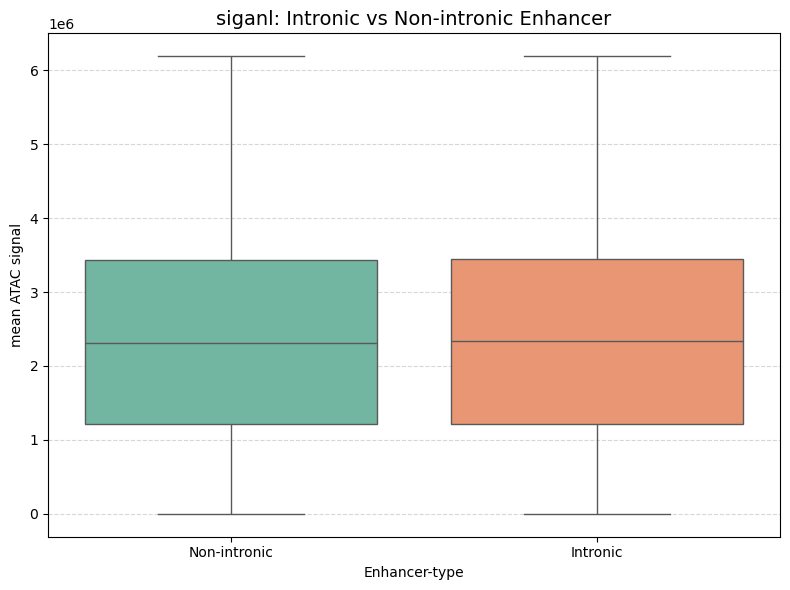

In [ ]:
# Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=ATAC_plot, x="Enhancer Type", y="mean_signal", palette="Set2")

plt.title("siganl: Intronic vs Non-intronic Enhancer", fontsize=14)
plt.xlabel("Enhancer-type")
plt.ylabel("mean ATAC signal")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## iii. Do related cell types cluster together based on ATAC signal?

### a) Does clustering reproduce known relationship?

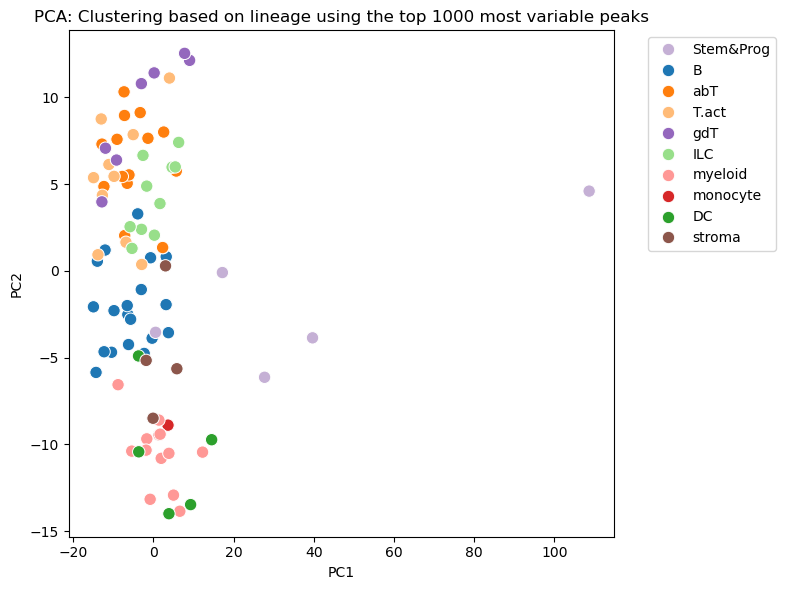

In [ ]:
# top 1000 variable peaks
variances = ATAC_scaled.var(axis=1)  # Zeilen = Peaks, da transponiert
top_peaks = variances.sort_values(ascending=False).head(1000).index
ATAC_reduced = ATAC_scaled.loc[top_peaks]  # Subset auf 1000 Peaks

# samples = rows
df_pca_input = ATAC_reduced.T

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_pca_input)

# save in dataframe
df_pca = pd.DataFrame(pca_result, columns=["PC1", "PC2"], index=df_pca_input.index)

# celltype annotation
QC = pd.read_csv("data/ATAC_QCmatric.csv", sep=";")
QC.columns = QC.columns.str.strip()
QC["CellType"] = QC["CellType"].str.strip()

# unique celltypes
qc_unique = QC.drop_duplicates(subset="CellType", keep="first")

# carry out mapping safely
df_pca["Lineage"] = df_pca.index.map(qc_unique.set_index("CellType")["Lineage"])

# plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="Lineage", palette=lineage_colors, s=80)
plt.title("PCA: Clustering based on lineage using the top 1000 most variable peaks")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("figures/PCA.png", dpi=300, bbox_inches="tight")
plt.show()


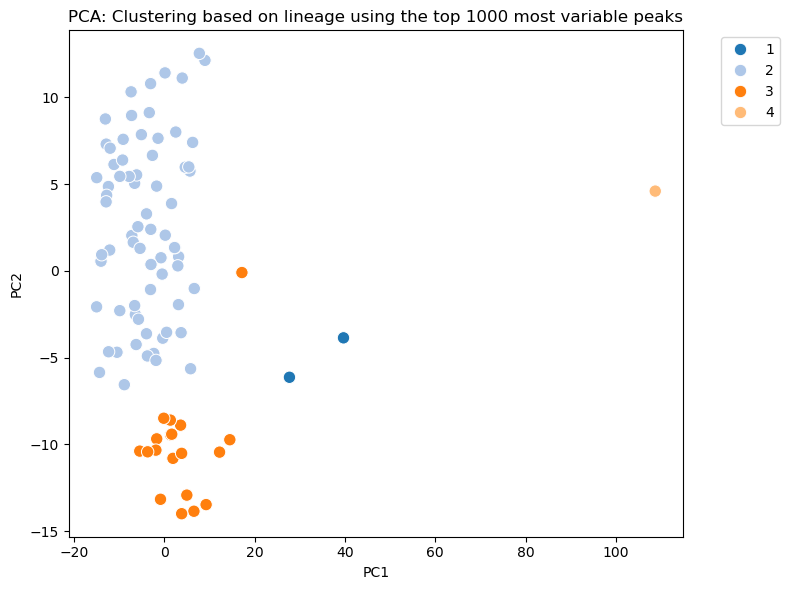

In [ ]:
# the there is a outlier at the top of the plot, which we want to remove, because it is not in the upper pca either
df_pca_without_outliner = df_pca.loc[(df_pca["PC2"] <= 15)].copy()

# clustering by coloring the clusters for comparison
Z = linkage(df_pca_without_outliner[['PC1','PC2']], method='average', metric='euclidean')

# cut into 2 clusters:
df_pca_without_outliner['cluster'] = fcluster(Z, t=4, criterion='maxclust')


plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca_without_outliner, x="PC1", y="PC2", hue="cluster", palette="tab20", s=80)
plt.title("PCA: Clustering based on lineage using the top 1000 most variable peaks")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("figures/PCA_clusters.png", dpi=300, bbox_inches="tight")
plt.show()

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [35.0, 35.0, 45.0, 45.0],
  [75.0, 75.0, 85.0, 85.0],
  [65.0, 65.0, 80.0, 80.0],
  [55.0, 55.0, 72.5, 72.5],
  [105.0, 105.0, 115.0, 115.0],
  [95.0, 95.0, 110.0, 110.0],
  [63.75, 63.75, 102.5, 102.5],
  [40.0, 40.0, 83.125, 83.125],
  [145.0, 145.0, 155.0, 155.0],
  [135.0, 135.0, 150.0, 150.0],
  [125.0, 125.0, 142.5, 142.5],
  [185.0, 185.0, 195.0, 195.0],
  [175.0, 175.0, 190.0, 190.0],
  [165.0, 165.0, 182.5, 182.5],
  [205.0, 205.0, 215.0, 215.0],
  [225.0, 225.0, 235.0, 235.0],
  [245.0, 245.0, 255.0, 255.0],
  [230.0, 230.0, 250.0, 250.0],
  [210.0, 210.0, 240.0, 240.0],
  [173.75, 173.75, 225.0, 225.0],
  [265.0, 265.0, 275.0, 275.0],
  [285.0, 285.0, 295.0, 295.0],
  [305.0, 305.0, 315.0, 315.0],
  [290.0, 290.0, 310.0, 310.0],
  [270.0, 270.0, 300.0, 300.0],
  [325.0, 325.0, 335.0, 335.0],
  [355.0, 355.0, 365.0, 365.0],
  [345.0, 345.0, 360.0, 360.0],
  [330.0, 330.0, 352.5, 352.5],
  [385.0, 385.0, 395.0, 395.0],
  [405.0, 405.0, 4

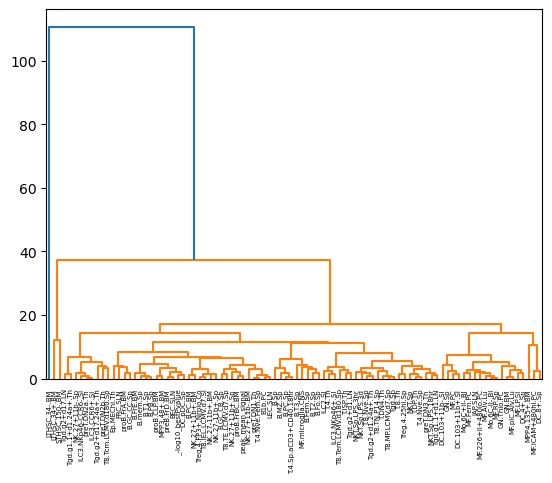

In [ ]:
# optimal number of clusters for our pca above: dendrogram
Z = linkage(df_pca_without_outliner[['PC1','PC2']], method='average', metric='euclidean')
dendrogram(Z, labels=df_pca_without_outliner.index, leaf_rotation=90)

/opt/miniconda3/envs/envBCells1/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


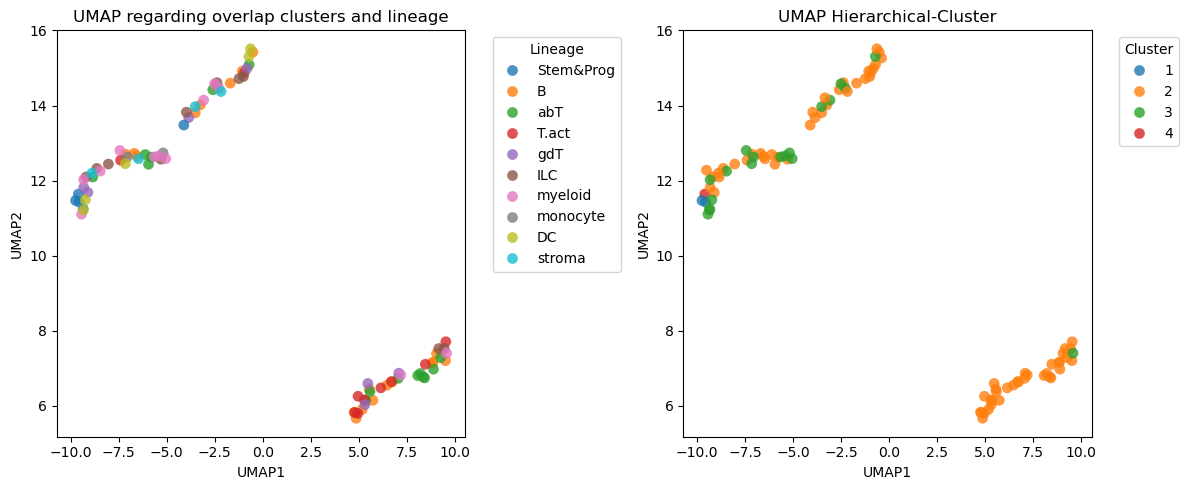

In [ ]:
# using UMAP to determine the overlap between the clusters and the true lineage

df_pca_without_outlier = df_pca[df_pca["PC1"] < 60].copy()

# should I do it with more than 2 PCs? If so, how many and how do I change them without an error?
pc_cols = [f"PC{i}" for i in range(1,2)]
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embedding = reducer.fit_transform(df_pca_without_outliner[pc_cols])


df_pca_without_outliner.loc[:, "UMAP1"] = embedding[:, 0]
df_pca_without_outliner.loc[:, "UMAP2"] = embedding[:, 1]


fig, axes = plt.subplots(1,2, figsize=(12,5))

sns.scatterplot(ax=axes[0],data=df_pca_without_outliner,x="UMAP1", y="UMAP2",hue="Lineage",palette="tab10", s=60,linewidth=0,alpha=0.8)
axes[0].set_title("UMAP regarding overlap clusters and lineage")
axes[0].legend(bbox_to_anchor=(1.05,1), loc="upper left", title="Lineage")

sns.scatterplot(ax=axes[1],data=df_pca_without_outliner, x="UMAP1", y="UMAP2",hue="cluster",        palette="tab10",s=60,linewidth=0,alpha=0.8)
axes[1].set_title("UMAP Hierarchical‐Cluster")
axes[1].legend(bbox_to_anchor=(1.05,1), loc="upper left", title="Cluster")

plt.tight_layout()
plt.savefig("figures/UMAP_clusters_lineage.png", dpi=300, bbox_inches="tight")
plt.show()

### Cell type vs Clusters (correlation)

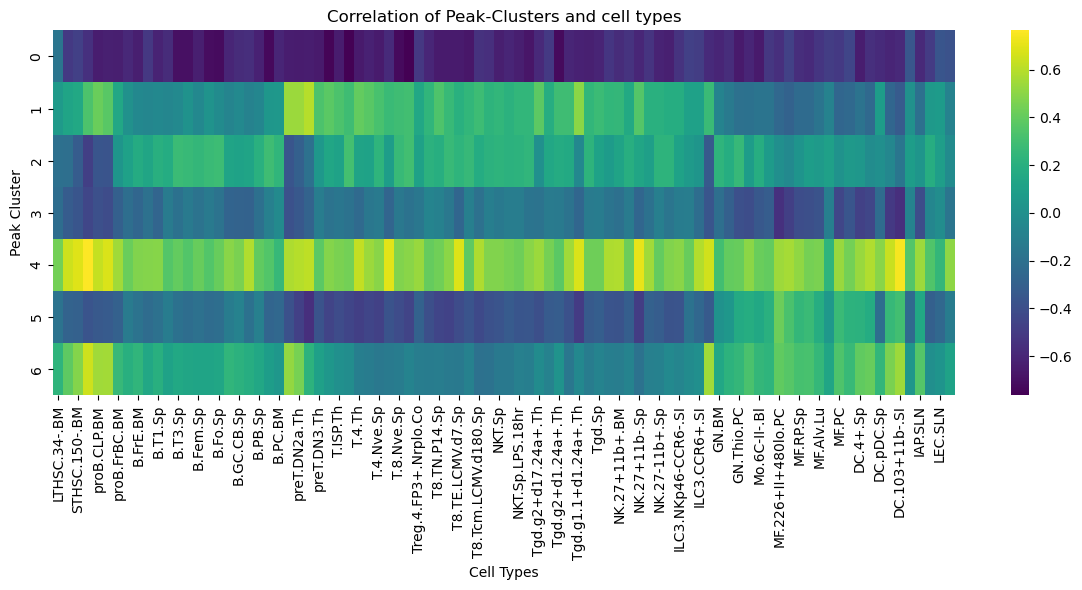

In [ ]:
peak_labels = labels_7

peak_clusters = pd.DataFrame({
    'peak': ATAC_scaled_ct.index,
    'cluster': peak_labels
})

ATAC_scaled_ct_with_cluster = ATAC_scaled_ct.copy()
ATAC_scaled_ct_with_cluster['cluster'] = peak_clusters['cluster'].values

mean_signal_per_peak_cluster = ATAC_scaled_ct_with_cluster.groupby('cluster').mean()

plt.figure(figsize=(12, 6))
sns.heatmap(mean_signal_per_peak_cluster, cmap='viridis')
plt.title("Correlation of Peak-Clusters and cell types")
plt.xlabel("Cell Types")
plt.ylabel("Peak Cluster")
plt.tight_layout()
plt.savefig("figures/Correlation_Peak-Clusters_CellTypes.png", dpi=300, bbox_inches="tight")
plt.show()

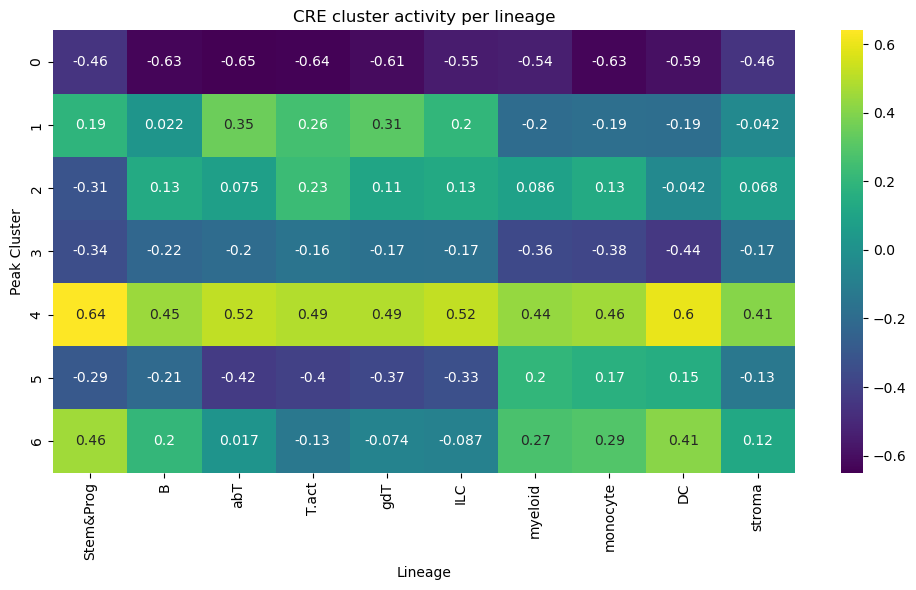

In [ ]:
# 1. Load QC matrix and create CellType → Lineage mapping
QC = pd.read_csv("data/ATAC_QCmatric.csv", sep=";")
QC.columns = QC.columns.str.strip()
QC["CellType"] = QC["CellType"].str.strip()
QC["Lineage"] = QC["Lineage"].str.strip()

celltype_to_lineage = QC.drop_duplicates("CellType").set_index("CellType")["Lineage"]

# 2. Prepare signal data and cluster labels
ATAC_scaled_ct_with_cluster = ATAC_scaled_ct.copy()
ATAC_scaled_ct_with_cluster['cluster'] = labels_7

# 3. Separate signals and cluster labels
signal_data = ATAC_scaled_ct_with_cluster.drop(columns="cluster")
clusters = ATAC_scaled_ct_with_cluster["cluster"]

# 4. Map cell types (columns) to lineages
lineage_per_column = signal_data.columns.map(celltype_to_lineage)

# 5. Optional: filter out columns without lineage info
valid_columns = ~lineage_per_column.isna()
signal_data = signal_data.loc[:, valid_columns]
lineage_per_column = lineage_per_column[valid_columns]

# 6. Rename columns to lineages
signal_data.columns = lineage_per_column

# 7. Calculate mean signal per lineage
lineage_means = signal_data.groupby(signal_data.columns, axis=1).mean()

# 8. Add cluster labels back
lineage_means["cluster"] = clusters.values

# 9. Group by cluster and compute average signal per lineage
cluster_lineage_activity = lineage_means.groupby("cluster").mean()

# order of lineages
lineage_order = QC.drop_duplicates("Lineage")["Lineage"].tolist()
lineage_order = [l for l in lineage_order if l in cluster_lineage_activity.columns]
cluster_lineage_activity = cluster_lineage_activity[lineage_order]

# 10. Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_lineage_activity, cmap="viridis", annot=True)
plt.title("CRE cluster activity per lineage")
plt.xlabel("Lineage")
plt.ylabel("Peak Cluster")
plt.tight_layout()
plt.savefig("figures/Correlation_Peak-Clusters_Lineages.png", dpi=300, bbox_inches="tight")
plt.show()

## iv. Define different classes of peaks based on signal + variation

### a) Cluster CREs based on ATAC-signal

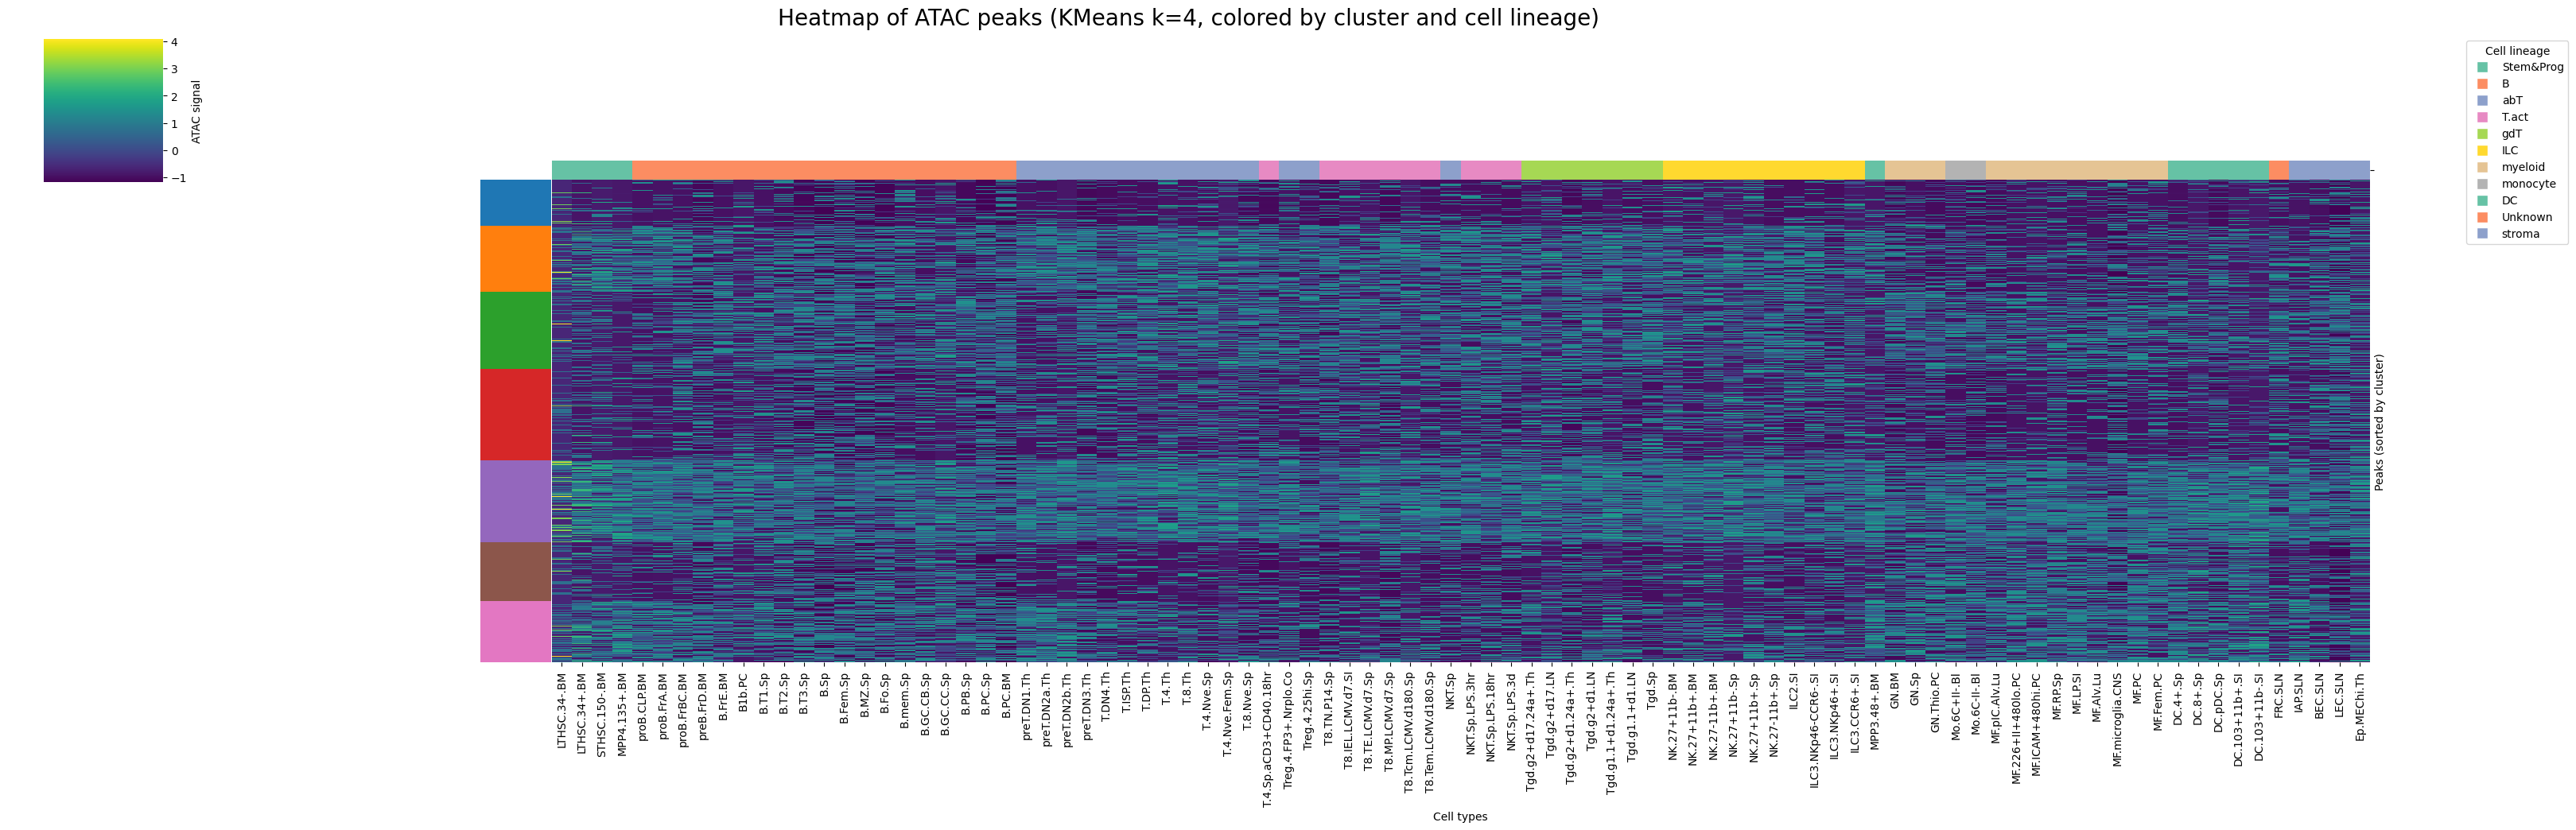

In [ ]:
# Add cluster labels to DataFrame
ATAC_scaled_ct["cluster"] = labels_7  

# Sort peaks by cluster
ATAC_sorted = ATAC_scaled_ct.sort_values("cluster")

# Define cluster colors (e.g., 7 clusters)
cluster_colors = sns.color_palette("tab10", 7)
row_colors = [cluster_colors[i] for i in ATAC_sorted["cluster"]]

# Remove 'cluster' column for the heatmap itself
heatmap_data = ATAC_sorted.drop(columns="cluster")

# Load QC file to map cell types to lineages
QC = pd.read_csv("data/ATAC_QCmatric.csv", sep=";")
QC.columns = QC.columns.str.strip()
QC["CellType"] = QC["CellType"].str.strip()
QC["Lineage"] = QC["Lineage"].str.strip()

# Create mapping from cell type to lineage (one per cell type)
celltype_to_lineage = QC.drop_duplicates("CellType").set_index("CellType")["Lineage"]

# Extract column names (= cell types) from heatmap_data
cell_types = heatmap_data.columns.tolist()

# Create column colors: map each cell type to its lineage color
lineages = [celltype_to_lineage.get(ct, "Unknown") for ct in cell_types]
unique_lineages = pd.unique(lineages)
palette = dict(zip(unique_lineages, sns.color_palette("Set2", len(unique_lineages))))
col_colors = pd.Series(lineages, index=cell_types).map(palette)

# Draw the heatmap
g = sns.clustermap(
    heatmap_data,
    cmap="viridis",
    yticklabels=False,
    row_colors=row_colors,
    col_colors=col_colors,
    col_cluster=False,
    row_cluster=False,
    figsize=(30, 10),
    cbar_kws={'label': 'ATAC signal'}
)

# Add title and axis labels
plt.suptitle("Heatmap of ATAC peaks (KMeans k=4, colored by cluster and cell lineage)", y=1.02, fontsize=20)
g.ax_heatmap.set_xlabel("Cell types")
g.ax_heatmap.set_ylabel("Peaks (sorted by cluster)")
g.ax_col_dendrogram.legend(
    handles=[plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=col, markersize=10, label=lab)
             for lab, col in palette.items()],
    title="Cell lineage",
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

plt.show()

### b) Visualize behaviour of clustered regions

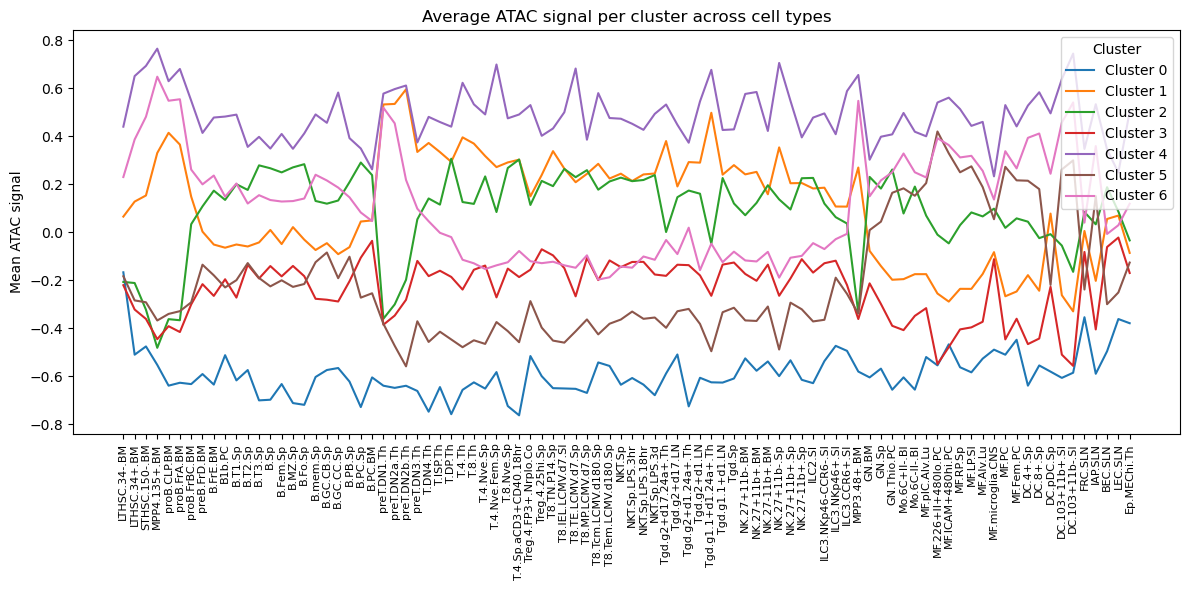

In [ ]:
# Reassign cluster labels
ATAC_scaled_ct["cluster"] = labels_7

# Group peaks by cluster and compute mean per cell type (column)
mean_per_cluster = ATAC_scaled_ct.groupby("cluster").mean()

# Line plot: signal trend across cell types
plt.figure(figsize=(12, 6))
for i in mean_per_cluster.index:
    plt.plot(mean_per_cluster.columns, mean_per_cluster.loc[i], label=f'Cluster {i}')
plt.legend(title="Cluster")
plt.title("Average ATAC signal per cluster across cell types")
plt.ylabel("Mean ATAC signal")
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()

### c) Define cell lineage-specific CRE clusters

/opt/miniconda3/envs/envBCells1/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


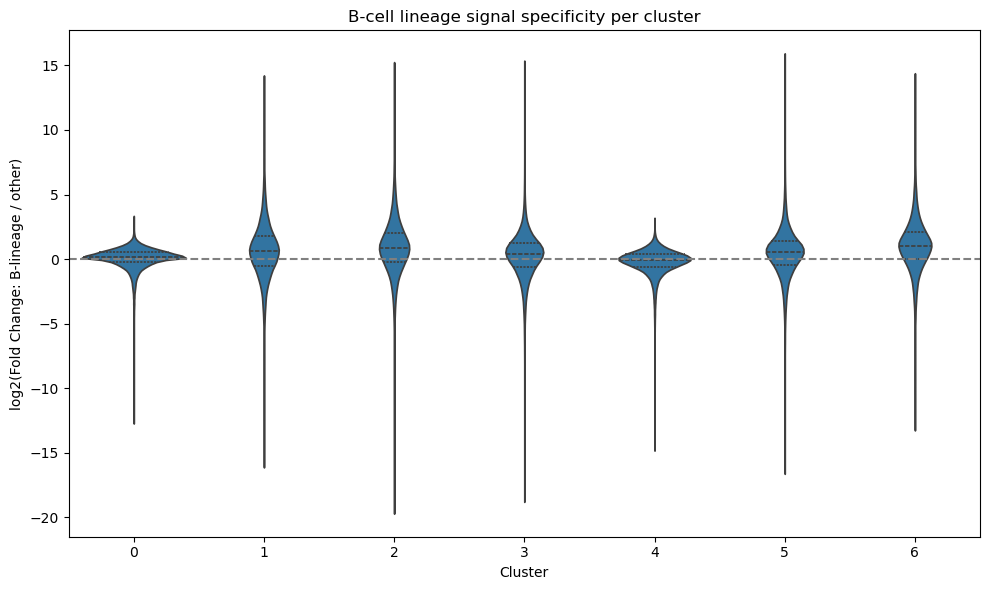

B-lineage-specific clusters: [2, 6]


In [ ]:
# Load QC file to map cell types to lineage 
QC = pd.read_csv("data/ATAC_QCmatric.csv", sep=";")
QC.columns = QC.columns.str.strip()
QC["CellType"] = QC["CellType"].str.strip()
QC["Lineage"] = QC["Lineage"].str.strip()

# Get cell types assigned to the B-cell lineage 
b_lineage_celltypes = QC[QC["Lineage"] == "B"]["CellType"].tolist()

# Separate signal matrix and clusters 
signal_data = ATAC_scaled_ct.drop(columns="cluster")
clusters = ATAC_scaled_ct["cluster"]

# Filter columns for B-cells based on QC file 
b_cell_cols = [col for col in signal_data.columns if col in b_lineage_celltypes]
other_cols = [col for col in signal_data.columns if col not in b_cell_cols]

# Safety check
if len(b_cell_cols) == 0:
    raise ValueError("No B-lineage cell type columns found!")

# Calculate mean signal per peak 
b_signal = signal_data[b_cell_cols].mean(axis=1)
other_signal = signal_data[other_cols].mean(axis=1)

# Compute fold-change (B / others) 
fold_change = b_signal / (other_signal + 1e-9)

# Combine into DataFrame 
fc_cluster_df = pd.DataFrame({
    "fold_change": fold_change,
    "cluster": clusters
})

# Log2 transform for symmetry 
fc_cluster_df["log2_fc"] = np.log2(fc_cluster_df["fold_change"] + 1e-9)

# Violin plot: B-cell specificity per cluster 
plt.figure(figsize=(10,6))
sns.violinplot(x="cluster", y="log2_fc", data=fc_cluster_df, inner="quartile")
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Cluster")
plt.ylabel("log2(Fold Change: B-lineage / other)")
plt.title("B-cell lineage signal specificity per cluster")
plt.tight_layout()
plt.show()

# Identify B-lineage-specific clusters (e.g., mean log2FC > 1.5) 
mean_log2fc_per_cluster = fc_cluster_df.groupby("cluster")["log2_fc"].mean()
b_specific_clusters = mean_log2fc_per_cluster[mean_log2fc_per_cluster > 0.8].index.tolist()

print("B-lineage-specific clusters:", b_specific_clusters)

Clusters 0 and 2 show significantly higher B-cell signal compared to other cell types, indicating these clusters contain regulatory elements that are likely specific to B-cell lineage. This suggests that these clusters represent cell lineage-specific CREs important for B-cell function.

### d) Differences between cell-lineage-specific CRE clusters → activity

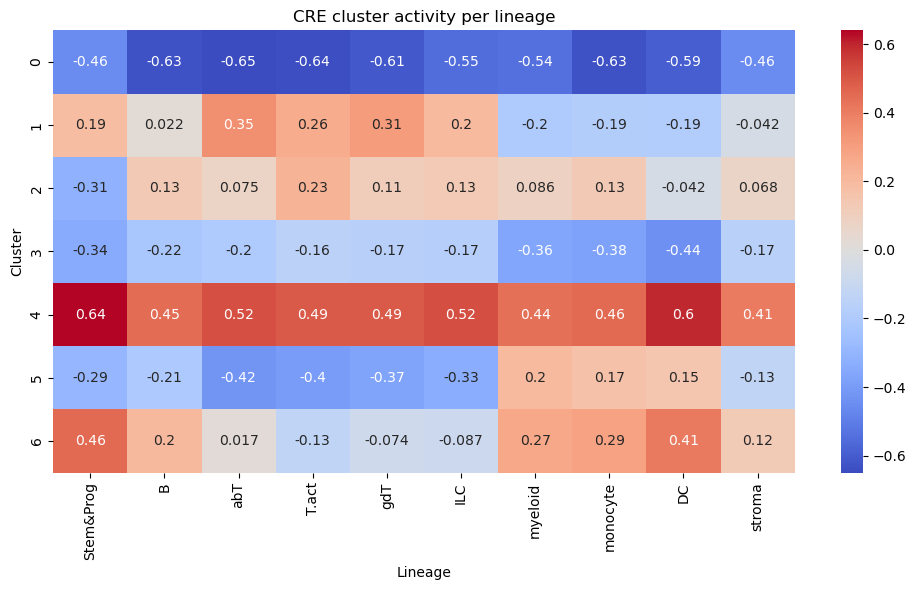

In [ ]:
# 1. Load QC matrix and create CellType → Lineage mapping
QC = pd.read_csv("data/ATAC_QCmatric.csv", sep=";")
QC.columns = QC.columns.str.strip()
QC["CellType"] = QC["CellType"].str.strip()
QC["Lineage"] = QC["Lineage"].str.strip()

celltype_to_lineage = QC.drop_duplicates("CellType").set_index("CellType")["Lineage"]

# 2. Extract ATAC signal data and cluster labels
signal_data = ATAC_scaled_ct.drop(columns="cluster")
clusters = ATAC_scaled_ct["cluster"]

# 3. Map each column (cell type) to its lineage
lineage_per_column = signal_data.columns.map(celltype_to_lineage)

# Optional: remove cell types not in QC (i.e., lineage = NaN)
valid_columns = ~lineage_per_column.isna()
signal_data = signal_data.loc[:, valid_columns]
lineage_per_column = lineage_per_column[valid_columns]

# Rename columns to lineage
signal_data.columns = lineage_per_column

# 4. Calculate mean signal per lineage
lineage_means = signal_data.groupby(signal_data.columns, axis=1).mean()

# 5. Add cluster labels back
lineage_means["cluster"] = clusters.values

# 6. Average signal per cluster across lineages
cluster_lineage_activity = lineage_means.groupby("cluster").mean()

#order of lineages 
lineage_order = QC.drop_duplicates("Lineage")["Lineage"].tolist()
lineage_order = [l for l in lineage_order if l in cluster_lineage_activity.columns]
cluster_lineage_activity = cluster_lineage_activity[lineage_order]

# 7. Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_lineage_activity, cmap="coolwarm", annot=True)
plt.title("CRE cluster activity per lineage")
plt.xlabel("Lineage")
plt.ylabel("Cluster")
plt.tight_layout()
plt.savefig("figures/CRE_clusters.png", dpi=300, bbox_inches="tight")
plt.show()

Trying plots

/opt/miniconda3/envs/envBCells1/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/3f/pxvhxt1x4477ds3p64jyb_6c0000gn/T/ipykernel_15721/3224229138.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("tab10", k)  # Only k colors!


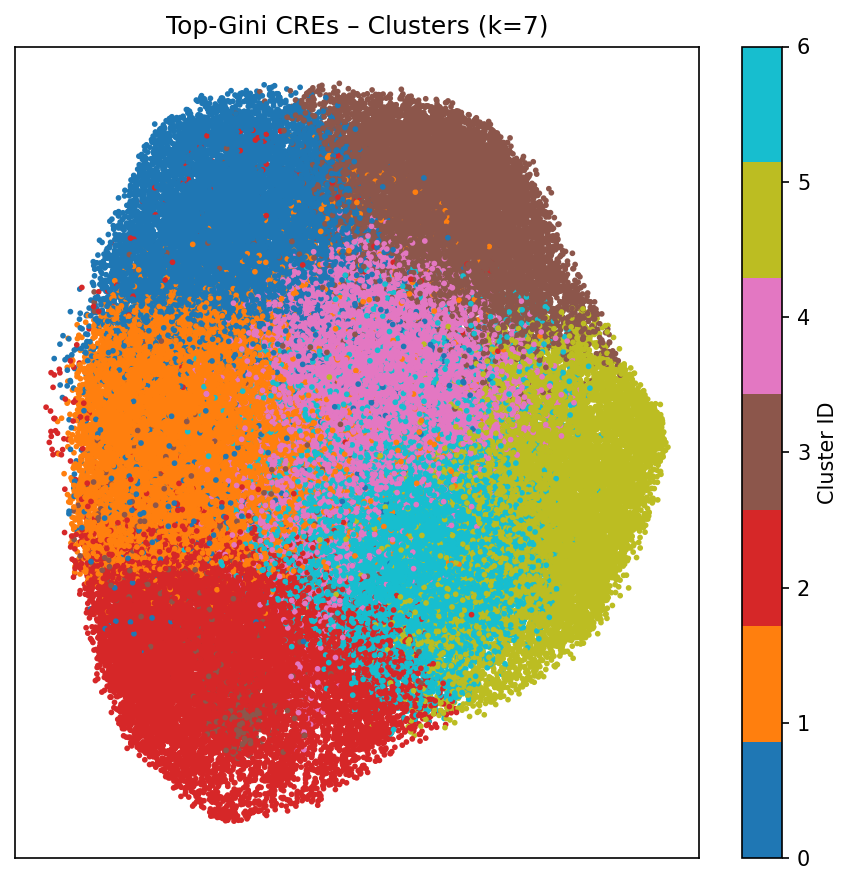

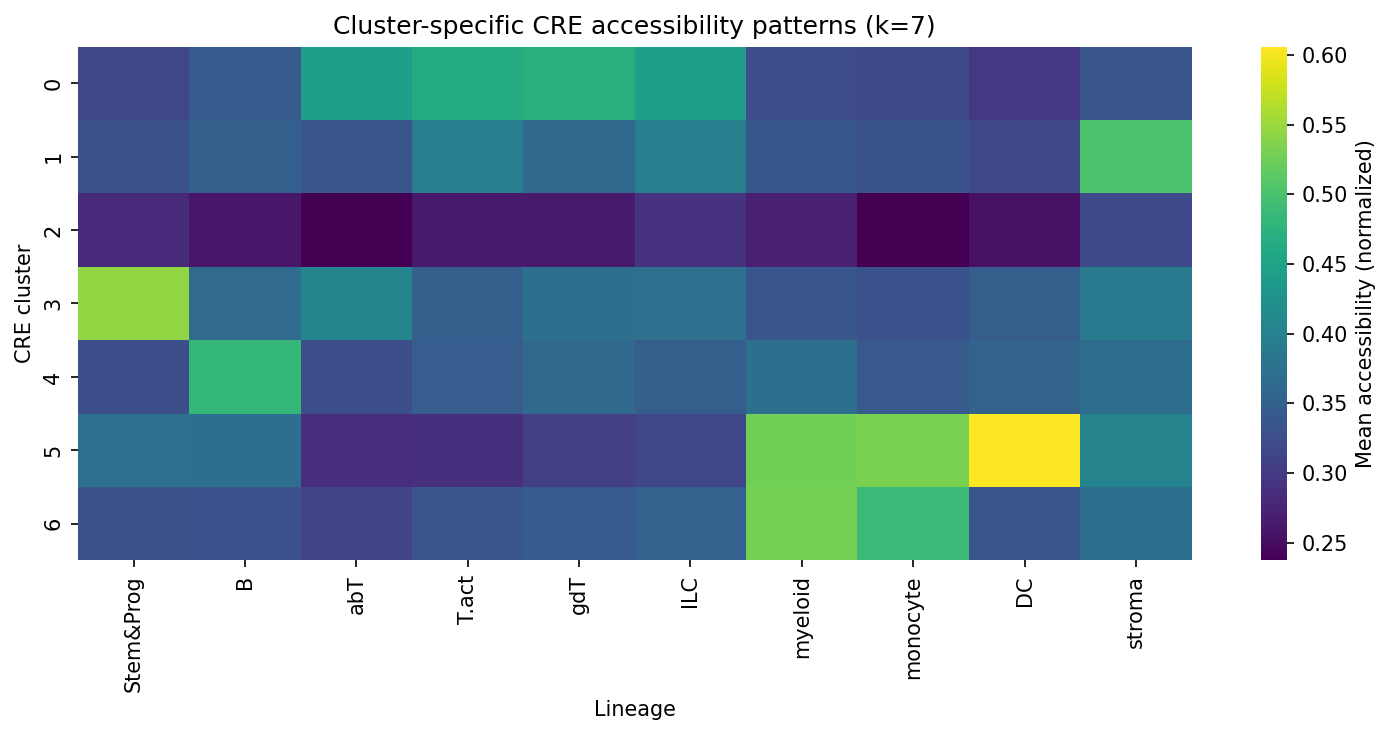

In [ ]:
import pandas as pd, numpy as np, pathlib
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize
from matplotlib import cm

# === Load and prepare data ===
ATAC_MATRIX = pathlib.Path("data/1.ATAC-Seq data.CSV")
mat = pd.read_csv(ATAC_MATRIX, sep=";", index_col=0)
mat = mat.loc[:, ~mat.columns.str.startswith("Unnamed")]
mat = mat.apply(pd.to_numeric, errors="coerce").fillna(0.0)

# === Preprocessing ===
mat_log = np.log2(mat + 0.1)
mat_qnorm = (mat_log.rank(axis=0) / (len(mat_log) - 1)).astype(np.float32)

# === Gini index function ===
def gini(row):
    x = np.sort(row.values)
    i = np.arange(1, x.size + 1)
    return ((2 * i - x.size - 1) * x).sum() / (x.size * x.sum())

# === Calculate Gini for each row ===
gini_scores = mat_qnorm.apply(gini, axis=1)
top_gini_mask = gini_scores >= gini_scores.quantile(0.80)
mat_cre = mat_qnorm.loc[top_gini_mask].copy()  # Avoids SettingWithCopyWarning

# === PCA for dimensionality reduction (10 components) ===
pca = PCA(n_components=10, random_state=42)
mat_pca = pca.fit_transform(mat_cre)

# === KMeans clustering (choose your k here, e.g. 4) ===
k = 7  # ← you can change this value
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(mat_pca)
mat_cre["cluster"] = cluster_labels

# === UMAP embedding ===
umap_coords = umap.UMAP(n_neighbors=30, min_dist=0.3, random_state=42).fit_transform(mat_pca)

# === Color map adapted to number of clusters ===
cmap = cm.get_cmap("tab10", k)  # Only k colors!

plt.figure(figsize=(6, 6), dpi=150)
sc = plt.scatter(umap_coords[:, 0], umap_coords[:, 1], c=cluster_labels, cmap=cmap, s=3)
plt.title(f"Top-Gini CREs – Clusters (k={k})")
plt.xticks([]); plt.yticks([])
cbar = plt.colorbar(sc, ticks=range(k))
cbar.set_label("Cluster ID")
plt.tight_layout()
plt.savefig("figures/Top-Gini CRE- Cluster_ UMAP.png", dpi=300, bbox_inches="tight")
plt.show()

# === Cluster-wise average accessibility (heatmap) ===
QC = pd.read_csv("data/ATAC_QCmatric.csv", sep=";")
QC.columns = QC.columns.str.strip()
QC["CellType"] = QC["CellType"].str.strip()
QC["Lineage"] = QC["Lineage"].str.strip()

celltype_to_lineage = QC.drop_duplicates("CellType").set_index("CellType")["Lineage"]

# Map columns (cell types) to lineages
signal_data = mat_cre.drop(columns="cluster")
clusters = mat_cre["cluster"]
lineage_per_column = signal_data.columns.map(celltype_to_lineage)
valid_columns = ~lineage_per_column.isna()
signal_data = signal_data.loc[:, valid_columns]
lineage_per_column = lineage_per_column[valid_columns]

# Rename columns to lineage
signal_data.columns = lineage_per_column

# Compute mean signal per lineage
lineage_means = signal_data.groupby(signal_data.columns, axis=1).mean()

# Add cluster labels
lineage_means["cluster"] = clusters.values

# Compute mean per cluster across lineages
cluster_lineage_activity = lineage_means.groupby("cluster").mean()

# Reorder lineages according to QC matrix
lineage_order = QC.drop_duplicates("Lineage")["Lineage"].tolist()
lineage_order = [l for l in lineage_order if l in cluster_lineage_activity.columns]
cluster_lineage_activity = cluster_lineage_activity[lineage_order]

# === Heatmap: Cluster-wise average accessibility per lineage ===
plt.figure(figsize=(10, 5), dpi=150)
ax = sns.heatmap(cluster_lineage_activity, cmap="viridis", xticklabels=True,
                 cbar_kws={"label": "Mean accessibility (normalized)"})
plt.title(f"Cluster-specific CRE accessibility patterns (k={k})")
plt.xlabel("Lineage")
plt.ylabel("CRE cluster")
plt.tight_layout()
plt.savefig("figures/Cluster-specific CRE accessibility patterns.png", dpi=300, bbox_inches="tight")
plt.show()
